# Creative Nation official data analysis

This notebook contains the core of the data analysis for creative nation.

We will load a variety of official data sources (BRES, IDBR, ABS...), explore them and visualise them. We will generate figures to be used in the report.

**Stages**

* Load data and metadata
* Process data
* Generate visualisations


In [664]:
%matplotlib inline
import pysal
from scipy.stats import linregress
import geopandas as gp
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

import mpld3
import matplotlib.patches as mpatches
import matplotlib as mpl


#Imports

#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data (to download the GRID database)
ext_data = os.path.join(top,'data/external')

frontier_data = ext_data+'/frontier'

#Interim data (to place seed etc)
int_data = os.path.join(top,'data/interim')

#Figures
fig_path = os.path.join(top,'reports/final_figures')

#Models
mod_path = os.path.join(top,'models')

#Visualisations
viz_path = os.path.join(top,'src/visualization')

#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

In [280]:
#Functions
def create_lq_df(df,year=None):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    
    if year!=None:
        lqs['year'] = year
    
    return(lqs)


#Some functions to scale values (we use this to convert straight lines into sigmoids)
import math

def sigmoid(x):
    '''
    Sigmoid of a vector
    
    '''
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a


def rescale(vector):
    '''
    Rescale to 0-1 value
    
    '''
    
    v_range = max(vector)-min(vector)
    
    scaled = [(val-min(vector))/v_range for val in vector]
    return(scaled)


def descale(vector,vmin,vmax):
    '''
    Descales a vector
    
    '''
    
    descaled = [((x - min(vector)) / (max(vector) - min(vector) )) * (vmax - vmin) + vmin for x in vector]
    
    #descaled = [(val+vmin)*(vmax-vmin) for val in vector]
    
    return(descaled)


def get_share_over_variable(df,var,grouper,drop):
    '''
    
    #This function groups over all the other variables in the DF and returns the share of the variable in the total.
    #Grouper are the variables to group over, drop is a variable to drop
    
    '''
    
    #Drop the variable we don't want (in this case, it is the second year - which we don't want to group by
    #because then we get the shares over a single observation!)
    if drop!=None:
        df = df.drop(drop,axis=1)
    
    #Create variables to group over
    other_vars = [x for x in df.columns if x not in [var,grouper]]
    
    #Produce the share
    out = df.groupby(other_vars)[var].apply(lambda x: x/x.sum())
    
    #Out it comes
    return(out)

def extract_cumulatives(my_series,variable,my_breaks,sector):
    '''
    This function takes a variable and a list of breaks (rankings)
    It returns a table with the % of activity by group
    It also takes the sector name to label the series (it helps later when we concatenate variables)
    
    '''
    
    #Load my series, create shares and sort to get bigger TTWAs at the top
    ordered = my_series.dropna().sort_values(ascending=False).reset_index(drop=True)/my_series.sum()
    
    
    #Turn this into a dataframe
    ordered_df = ordered.reset_index(drop=False)
    
    #Bin into categories
    ordered_df['bins'] = pd.cut(ordered_df.index,my_breaks,include_lowest=True,right=False)
    
    #Aggregate over categories
    cumulative = ordered_df.groupby('bins')[variable].sum().cumsum()    
    cumulative.name=sector
    return(cumulative)

def cluster_map(df,ax,sector,esp_var,act_var,my_cmap='YlOrRd',threshold=0.75):
    '''
    Creates a choropleth for a sector and variable. Considers a specialisation variable to 
    colour and an activity variable to threshold
    
    '''
    
    #Map
    map_data = df.loc[df.sector==sector,:]
    
    #Select the data to map if there is specialisation and the variable is above a certain threshold
    map_data['processed'] = [x if x>1 and y> map_data[act_var].quantile(threshold) else np.nan 
                             for x,y in zip(map_data[esp_var],map_data[act_var])]
    
    #Then quantise
    map_data['processed_quantised'] = pd.qcut(map_data['processed'],
                                             q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
   
    #Plot map
    map_data.plot(ax=ax,color='lightgrey',
                  #edgecolor='white',linewidth=0.5
                 )
    
    
    m=map_data.dropna(axis=0,subset=['processed']).plot(ax=ax,
                  column='processed_quantised',
                  #color=['coral' if x >1 else 'steelblue' for x in map_data[variable_to_map]],
                  #legend=True,
                                                      cmap=my_cmap
                 )
    
    #Set axis off
    ax.set_xlim(0,940000)
    ax.axis('off')
    
    ax.set_title(sector,y=1.01,size=12)
    return(m)

#Function to extract neighbour stats
def get_neighbour_stats(df,sector,var):
    '''
    This function loops over each TTWA and estimates the mean scores of its neighbours in a variable (for a sector)
    It returns a dataframe with the means and a matrix combining their scores
    
    '''
    
    #Is it employment or bc?
    
    if var=='emp':
        var_1 = 'emp_lq_change'
        var_2 = 'emp_growth'
    else:
        var_1 = 'bc_lq_change'
        var_2 = 'bc_growth'
    
    
    #First step: subset by sector
    df_sector = df.loc[df.sector==sector,:]
    
    #Create a container
    cont = []
    mat = []
    #Second step: 
    #For each TTWA, subset by the neighbors and calculate averages.
    for x in df_sector['ttwa_name']:
        
        #Area's own score
        own_score = float(df_sector.loc[df_sector.ttwa_name==x,var_1])
        
        #Extract neighbours
        try:
            neighs = neighbors_looked_up[x]
    
            #Subset variable to get neighbours
            neighbours = df_sector.loc[[x in neighs for x in df_sector['ttwa_name']],['ttwa_name',var_1]]
            
            #Calculate mean
            value = neighbours[var_1].dropna().mean()
            
            #Create new DF with all the neighbour info
            neighbours_2 = neighbours.set_index('ttwa_name')
            
            #Name the neighbours and transpose for concatenating on rows
            neighbours_2.columns=[x]
            neighbours_2 = neighbours_2.T
            
            #Create series
            out = pd.Series({'ttwa_name':x,'neighs':", ".join(neighs),'{n}_neighbor'.format(n=var):value,
                           '{n}_own'.format(n=var):own_score})
            
            mat.append(neighbours_2)

            
        except:
            out = pd.Series({'ttwa_name':x,'neighs':np.nan,'{n}_neighbor'.format(n=var):np.nan,
                           '{n}_own'.format(n=var):own_score})
        
        
        cont.append(out)


    
    #Out simple
    out_df = pd.DataFrame(cont).reset_index(drop=True)    
    
    #Add quantised data
    df_sector['{var}_growth_q'.format(var=var)] = pd.qcut(
        df_sector[var_2],q=np.arange(0,1.1,0.1),labels=False,duplicates='drop') 
    
    
    #Out matrix
    out_mat = pd.concat(mat)
    
    return([pd.concat([out_df.set_index('ttwa_name'),
                       df_sector.set_index('ttwa_name')],axis=1)])
        

    
def map_sector(sector,ax,df,neighbor_lookup,my_cmap='RdBu_r'):
    '''
    This function takes a sector and plots it, together with the scatter showing area / neighbour performance
    
    '''
    
    #Subset
    map_data = ttwa_merged.loc[ttwa_merged.sector==sector,:]
    
    #Quantise the employment change df
    map_data['employment_change_q']= pd.qcut(map_data['employment_change'],
                                           q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
    
    #Plot map
    map_data.plot(column='employment_change_q',
              ax=ax,cmap=my_cmap)
    
    #Set axis off
    ax.set_xlim(0,940000)
    ax.axis('off')
    
    #Add title (inserting breaks if needed)
    
    #split=sector.split(" ")
    
    #If the number of words is above 3 it in
    #split_rejoined = " ".join([x if num%3 == 0 else ' \n '+x for num,x in enumerate(split)])
    
    #if '\n' not in split_rejoined:
    #    split_rejoined+=' \n'
    
    ax.set_title(sector,y=1.01,size=12)

    
    # Manually set the position and relative size of the inset axes within ax1
    ax2 = inset_axes(ax,
                     width='30%',  # width = 10% of parent_bbox width
                     height=1,  # height : 50%
                     #loc=1,bbox_to_anchor=(0,0,1,1)
                     loc=1
                    )

    
    #Other data
    scatter_data = neighbor_lookup[sector]
    
    #Remove infinites for the linear regression analysis
    lr_data = scatter_data[['emp_neighbor','emp_own']].replace([np.inf, -np.inf], np.nan)
    lr_data.dropna(inplace=True)
    
    #Regress
    linres = linregress(lr_data.iloc[:,0],lr_data.iloc[:,1])
    
    #print(linres)
    
    #Plot
    ax2.plot(
        #Exes
        [lr_data['emp_neighbor'].min(),
        lr_data['emp_neighbor'].max()],        
        
        #Ys (including intercept and regression coefficient)
        [linres[1],
            #lr_data['emp_own'].min()+linres[1],
         lr_data['emp_own'].max()*linres[0]+linres[1]],
        
        #Styles
        color='black',linestyle='--',linewidth=1)
    
    #Add x & y vlines
    ax2.vlines(x=1,
                   ymin=lr_data['emp_own'].min(),
                   ymax=lr_data['emp_own'].max(),color='grey',linestyle=':',linewidth=1)
    
    ax2.hlines(y=1,xmin=lr_data['emp_neighbor'].min(),
                   xmax=lr_data['emp_neighbor'].max(),color='grey',linestyle=':',linewidth=1)
    
    ax2.set_ylim([0,lr_data.emp_own.max()])
    
    
    #Plot region data
    for region in set(scatter_data['region']):
        #print(reg)
        sub_data = scatter_data.loc[[r==region for r in scatter_data.region],:]
        
        
        ax2.scatter(sub_data['emp_neighbor'],sub_data['emp_own'],
                        s=3*sub_data['emp_growth_q'],
                        color=color_lookup[region],
                        edgecolor=['red' if val>0 else 'blue' for val in sub_data['emp_growth']],
                        linewidth=0.5,alpha=0.7
                       )
        
    ax2.tick_params('both',size=8)
    
    ax2.set_ylabel('Growth in area',size=8)
    ax2.set_xlabel('Growth in \n neighbour (mean)',size=8)
    
    return(ax)


def process_gdyn_data(df,name):
    '''
    Processes a growth dynamics dataframe
    '''
    gdf = df.loc[df.cohort=='2013-2016',my_vars].reset_index(drop=True).loc[:10].set_index('Unnamed: 1')
    
    gdf['share_all_firms'],gdf['share_all_employment'] = [gdf[x]/gdf[x].sum() for x in 
                                                          ['Number of firms','Change in employment']]
    
    gdf['jobs_per_firm'] = gdf['Change in employment']/gdf['Number of firms']
    
    
    gdf['sector'] = name
    
    return(gdf)
    
def process_survival(sheetname):
    '''
    Reads and processes a 'survival' file
    
    
    '''
    
    surv = pd.read_excel(frontier_data+'/spd-survival statistics-06-11-2017-STC.xlsx',sheetname=sheetname)
    surv['industry']= ['creative' if x!='Other or unknown' else 'non_creative' for x in surv['industry']]


    surv_totals = surv.groupby('industry').sum()

    surv_out = surv_totals.loc[:,['rate' not in x for x in surv_totals.columns]].apply(lambda x: x/x[0],axis=1)
    
    return(surv_out) 


#Employment diversity

def herfindahl(series):
    '''
    Extract the herfindahl index for a series (sum of squared market-shares)
    
    '''

    hi = sum([(x/np.sum(series))**2 for x in series])
    return(hi)

def add_positives(series):
    '''
    Returns the sum of the positives in a series
    
    '''
    out = np.sum(series>1)
    return(out)

def normalise(series):
    '''
    Normalises the series
    
    '''
    
    norm = [(x - series.mean())/series.std() for x in series]
    return(norm)


def extract_network_from_corpus(label_corpus,edge_attr="None",stop_words=None):
    """
    Extracts a network object from a list or series where every observation is a list of co-ocurring observations
    (e.g. interacting agents, or co-occurring words). 
    In the network output, the labels are nodes and co-occurrences between them are edges. 
    Weight is number of co-occurrences. There is the option to consider additional edge attributes.

    Inputs:
    label_corpus: corpus of documents with label co-occurrence or node interaction.
    edge_attr: an edge attribute associated to the interaction. It defaults to the string none (which we use
        for control flow)
    stop_words: labels to remove (e.g. generic terms)
    
    Returns a networkx object.
    
    """
    label_pairs_container =[]
    
    #!!! TODO Using type to control flow feels a bit hacky.
    if type(edge_attr) != str:
        #Container for pairs of labels
        edge_attr_name = edge_attr.name
    
    #For each pair
    for i in range(len(label_corpus)):
    
    #List of tuples where every tuple is a combination of topics
        pairs = list(combinations(label_corpus[i],2))
    
    #Extract these as lists of dicts capturing connections between topics, and add those to the container.
    #NB we are sorting the tuples to make sure that we don't duplicate edges.
        if len(pairs)>0:
            cont = [{'e1':sorted(tup)[0],'e2':sorted(tup)[1]} for tup in pairs]
            
            #Give each edge its corresponding attribute (if we have one)
            if type(edge_attr) != str:
                for d in cont:
                    d.update({edge_attr_name: edge_attr[i]})

            label_pairs_container.append(cont)

    #Flatten dict list and turn into DF
    label_pairs_df = pd.DataFrame([ds for sublist in label_pairs_container for ds in sublist])
    
    #Extract weights (depends on edge_attr)
    if type(edge_attr) != str:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2',edge_attr_name]
                                                        ).size()).reset_index().sort_values(by=0,ascending=False)
    else:
        label_edgelist = pd.DataFrame(label_pairs_df.groupby(['e1','e2']
                                                        ).size()).reset_index().sort_values(by=0,ascending=False)
    
    label_edgelist.rename(columns={0:'weight'},inplace=True)
    
    #Remove stop-words
    if stop_words != None:
        has_ttm =  [x in stop_words or y in stop_words for x,y in zip(label_edgelist['e1'],label_edgelist['e2'])]
        label_edgelist = label_edgelist[-pd.Series(has_ttm)]
    
    #Create label graph
    if type(edge_attr) != str:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight',edge_attr_name])
    else:
        label_graph = nx.from_pandas_dataframe(label_edgelist,'e1','e2',['weight'])
    
    return(label_graph)    



### Metadata

In [665]:
#A couple of missing TTWAs in the data below

missing_ttwas = pd.DataFrame({'region': {0: 'West Midlands', 1: 'Scotland', 2: 'South East', 3: 'Scotland'},
 'ttwa_code': {0: 'E30000277', 1: 'S22000013', 2: 'E30000278', 3: 'S22000013'},
 'ttwa_name': {0: 'Telford',1: 'Western Isles',2: 'Thanet',3: 'Eilean Siar'}}).reset_index(drop=True)

In [666]:
#TTWA names, region lookups, information about whether a TTWA is a cluster or not

#Codes and names
ttwa_name_df = pd.concat([pd.read_csv(ext_data+'/ttwa_name_df.csv'),
                          missing_ttwas[['ttwa_code','ttwa_name']]]).reset_index(drop=True)


#TTWA Code - name lookup
ttwa_name_lookup = {x:y for x,y in zip(ttwa_name_df.ttwa_code, ttwa_name_df.ttwa_name)}

#Regions and info about whether they are a cluster
ttwa_region_df = pd.read_excel(ext_data+'/geography_of_creativity_data.xlsx',sheet_name=0)

ttwa_region_lookup = {x:y for x,y in zip(ttwa_region_df.TTWA,ttwa_region_df.region)}

#Add regions for the missing ones
ttwa_region_lookup['Thanet'] = 'South England'
ttwa_region_lookup['Eilean Siar']= 'Scotland'
ttwa_region_lookup['Western Isles'] = 'Scotland'
ttwa_region_lookup['Telford'] = 'West Midlands'


#Turn into a list
ttwa_is_cluster = list(ttwa_region_df.loc[ttwa_region_df.creative_cluster=='yes','TTWA'])

#Add Birmingham
ttwa_is_cluster.append('Birmingham')

#Rename
my_ttwas = ttwa_is_cluster


In [669]:
#Import python for spatial analysis library

#Create lookup of ttwas
ttwa_names_to_codes_lookup = {v:k for k,v in ttwa_name_lookup.items()}

ttwas_coded = pd.DataFrame({'ttwa_code':[x for x in ttwa_names_to_codes_lookup.values()],
                            'ttwa_name':[x for x in ttwa_names_to_codes_lookup.keys()]})


In [667]:
#Geographical stuff
#Get Shapefile here:
#https://geoportal.statistics.gov.uk/Docs/Boundaries/Travel_to_Work_Areas_(UK)_2011_boundaries_(generalised_clipped)_V3.zip

#Load shapefile
shapefile_loc = ext_data+'/Travel_to_Work_Areas_(UK)_2011_boundaries_(generalised_clipped)_V3'

ttwa_shp = pysal.open(shapefile_loc+'/TTWA_2011_UK_BGC_V3.shp')

#Read shapefile weights and attributes
#And attributes
w = pysal.rook_from_shapefile(shapefile_loc+"/TTWA_2011_UK_BGC_V3.shp")
attr = pysal.open(shapefile_loc+"/TTWA_2011_UK_BGC_V3.dbf")



/usr/local/lib/python3.5/site-packages/pysal/weights/weights.py:189: UserWarning: There are 5 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/usr/local/lib/python3.5/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 9, 166, 167, 168, 169
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


### IDBR ((Interdepartmental Business Register) data

The interdepartmental business register is a register of UK business with information about number of businesses, employment and turnover by TTWA. We report company descriptives based on an analysis of IDBR microdata, size distribution information using data from NOMIS (a portal for official labour market statistics) and some data processed by Frontier Ecomnomics at the Virtual Microdata laboratory.

We load these things in turn

In [676]:
#Load idbr frontier data
idbr_frontier = pd.read_csv(frontier_data+'/8_1_2018_idbr_frontier.csv')

idbr_frontier.head()

,business_count,employment,industry,ttwa_code,ttwa_name,year
0,65.0,190.0,Advertising and marketing,S22000047,Aberdeen,2015_2016
1,1247.5,3635.0,All creative industries,S22000047,Aberdeen,2015_2016
2,182.5,495.0,Architecture,S22000047,Aberdeen,2015_2016
3,110.0,205.0,"Design: product, graphic and fashion design",S22000047,Aberdeen,2015_2016
4,82.5,205.0,"Film, TV, video, radio and photography",S22000047,Aberdeen,2015_2016


In [688]:
#Create dataframe with idbr LQs
#Subsectoral (ie we remove the all creative industries when estimating the LQs)

#This calculates yearly employment and business count LQs by creative subsector with the function we defined above.
#NB we remove all creative industries to avoid double counting

#We are using a list comprehension to choose what variable to process
empl_lqs_subectoral, bc_lqs_subsectoral = [pd.concat([create_lq_df(pd.pivot_table(idbr_frontier.loc[
    (idbr_frontier['year']==year) & (idbr_frontier['industry']!='All creative industries'),:],
                                index=['year','ttwa_name'],columns='industry',values=variable)) for 
                       year in ['2011_2014','2015_2016']]).reset_index(drop=False) for variable in 
                                           ['employment','business_count']]

#Here we calculate yearly employment LQs in creative industries and outside. We remove
#all creative subsectors to avoid double counting

empl_lqs_sectoral, bc_lqs_sectoral = [pd.concat([create_lq_df(pd.pivot_table(idbr_front.loc[
    (idbr_front['year']==year) & ([x in ['All creative industries','not_creative'] for x in idbr_front['industry']]),:],
                                index=['year','ttwa_name'],columns='industry',values='employment')) for 
                       year in ['2011_2014','2015_2016']]).reset_index(drop=False).drop('not_creative',axis=1) 
                                      for variable in 
                                           ['employment','business_count']]


#empl wide
empl_totals, bc_totals = pd.pivot_table(idbr_front,index=['ttwa_name','ttwa_code','year'],columns='industry',
                            values='employment').reset_index(drop=False)




industry,year,ttwa_name,All creative industries
0,2011_2014,Aberdeen,0.472055
1,2011_2014,Aberystwyth,0.526555
2,2011_2014,Alness and Invergordon,0.362408
3,2011_2014,Andover,0.954975
4,2011_2014,Arbroath and Montrose,0.224127
5,2011_2014,Ashford,0.954975
6,2011_2014,Aviemore and Grantown-on-Spey,0.307260
7,2011_2014,Ayr,0.307260
8,2011_2014,Ballymena,0.168429
9,2011_2014,Banbury,1.241911


In [289]:
#Create dataframe with idbr LQs
#Subsectoral (ie we remove the all creative industries when estimating the LQs)

#This calculates yearly employment LQs by creative subsector with the function we defined above.
#NB we remove all creative industries to avoid double counting
empl_lqs_subsectoral = pd.concat([create_lq_df(pd.pivot_table(idbr_frontier.loc[
    (idbr_frontier['year']==year) & (idbr_frontier['industry']!='All creative industries'),:],
                                index=['year','ttwa_name'],columns='industry',values='employment')) for 
                       year in ['2011_2014','2015_2016']]).reset_index(drop=False)

#Here we calculate yearly employment LQs in creative industries and outside. We remove
#all creative subsectors to avoid double counting
empl_lqs_sectoral = pd.concat([create_lq_df(pd.pivot_table(idbr_front.loc[
    (idbr_front['year']==year) & ([x in ['All creative industries','not_creative'] for x in idbr_front['industry']]),:],
                                index=['year','ttwa_name'],columns='industry',values='employment')) for 
                       year in ['2011_2014','2015_2016']]).reset_index(drop=False).drop('not_creative',axis=1)

#empl wide
empl_totals = pd.pivot_table(idbr_front,index=['ttwa_name','ttwa_code','year'],columns='industry',
                            values='employment').reset_index(drop=False)

#And below we will need to replace bres with empl everywhere!

In [290]:
#bc totals
bc_totals = idbr_front.drop('employment',axis=1)

#Now we do the same thing for the idbr data
bc_all_wide = pd.pivot_table(idbr_front,index=['ttwa_name','year'],columns='industry',
                             values='business_count').reset_index(drop=False)

#Extract lqs
#Subsectoral
bc_lqs_subsectoral = pd.concat([create_lq_df(pd.pivot_table(idbr_front.loc[
    (idbr_front['year']==year) & (idbr_front['industry']!='All creative industries'),:],
                                index=['year','ttwa_name'],columns='industry',values='business_count')) for 
                       year in ['2011_2014','2015_2016']]).reset_index(drop=False)


#Sectoral
#Sectoral (ie we remove all other sectors when estimating the LQs and then drop not creative at the end)

bc_lqs_sectoral = pd.concat([create_lq_df(pd.pivot_table(idbr_front.loc[
    (idbr_front['year']==year) & ([x in ['All creative industries','not_creative'] for x in idbr_front['industry']]),:],
                                index=['year','ttwa_name'],
                                                         columns='industry',values='business_count')) for 
                       year in ['2011_2014','2015_2016']]).reset_index(drop=False).drop('not_creative',axis=1)

In [675]:
### IDBR DATA FROM NOMIS

In [671]:
#Load IDBR data
idbr_totals = pd.read_csv(int_data+'/5_11_2017_idbr_totals.csv')
idbr_sizebands = pd.read_csv(int_data+'/5_11_2017_idbr_sizeband.csv')

#Concatenate
idbr_all = pd.concat([idbr_totals,idbr_sizebands])

#Produce LQs
idbr_all_wide = pd.pivot_table(idbr_all.loc[idbr_all.sizeband=='Total'],
                               index=['year','ttwa_name'],columns='sector',values='value').reset_index(drop=False)

#We use the same format as before
idbr_lqs_subsectoral = pd.concat([create_lq_df(
    idbr_all_wide.loc[idbr_all_wide.year==x,
                     ['ttwa_name']+creative_subsector_lq_vars].set_index('ttwa_name'),year=x) for
                        x in [2016,2017]])

idbr_lqs_sectoral = pd.concat([create_lq_df(
    idbr_all_wide.loc[idbr_all_wide.year==x,
                     ['ttwa_name']+creative_industries_lq_vars].set_index('ttwa_name'),year=x) for
                        x in [2016,2017]])


### ABS (Annual Business Survey)

The Annual Business Survey is a database with information about the productivity of UK businesses. We will use these data in our productivity analysis


In [672]:
#Load GVA data from Frontier
gva = pd.read_excel(frontier_data+'/spd-GVA stats-15-11-2017v2.xlsx',sheetname=2)

/usr/local/lib/python3.5/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


### Growth dynamics (IDBR)

The growth dynamics data we use in our analysis is based on an analysis of IDBR micro-data by Frontier Economics


In [673]:
#Growth dynamics data by TTWA with information about types of businesses by growth category, 
# and the employment they generate (or destroy)
gdyn_ttwa = pd.read_excel(frontier_data+'/spd-growth dynamics-06-11-2017-STCv2.xlsx',sheetname=7)

#Survival data
surv_ttwa = pd.read_excel(frontier_data+'/spd-survival statistics-06-11-2017-STC (1).xlsx',sheetname=3)

#And UK levels
gdyn_creat = pd.read_excel(frontier_data+'/spd-growth dynamics-06-11-2017-STCv2.xlsx',sheetname=2)
gdyn_non_creat = pd.read_excel(frontier_data+'/spd-growth dynamics-06-11-2017-STCv2.xlsx',sheetname=3)
surv_uk = pd.read_excel(frontier_data+'/spd-survival statistics-06-11-2017-STC (1).xlsx',sheetname=1)

/usr/local/lib/python3.5/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


### Load IDBR data 

In [691]:
#Load idbr frontier
#Create LQs by subsector and LQs in the CIs
idbr_front = pd.read_csv(frontier_data+'/8_1_2018_idbr_frontier.csv')


#Create dataframe with idbr LQs
#Subsectoral (ie we remove the all creative industries when estimating the LQs)

empl_lqs_subsectoral = pd.concat([create_lq_df(pd.pivot_table(idbr_frontier.loc[
    (idbr_frontier['year']==year) & (idbr_frontier['industry']!='All creative industries'),:],
                                index=['year','ttwa_name'],columns='industry',values='employment')) for 
                       year in ['2011_2014','2015_2016']]).reset_index(drop=False)

#Sectoral (ie we remove all other sectors when estimating the LQs and then drop not creative at the end)
empl_lqs_sectoral = pd.concat([create_lq_df(pd.pivot_table(idbr_frontier.loc[
    (idbr_frontier['year']==year) & ([x in ['All creative industries','not_creative'] for x in idbr_frontier['industry']]),:],
                                index=['year','ttwa_name'],columns='industry',values='employment')) for 
                       year in ['2011_2014','2015_2016']]).reset_index(drop=False).drop('not_creative',axis=1)

#Here we produce wide versions of the totals.
empl_totals, bc_totals = [pd.pivot_table(idbr_frontier,index=['ttwa_name','ttwa_code','year'],columns='industry',
                            values=variable).reset_index(drop=False) for variable in ['employment','business_count']]

#This is a long version of the business count totals that we will also use later
bc_totals_long =  


industry,ttwa_name,ttwa_code,year,Advertising and marketing,All creative industries,Architecture,"Design: product, graphic and fashion design","Film, TV, video, radio and photography","IT, software and computer services","Music, performing and visual arts",Publishing,not_creative
0,Aberdeen,S22000047,2011_2014,187.00,3652.25,596.25,210.75,242.50,1368.250,514.75,532.750,214838.235294
1,Aberdeen,S22000047,2015_2016,190.00,3635.00,495.00,205.00,205.00,1600.000,590.00,350.000,223935.000000
2,Aberystwyth,W22000021,2011_2014,30.50,376.00,29.50,8.25,21.50,96.250,63.25,126.750,19789.473684
3,Aberystwyth,W22000021,2015_2016,NaN,395.00,NaN,NaN,NaN,NaN,NaN,NaN,20090.000000
4,Alness and Invergordon,S22000048,2011_2014,5.00,79.50,15.50,NaN,5.75,17.500,11.75,NaN,6115.384615
5,Alness and Invergordon,S22000048,2015_2016,NaN,90.00,NaN,NaN,NaN,NaN,NaN,NaN,6025.000000
6,Andover,E30000159,2011_2014,76.25,975.25,31.75,78.00,92.25,352.000,61.75,283.250,27864.285714
7,Andover,E30000159,2015_2016,95.00,1020.00,NaN,110.00,50.00,415.000,80.00,255.000,27035.000000
8,Arbroath and Montrose,S22000049,2011_2014,9.00,98.00,27.75,10.25,12.75,31.000,2.75,4.500,12250.000000
9,Arbroath and Montrose,S22000049,2015_2016,NaN,110.00,NaN,NaN,NaN,NaN,NaN,NaN,12570.000000


In [693]:
#bc totals
bc_totals = idbr_front.drop('employment',axis=1)

#Now we do the same thing for the idbr data
bc_all_wide = pd.pivot_table(idbr_front,index=['ttwa_name','year'],columns='industry',
                             values='business_count').reset_index(drop=False)

#Extract lqs
#Subsectoral
bc_lqs_subsectoral = pd.concat([create_lq_df(pd.pivot_table(idbr_front.loc[
    (idbr_front['year']==year) & (idbr_front['industry']!='All creative industries'),:],
                                index=['year','ttwa_name'],columns='industry',values='business_count')) for 
                       year in ['2011_2014','2015_2016']]).reset_index(drop=False)


#Sectoral
#Sectoral (ie we remove all other sectors when estimating the LQs and then drop not creative at the end)

bc_lqs_sectoral = pd.concat([create_lq_df(pd.pivot_table(idbr_front.loc[
    (idbr_front['year']==year) & ([x in ['All creative industries','not_creative'] for x in idbr_front['industry']]),:],
                                index=['year','ttwa_name'],
                                                         columns='industry',values='business_count')) for 
                       year in ['2011_2014','2015_2016']]).reset_index(drop=False).drop('not_creative',axis=1)

#### How much of the employment / business counts is accounted by selected creative clusters?

In [291]:
#Employment
empl_totals.loc[(empl_totals.year=='2015_2016') & ([x in my_ttwas for x in empl_totals.ttwa_name]),
                'All creative industries'].sum()/empl_totals.loc[empl_totals.year=='2015_2016',
                'All creative industries'].sum()

0.8259729505934309

In [292]:
#Business count
bc_all_wide.loc[(bc_all_wide.year=='2015_2016') & ([x in my_ttwas for x in bc_all_wide.ttwa_name]),
                'All creative industries'].sum()/bc_all_wide.loc[bc_all_wide.year=='2015_2016',
                'All creative industries'].sum()

0.75679000327442325

## 2. Analysis and visualisation

### a. Growth in creative industries activity

Here we will create a bump chart that compares creative industries growth in employment and business counts with what happens in other sectors


In [293]:
#Create DF with empl and bc changes

#empl
empl_changes = pd.pivot_table(pd.melt(empl_totals,id_vars=['ttwa_name','ttwa_code','year']).reset_index(drop=False),
               index=['ttwa_name','industry'],columns='year',values='value').reset_index(drop=False)

empl_changes['employment_change'] = empl_changes['2015_2016']/empl_changes['2011_2014']
empl_changes.rename(columns={'2015_2016':'emp_2015_2016','2011_2014':'emp_2011_2014',
                             'industry':'sector'},inplace=True)


#bc
bc_changes = pd.pivot_table(bc_totals,index=['industry','ttwa_name'],columns='year',
                            values='business_count').reset_index(drop=False)
bc_changes['business_change'] = bc_changes['2015_2016']/bc_changes['2011_2014']

#NB we change years to the financial year the data refers to
bc_changes.rename(columns={'2015_2016':'bc_2015_2016','2011_2014':'bc_2011_2014','industry':'sector'},inplace=True)

#Combine
all_changes = pd.concat([empl_changes.set_index(['ttwa_name','sector']),
                         bc_changes.set_index(['ttwa_name','sector'])],axis=1).reset_index(drop=False)


bc_lqs_subsectoral.to_csv(ext_data+'/{date}_bc_lqs_benchmarking.csv'.format(date=today_str))


#Add a region to each variable
all_changes['region'] = [ttwa_region_lookup[x] for x in all_changes['ttwa_name']]
all_changes['emp_total'] = all_changes['emp_2015_2016'] - all_changes['emp_2011_2014'] 
all_changes['bc_total'] = all_changes['bc_2015_2016'] - all_changes['bc_2011_2014'] 

#regions = set(ttwa_region_lookup.values())- set(['Northern Ireland'])

regions_sorted = list(reversed(all_changes.loc[
    all_changes.sector=='All creative industries',:].groupby(
    'region')['emp_total'].sum().sort_values(ascending=False).dropna().index))

sectors_sorted = all_changes.groupby('sector')['emp_2015_2016'].sum().sort_values(ascending=False).dropna().index[1:]

#Need to replace the infinites
all_changes.replace([np.inf,-np.inf],np.nan,inplace=True)
all_changes_no_nas = all_changes.dropna()

all_changes_in_clusters = all_changes.loc[[x in ttwa_is_cluster for x in all_changes.ttwa_name],:]

all_changes_no_nas['ttwa_code'] =[ttwa_names_to_codes_lookup[x] if x in ttwa_names_to_codes_lookup.keys() else np.nan
                                  for x in all_changes_no_nas['ttwa_name']]

all_changes_no_nas.dropna(axis=0,subset=['ttwa_code'],inplace=True)

#Need to fix this!!!! - add ttwa_code + ttwa_name + region for Thanet and Eo

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [294]:
set(idbr_front.ttwa_name)-set(ttwa_names_to_codes_lookup.keys())


missing_ttwas = idbr_front.loc[[
    x in ['Thanet','Eilean Siar','Telford','Western Isles','Taunton'] for x in idbr_front.ttwa_name],
    ['ttwa_name','ttwa_code']].drop_duplicates('ttwa_name').reset_index(drop=True)

#missing_ttwas['region'] = ['West Midlands','Scotland','South East','Scotland']

missing_ttwas.to_dict()

{'ttwa_code': {0: 'E30000277', 1: 'E30000278', 2: 'S22000013', 3: 'S22000013'},
 'ttwa_name': {0: 'Taunton',
  1: 'Telford',
  2: 'Western Isles',
  3: 'Eilean Siar'}}

In [295]:
all_changes.sort_values('business_change',ascending=False)

year,ttwa_name,sector,emp_2011_2014,emp_2015_2016,employment_change,bc_2011_2014,bc_2015_2016,business_change,region,emp_total,bc_total
1838,Thetford and Mildenhall,Architecture,31.750,45.0,1.417323,10.0,17.5,1.750000,East of England,13.25,7.5
1168,Livingston,Publishing,44.250,55.0,1.242938,9.0,15.0,1.666667,Scotland,10.75,6.0
1798,Sunderland,Publishing,45.000,55.0,1.222222,12.0,20.0,1.666667,North East,10.00,8.0
1091,Lancaster and Morecambe,Architecture,55.250,65.0,1.176471,14.0,22.5,1.607143,North West,9.75,8.5
1804,Swansea,"Film, TV, video, radio and photography",169.750,215.0,1.266568,47.0,75.0,1.595745,Wales,45.25,28.0
673,Dundee,Publishing,923.500,835.0,0.904169,11.0,17.5,1.590909,Scotland,-88.50,6.5
1717,Southend,Publishing,414.750,330.0,0.795660,61.0,95.0,1.557377,East of England,-84.75,34.0
866,Grantham,Architecture,37.250,45.0,1.208054,13.0,20.0,1.538462,East Midlands,7.75,7.0
1911,Wadebridge,"Design: product, graphic and fashion design",22.500,30.0,1.333333,10.0,15.0,1.500000,South West,7.50,5.0
623,Doncaster,Architecture,56.000,65.0,1.160714,20.0,30.0,1.500000,Yorkshire and The Humber,9.00,10.0


In [296]:
#Create a df with all the info we need for employment

#Drop all subsector info
growth_chart_emp = all_changes.loc[[x in ['All creative industries','not_creative'] for x in all_changes.sector],
                                  ['ttwa_name','sector','emp_2015_2016','employment_change']].reset_index(drop=True)

#Pivot the data
growth_chart_emp = pd.concat([pd.pivot_table(
    growth_chart_emp,index='ttwa_name',columns='sector',values=x,) for x in ['employment_change','emp_2015_2016']],
                             axis=1).dropna()
#Rename columns (currently we have repeated names)
growth_chart_emp.columns = ['creative_growth','other_growth','creative_emp','other_emp']

#growth_chart_emp['creative_growth'] = growth_chart_emp['creative_growth'] -1
#growth_chart_emp['other_growth'] = growth_chart_emp['other_growth'] -1

#Create a 'creative industries share of employment variable
growth_chart_emp['emp_share'] = growth_chart_emp['creative_emp']/(growth_chart_emp['other_emp']+growth_chart_emp['creative_emp'])

#Do the same with businesses

#Drop all subsector info
growth_chart_bc = all_changes.loc[[x in ['All creative industries','not_creative'] for x in all_changes.sector],
                                  ['ttwa_name','sector','bc_2015_2016','business_change']].reset_index(drop=True)

#Pivot the data
growth_chart_bc = pd.concat([pd.pivot_table(
    growth_chart_bc,index='ttwa_name',columns='sector',values=x,) for x in ['business_change','bc_2015_2016']],
                             axis=1).dropna()
#Rename columns (currently we have repeated names)
growth_chart_bc.columns = ['creative_growth','other_growth','creative_bc','other_bc']

#growth_chart_bc['creative_growth'] = growth_chart_bc['creative_growth'] -1
#growth_chart_bc['other_growth'] = growth_chart_bc['other_growth'] -1


#Create a 'creative industries share of employment variable
growth_chart_bc['bc_share'] = growth_chart_bc['creative_bc']/(growth_chart_bc['other_bc']+
                                                              growth_chart_bc['creative_bc'])


In [429]:
growth_comp = growth_chart_emp[['other_growth','creative_growth','emp_share']]
growth_bc = growth_chart_bc[['other_growth','creative_growth','bc_share']]

regions =list(set(ttwa_region_lookup.values()))

cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, len(regions)))
regions_colors = {x:y for x,y in zip(regions,colors)}

In [430]:
growth_chart_emp

,creative_growth,other_growth,creative_emp,other_emp,emp_share
ttwa_name,,,,,
Aberdeen,0.995277,1.042342,3635.0,223935.0,0.015973
Aberystwyth,1.050532,1.015186,395.0,20090.0,0.019282
Alness and Invergordon,1.132075,0.985220,90.0,6025.0,0.014718
Andover,1.045886,0.970238,1020.0,27035.0,0.036357
Arbroath and Montrose,1.122449,1.026122,110.0,12570.0,0.008675
Ashford,1.158235,1.146755,1700.0,48090.0,0.034143
Aviemore and Grantown-on-Spey,1.111111,1.082889,50.0,4430.0,0.011161
Ayr,0.903294,1.053007,425.0,45040.0,0.009348
Ballymena,1.075949,1.116835,170.0,29410.0,0.005747


In [278]:
#ARGH!
#growth_comp.sort_values('other_growth')

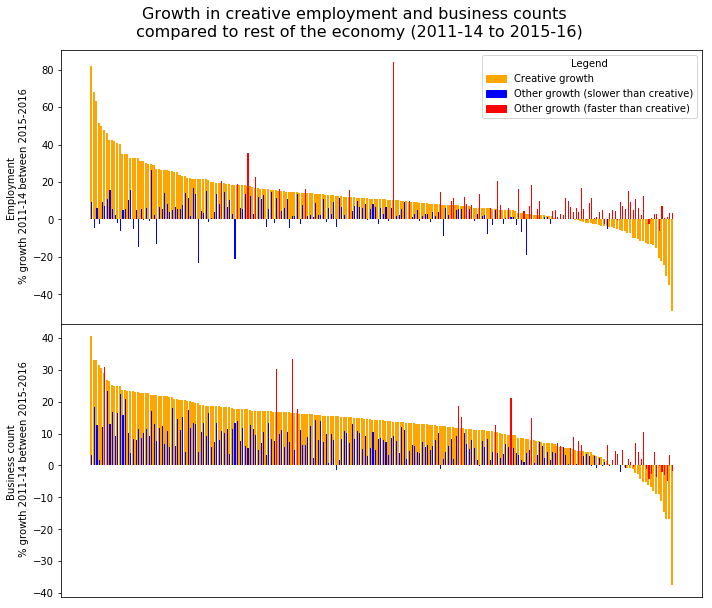

In [411]:
#Create a simpler chart than the one below. Sorted barchart with colours for regions and some extra info
#comparing with all economy performance

#Sort both data

growth_comp,growth_bc = [x.sort_values('creative_growth',ascending=False) for x in [growth_comp,growth_bc]]

#Initialise
fig, ax = plt.subplots(nrows=2,figsize=(10,8),sharex=True)

#Plot employment
for location in np.arange(len(growth_comp)):
    ax[0].bar(location,height=100*growth_comp.iloc[location]['creative_growth']-100,bottom=0,
              #color=regions_colors[ttwa_region_lookup[growth_comp.index[location]]],width=1,
              color='orange',
              #edgecolor='white',
              linewidth=0.8)


    ax[0].bar(location+0.3,height=100*growth_comp.iloc[location]['other_growth']-100,bottom=0,
              #color=regions_colors[ttwa_region_lookup[growth_comp.index[location]]],width=1,
              
              #color='white',
              color='blue' if growth_comp.iloc[
                  location]['creative_growth']> growth_comp.iloc[location]['other_growth'] else 'red',
              
              width=0.4,
              edgecolor='grey',
              linewidth=0.01)
    
#ax[0].set_facecolor('darkslategrey')
#ax[0].plot(np.arange(len(growth_comp)),growth_comp['other_growth']-1,color='white',linewidth=0.9)

ax[0].set_ylabel('Employment \n % growth 2011-14 between 2015-2016')


for location in np.arange(len(growth_bc)):
    ax[1].bar(location,height=100*growth_bc.iloc[location]['creative_growth']-100,bottom=0,
              #color=regions_colors[ttwa_region_lookup[growth_bc.index[location]]],width=1,
              #edgecolor='white',
              color='orange',
              linewidth=0.8
             )
    ax[1].bar(location+0.3,height=100*growth_bc.iloc[location]['other_growth']-100,bottom=0,
              #color=regions_colors[ttwa_region_lookup[growth_comp.index[location]]],width=1,
              color='blue' if growth_bc.iloc[
                  location]['creative_growth']> growth_bc.iloc[location]['other_growth'] else 'red',
              
              #color='white',
              width=0.4,
              edgecolor='grey',
              linewidth=0.01)

ax[1].set_xticklabels(['' for x in ax[1].get_yticklabels()])
ax[1].set_xticklabels(['' for x in ax[1].get_yticklabels()])

ax[1].set_ylabel('Business count \n % growth 2011-14 between 2015-2016')


patches = [ mpatches.Patch(color=c, 
                           label=i) for c,i in zip(['orange','blue','red'],['Creative growth',
                                                                           'Other growth (slower than creative)',
                                                                           'Other growth (faster than creative)'])]

ax[1].legend(handles=patches,
             bbox_to_anchor=(1,2),
             title='Legend')



plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.tick_params(axis='x',bottom='off')



fig.suptitle(
    'Growth in creative employment and business counts \n compared to rest of the economy (2011-14 to 2015-16)',y=1.05,fontsize=16)

plt.savefig(fig_path+'/{date}_growth_figure_simplified.pdf'.format(date=today_str),bbox_inches='tight')


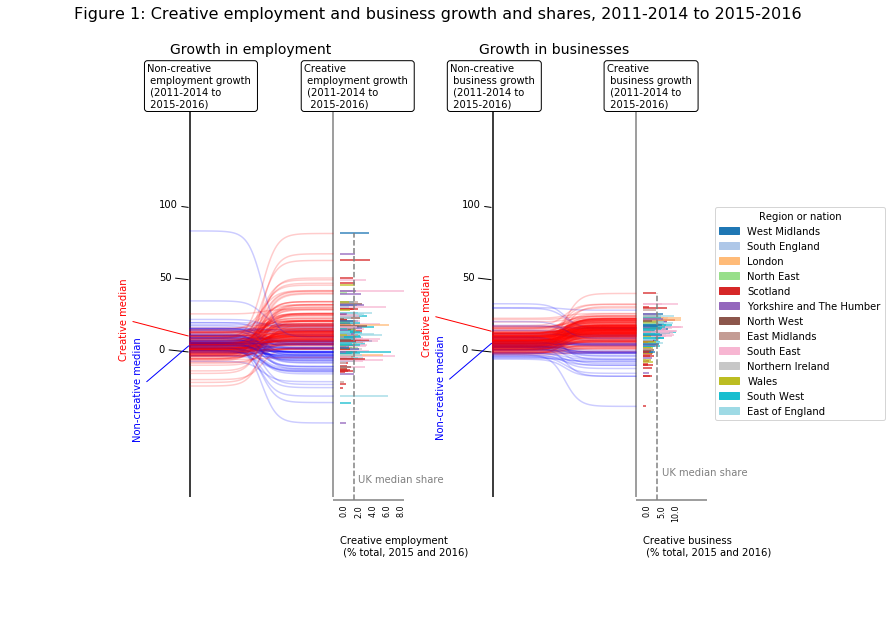

In [298]:
#Initial plot

fig,ax = plt.subplots(figsize=(10,8),ncols=2)

for place in growth_comp.index:
    
    data = list(growth_comp.loc[place,['other_growth','creative_growth','emp_share']])
    
    x_var = np.arange(-10,10,0.2)
    y_var = sigmoid(x_var)
    
    
    ax[0].plot(rescale(x_var),descale(y_var,data[0],data[1]),alpha=0.2,
            color='red' if data[1]>data[0] else 'blue')
    
    
    #ax[0].plot([0,1],[data[0],data[1]],alpha=0.2,
    #        #color=(data[1]-data[2]))
    #        color='red' if data[1]>data[0] else 'blue')
    
    ax[0].hlines(y=data[1],xmin=1.05,xmax=1.05+data[2]*5,edgecolor=regions_colors[ttwa_region_lookup[place]],
             alpha=0.9)
    
#Limits
ax[0].set_xlim(-1,1.5)
ax[0].set_ylim(-0.6,2.7)
ax[0].axis('off')    
    
#Vertical lines for axis
ax[0].vlines(x=0,ymax=3,ymin=0,color='black')
ax[0].vlines(x=1,ymax=3,ymin=0,color='grey')

#Y range
y_range = np.arange(np.round(growth_comp['creative_growth'].min()),np.ceil(growth_comp['creative_growth'].max())+0.5,0.5)

#Add  y labels (NB we are rescaling to no growth = 0)
for y in y_range:
    ax[0].annotate(s=int(100*y-100),xy=(0,y),xytext=(-0.22,y),arrowprops={'arrowstyle':'-','color':'black'})

#Lots of annotations for labels etc
ax[0].annotate(s='Non-creative median',
            xy=(0,np.median(growth_comp['other_growth'])),xytext=(-0.4,np.median(growth_comp['other_growth'])),
            color='blue',arrowprops={'arrowstyle':'-','color':'blue'},rotation=90)

ax[0].annotate(s='Non-creative \n employment growth \n (2011-2014 to \n 2015-2016)',
            xy=(-0.3,2.7),bbox={'boxstyle':'round','fc':'white'})

ax[0].annotate(s='Creative \n employment growth \n (2011-2014 to \n  2015-2016)',
            xy=(0.8,2.7),bbox={'boxstyle':'round','fc':'white'})

ax[0].annotate(s='Creative median',
            xy=(0,np.median(growth_comp['creative_growth'])),xytext=(-0.5,np.median(growth_comp['creative_growth'])+0.35),
            color='red',arrowprops={'arrowstyle':'-','color':'red'},rotation=90)

#Add the employment shares axis
ax[0].hlines(y=-0.02,xmin=1,xmax=10.5+growth_comp['emp_share'].max()*5,color='grey')

size_range = np.arange(1.05,1.05+growth_comp['emp_share'].max()*5,0.1)

for x in size_range:
    #print(x)
    #print(str(x/5))
    ax[0].annotate(str(100*(x-1.05)/5),xy=(x,-0.1),size=8,rotation=90)
    
#Add median share and annotate
ax[0].vlines(x=1.05+growth_comp['emp_share'].median()*5,ymin=-0.02,ymax=growth_comp['creative_growth'].max(),
            color='grey',linestyle='--')

#
ax[0].annotate(s='UK median share',xy=(1.08+growth_comp['emp_share'].median()*5,0.1),size=10,color='grey')


#Titles...
ax[0].annotate(s='Creative employment \n (% total, 2015 and 2016)',xy=(1.05,-0.4),size=10)

ax[0].set_title('Growth in employment',y=1.1,x=0.57,fontsize=14)


patches = [ mpatches.Patch(color=
                           regions_colors[i], 
                           label=i) for i in regions]

#Business plot

for place in growth_bc.index:
    
    data = list(growth_bc.loc[place,['other_growth','creative_growth','bc_share']])

    x_var = np.arange(-10,10,0.2)
    y_var = sigmoid(x_var)
    
    
    ax[1].plot(rescale(x_var),descale(y_var,data[0],data[1]),alpha=0.2,
            color='red' if data[1]>data[0] else 'blue')
    
    
    
    #ax[1].plot([0,1],[data[0],data[1]],alpha=0.2,
    #        #color=(data[1]-data[2]))
    #        color='red' if data[1]>data[0] else 'blue')
    
    ax[1].hlines(y=data[1],xmin=1.05,xmax=1.05+data[2]*2,edgecolor=regions_colors[ttwa_region_lookup[place]],
             alpha=0.9)
    
#Limits
ax[1].set_xlim(-1,1.5)
ax[1].set_ylim(-0.6,2.7)
ax[1].axis('off')    
    
#Vertical lines for axis
ax[1].vlines(x=0,ymax=3,ymin=0,color='black')
ax[1].vlines(x=1,ymax=3,ymin=0,color='grey')

#Y range
y_range = np.arange(np.round(growth_bc['creative_growth'].min()),np.ceil(growth_bc['creative_growth'].max())+0.5,0.5)

#Add y labels (NB we are rescaling to no growth = 0)
for y in y_range:
    ax[1].annotate(s=int(100*y-100),xy=(0,y),xytext=(-0.22,y),arrowprops={'arrowstyle':'-','color':'black'})

#Lots of annotations for labels etc
ax[1].annotate(s='Non-creative median',
            xy=(0,np.median(growth_bc['other_growth'])),xytext=(-0.4,np.median(growth_bc['other_growth'])),
            color='blue',arrowprops={'arrowstyle':'-','color':'blue'},rotation=90)

ax[1].annotate(s='Non-creative \n business growth \n (2011-2014 to \n 2015-2016)',
            xy=(-0.3,2.7),bbox={'boxstyle':'round','fc':'white'})

ax[1].annotate(s='Creative \n business growth \n (2011-2014 to \n 2015-2016)',
            xy=(0.8,2.7),bbox={'boxstyle':'round','fc':'white'})

ax[1].annotate(s='Creative median',
            xy=(0,np.median(growth_bc['creative_growth'])),xytext=(-0.5,np.median(growth_bc['creative_growth'])+0.35),
            color='red',arrowprops={'arrowstyle':'-','color':'red'},rotation=90)

#Add the employment shares axis
ax[1].hlines(y=-0.02,xmin=1,xmax=10.5+growth_bc['bc_share'].max()*2,color='grey')

size_range = np.arange(1.05,1.05+growth_bc['bc_share'].max()*2,0.1)

for x in size_range:
    ax[1].annotate(str(100*(x-1.05)/2),xy=(x,-0.1),size=8,rotation=90)

ax[1].annotate(s='Creative business \n (% total, 2015 and 2016)',xy=(1.05,-0.4),size=10)

ax[1].set_title('Growth in businesses',y=1.1,x=0.57,fontsize=14)


patches = [ mpatches.Patch(color=
                           regions_colors[i], 
                           label=i) for i in regions]

ax[1].legend(handles=patches,
             bbox_to_anchor=(1.01,0.8),
             title='Region or nation')

#Add median share and annotate
ax[1].vlines(x=1.05+growth_bc['bc_share'].median()*2,ymin=-0.02,ymax=growth_bc['creative_growth'].max(),
            color='grey',linestyle='--')

#
ax[1].annotate(s='UK median share',xy=(1.08+growth_bc['bc_share'].median()*2,0.15),size=10,color='grey')

#legend_2 = ax[1].legend(labels=['growth','no_growth'],bbox_to_anchor=(1.01,0.4))

#ax[1].add_artist(legend_1)
#ax[1].add_artist(legend_2)

plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=-0.15)
plt.suptitle('Figure 1: Creative employment and business growth and shares, 2011-2014 to 2015-2016',y=1.05,x=0.6,size=16)

patches_reg = [ mpatches.Patch(color=
                           regions_colors[i], 
                           label=i) for i in regions]

labels_reg = regions

plt.savefig(fig_path+'/{date_today}_figure_1_growth.pdf'.format(date_today=today_str),bbox_inches='tight')



In [414]:
#Extract colors
color_lookup = {x.get_label():x.get_facecolor() for x in patches_reg}
# Stats for the report

#### Stats for the report

In [84]:
#Median growth in creative vs other sectors

100*(growth_chart_emp.median()-1)

creative_growth    1.086278e+01
other_growth       5.257574e+00
creative_emp       8.715000e+04
other_emp          5.526650e+06
emp_share         -9.806823e+01
dtype: float64

In [85]:
#Median growth in business vs other sectors

100*(growth_chart_bc.median()-1)

creative_growth        14.187588
other_growth            7.039490
creative_bc         31150.000000
other_bc           568275.000000
bc_share              -94.906338
dtype: float64

In [86]:
# 
print(np.sum(growth_chart_emp.creative_growth >1)/len(growth_chart_emp))
print(np.sum(growth_chart_emp.creative_growth > growth_chart_emp.other_growth)/len(growth_chart_emp))

0.825892857143
0.678571428571


In [87]:
print(np.sum(growth_chart_bc.creative_growth >1)/len(growth_chart_bc))
print(np.sum(growth_chart_bc.creative_growth > growth_chart_bc.other_growth)/len(growth_chart_bc))

0.897321428571
0.830357142857


###  Regional TTWA growth boxplot

In [478]:
#Combine employment and business growth tables
growth_comp_bc = pd.concat([growth_comp['creative_growth'],
                           growth_bc['creative_growth']],axis=1)

growth_comp_bc.columns=['creative_emp_growth','creative_bc_growth']
growth_comp_bc = 100*growth_comp_bc-1

In [540]:
absolute_changes = all_changes.loc[
    all_changes.sector=='All creative industries',:].reset_index(drop=True).set_index('ttwa_name').dropna()

absolute_changes['emp_discr'] = pd.qcut(np.abs(absolute_changes.emp_total),q=10,labels=False)

In [594]:
regions_sorted

['West Midlands',
 'South England',
 'London',
 'North East',
 'Scotland',
 'Yorkshire and The Humber',
 'North West',
 'East Midlands',
 'South East',
 'Northern Ireland',
 'Wales',
 'South West',
 'East of England']

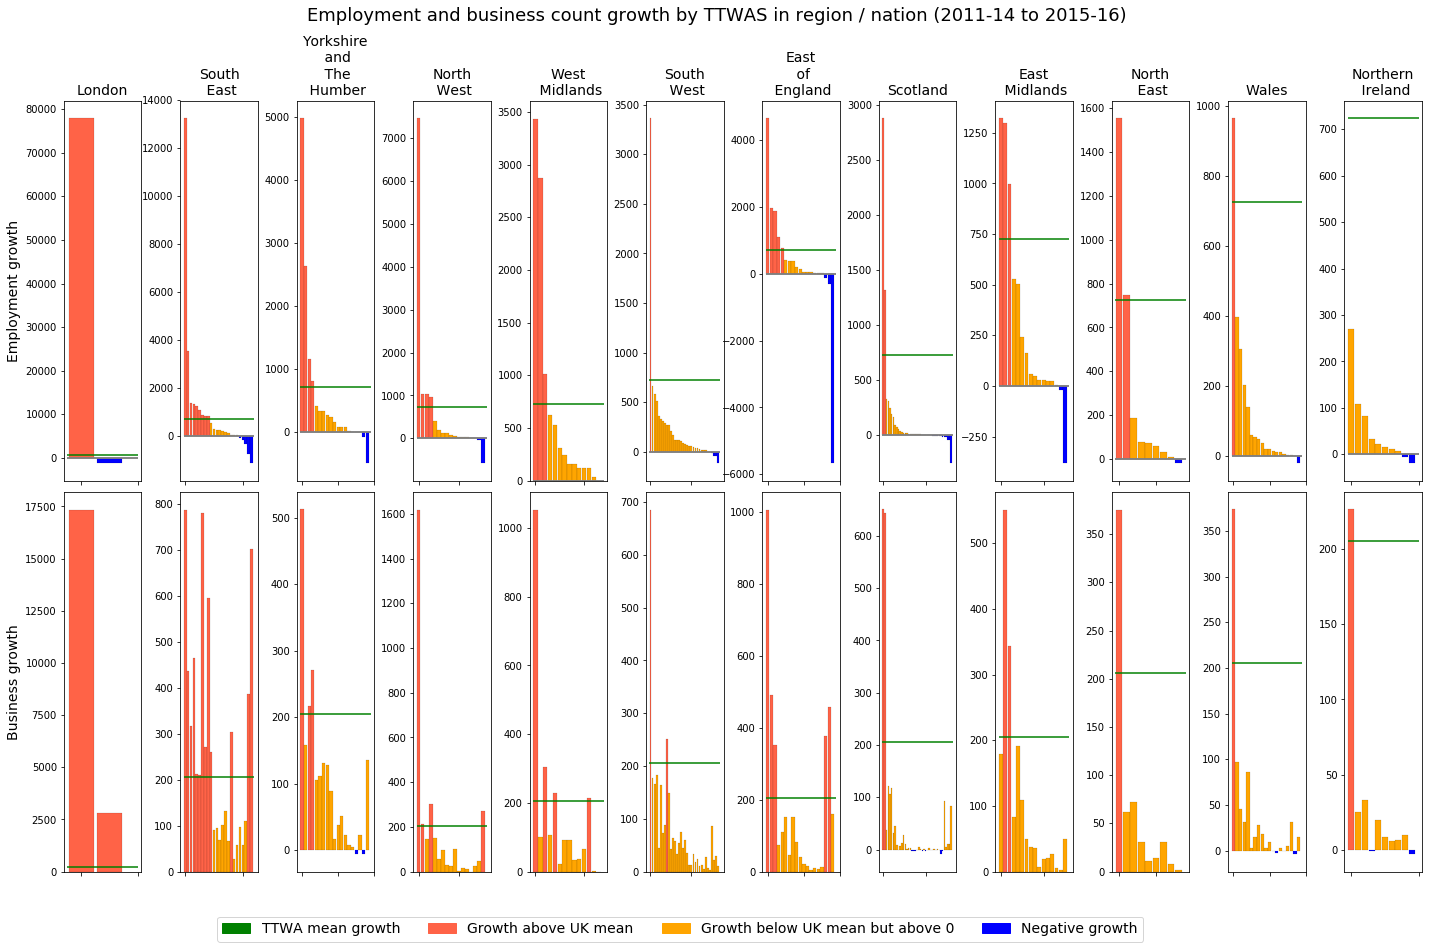

In [663]:
#Create a faceted chart with region performance scatters

#Each column is a region
fig,ax = plt.subplots(ncols=len(regions_sorted),nrows=2,figsize=(20,12),sharex='col',
                      #sharex=True
                     )

for num, region in enumerate([x for x in regions_sorted[::-1] if x!='South England']):
    #print(region)
    #Select TTWAs in region
    ttwas_in_region = [k for k,v in ttwa_region_lookup.items() if v==region and k in growth_comp_bc.index]
    
    #Subset the data
    reg_data = absolute_changes.loc[ttwas_in_region].sort_values('emp_total',ascending=False)
    
    for num_2,ttwa in enumerate(reg_data.index):
        if ttwa in reg_data.index:
            ax[0][num].bar(num_2,
                           reg_data.loc[ttwa]['emp_total'],
                           color='tomato' if reg_data.loc[ttwa]['emp_total']> np.mean(absolute_changes.emp_total) else
                           'orange' if reg_data.loc[ttwa]['emp_total']>0 else 'blue',
                          edgecolor='black',width=0.9,linewidth=0.1)

                
            ax[1][num].bar(num_2,
                           reg_data.loc[ttwa]['bc_total'],
                           color='tomato' if reg_data.loc[ttwa]['bc_total']> np.mean(absolute_changes.bc_total) else
                           'orange' if reg_data.loc[ttwa]['bc_total']>0 else 'blue',
                           edgecolor='black',width=0.9,linewidth=0.1)
                        #reg_data.loc[ttwa,'creative_emp_growth']-100,
   
   
    ax[0][num].hlines(y=0,xmin=-0.5,xmax=len(reg_data),color='grey')
    ax[0][num].hlines(y=np.mean(absolute_changes.emp_total),xmin=-0.5,xmax=len(reg_data),color='green')
    
                
    ax[0][num].hlines(y=0,xmin=-0.5,xmax=len(reg_data),color='grey')
    ax[1][num].hlines(y=np.mean(absolute_changes.bc_total),xmin=-0.5,xmax=len(reg_data),color='green')
                            
    
    ax[0][num].set_title("\n ".join(region.split(" ")),size=14)
    
    ax[1][num].set_xticklabels(['' for x in ax[1][num].get_yticklabels()])
    
ax[0][0].set_ylabel('Employment growth',size=14)
ax[1][0].set_ylabel('Business growth',size=14)


patch = [mpatches.Patch(color=x,label=var) for x,var in zip(['green','tomato','orange','blue'],
                                                            ['TTWA mean growth','Growth above UK mean',
                                                            'Growth below UK mean but above 0',
                                                            'Negative growth'])]
ax[1][6].legend(handles=patch,
                bbox_to_anchor=(5,-0.1),fontsize=14,ncol=4)

    
plt.tight_layout()
plt.subplots_adjust(hspace=0.03,wspace=0.5)

fig.suptitle('Employment and business count growth by TTWAS in region / nation (2011-14 to 2015-16)',y=1.02,size=18)

plt.savefig(fig_path+'/{date}_region_growth.pdf'.format(date=today_str),bbox_inches='tight')

### Employment and business boxplot

In [88]:
#Create shares df
share_boxplot = pd.concat([100*growth_chart_emp['emp_share'],100*growth_chart_bc['bc_share']],axis=1).dropna()
share_boxplot['region'] = [ttwa_region_lookup[x] for x in share_boxplot.index]

In [89]:
regions_sorted_box = share_boxplot.groupby('region')['emp_share'].median().sort_values(ascending=False).index

/usr/local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


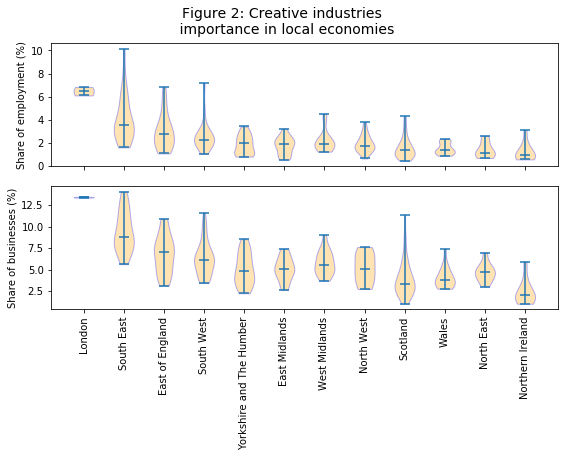

In [90]:
fig,ax = plt.subplots(nrows=2,figsize=(8,6),sharex=True)

emp_data = [share_boxplot.loc[share_boxplot.region==x,'emp_share'] for x in regions_sorted_box]
bc_data = [share_boxplot.loc[share_boxplot.region==x,'bc_share'] for x in regions_sorted_box]

vp_1 = ax[0].violinplot(emp_data,showmedians=True)
vp_2 = ax[1].violinplot(bc_data,showmedians=True)


ax[0].set_ylabel('Share of employment (%)')
ax[1].set_ylabel('Share of businesses (%)')


for x in [vp_1,vp_2]:
    for p in x['bodies']:
        p.set_facecolor('orange')
        p.set_edgecolor('blue')
    

ax[1].set_xticks([x+1 for x in np.arange(len(regions_sorted_box))])
ax[1].set_xticklabels(regions_sorted_box,rotation=90)

plt.tight_layout()

fig.suptitle('Figure 2: Creative industries \n importance in local economies',y=1.05,fontsize=14)

plt.savefig(fig_path+'/{date}_figure_2_violinplot.pdf'.format(date=today_str),bbox_inches='tight')


### b. Sizebands and regional productivity

Change in size distributions by region and productivity

Create chart that lines up 

```
sizebands 2016    % increase vs 2015              % comparison with non-creative           % Productivity

% large               % large                       share of c emps / share all emps      % vs companies in same sband
% medium              % medium                                ...
% small               % small                      Or share of all emps in segment?
% micro               % micro

Stacked barchart     non-stacked barchart (+ / -)        depends on what I do               
```

**Tasks**

Create this df:

```
region / sizeband / businesses 2016 / businesses 2015 / share 2016 / share 2015 / % difference / % absolute difference
% all businesses in same size / share vs share in other sectors.

and another df with:
region / sizeband / productivity vs sector (we will need to lay down the ys to fit the categories in the first sizeband

```





In [91]:
#Business counts per sizeband/ region

#Sizebands
#Add region names
idbr_sizebands['region'] = [ttwa_region_lookup[x] for x in idbr_sizebands['ttwa_name']]

#Sum over regions for creative & non-creative sectors
idbr_regions_sizeb = idbr_sizebands.loc[[x in ['creative_industries','not_in_sector'] for x in idbr_sizebands.sector],
                                        ['sector','sizeband','value','year','region']].groupby([
    'region','sector','sizeband','year'])['value'].sum().reset_index(drop=False)

#Calculate the share of sizeband in total business by year and secor 

#Pivot to put the years into columns
piv = pd.pivot_table(idbr_regions_sizeb,index=[x for x in idbr_regions_sizeb.columns if x not in['year','value']],
                                       columns='year',values='value').reset_index(drop=False)

#Extract the share. NB we zip a list of years for which we want the shares and years which we want to drop
#from the analysis
#NB we are converting the years to financial (rather than nominal)
piv['sizeband_share_2015'],piv['sizeband_share_2016']  = [get_share_over_variable(piv,x,drop=y,
                                                                                   grouper='sizeband') 
                                                          for x,y in zip([2016,2017],[2017,2016])]

#Growth in the share of a sizeband between years
piv['sizeband_share_growth'] = piv['sizeband_share_2016']/piv['sizeband_share_2015']

#Absolute growth in the sizeband
piv['sizeband_abs_growth'] = piv[2017]-piv[2016]

#Compare share in ci vs share out
piv_comp = pd.pivot_table(piv[['region','sector','sizeband','sizeband_share_2016']],
                          index=['region','sizeband'],
                          columns='sector',values='sizeband_share_2016')

#How do the creative - non creative sizeband shares compare?
piv_comp['c_v_non_c_share'] = piv_comp['creative_industries']/piv_comp['not_in_sector']

piv_all = pd.concat([piv.loc[piv.sector=='creative_industries',:].set_index(['region','sizeband']),piv_comp],axis=1)

piv_final = piv_all.reset_index(drop=False)[['region','sizeband','sizeband_share_2016',
                                             'sizeband_share_growth','sizeband_abs_growth',
                                             'c_v_non_c_share']]
piv_final.fillna(1,inplace=True)

#Here is the thing
piv_final.head()

,region,sizeband,sizeband_share_2016,sizeband_share_growth,sizeband_abs_growth,c_v_non_c_share
0,East Midlands,Large (250+),0.000000,1.000000,0,0.000000
1,East Midlands,Medium-sized (50 to 249),0.004655,1.144120,10,0.195832
2,East Midlands,Micro (0 to 9),0.945832,0.999608,710,1.123473
3,East Midlands,Small (10 to 49),0.049513,0.995668,35,0.374709
4,East of England,Large (250+),0.000201,0.966432,0,0.124937


In [92]:
sizeband_names_lookup = {x:x.split(" ")[0].lower() for x in set(piv_final.sizeband)}

piv_final['size_short'] = [sizeband_names_lookup[x] for x in piv_final.sizeband]

sizes_sorted = ['micro','small','medium-sized','large']

piv_final.head()

,region,sizeband,sizeband_share_2016,sizeband_share_growth,sizeband_abs_growth,c_v_non_c_share,size_short
0,East Midlands,Large (250+),0.000000,1.000000,0,0.000000,large
1,East Midlands,Medium-sized (50 to 249),0.004655,1.144120,10,0.195832,medium-sized
2,East Midlands,Micro (0 to 9),0.945832,0.999608,710,1.123473,micro
3,East Midlands,Small (10 to 49),0.049513,0.995668,35,0.374709,small
4,East of England,Large (250+),0.000201,0.966432,0,0.124937,large


In [93]:
#Also transform productivities

gva_pivoted = pd.pivot_table(gva,index=['Region','Employment size band'],
                          columns='Industry',values='GVA per employee').reset_index(drop=False)
gva_pivoted['comp_prod'] = gva_pivoted['Creative']/ gva_pivoted['Other or unknown']

#Rename Yorkshire...
gva_pivoted['Region'] = [x if x.split(" ")[0]!='Yorkshire' else 'Yorkshire and The Humber' for x in gva_pivoted['Region']]

accent_colors = plt.cm.get_cmap('Dark2').colors[:4]


In [94]:
ypos = [0.2,0.4,0.6,0.8]
ypositions_gva = [0.2,0.6]

In [120]:
import squarify
from matplotlib import patches


def plot_sizebands(region,ax,
                   
                   #Parameters for normal charts
                   colors=accent_colors,
                   df=piv_final,
                   sizepos=ypos,
                   
                   #Parameters for GVA
                   ypos_gva=ypositions_gva,
                   colors_gva=[accent_colors[0],'steelblue'],
                   gva_df = gva_pivoted,
                   
                   #Labelling
                   xlabels=False):
    '''
    This function returns a bunch of plots about a region sizebands
    
    '''
    
    #Select data and sort
    reg_data = df.loc[df.region==region,:].set_index('size_short').loc[
        sizes_sorted,:].reset_index(drop=False)
    
    #Create squares
    rects = squarify.squarify([x for x in reg_data.sizeband_share_2016 if x>0],0,0,1,1)
    
    #Draw a treemap with the shares
    for num_size,x in enumerate(rects):
        ax[0].add_patch(
            patches.Rectangle((rects[num_size]['x'],
                               rects[num_size]['y']),
                              rects[num_size]['dx'],
                              rects[num_size]['dy'],facecolor=colors[num_size],
                             edgecolor='white'))
    
    #Remove ticks and ticklabels
    #ax[0].xaxis.set_visible(False)
    
    ax[0].annotate(
        '{x}'.format(x="micro:\n"+
                     str(np.round(100*reg_data.sizeband_share_2016[0],1))+'%'),xy=(0.01,0.05),fontsize=16,color='white')
    
    
    ax[0].set_xticks([])
    ax[0].set_xticklabels([])
    ax[0].set_yticks([])
    ax[0].set_yticklabels([])

    #Set limits for Y
    ax[0].set_ylim((-0.05,1.05))
    
    
    #Name
    lab_name = " ".join([w if num!=2 else '\n'+w for num,w in enumerate(region.split(" "))])
    ax[0].set_ylabel(lab_name)

    
    #Loop through the sizebands for the other charts
    for num_2 in np.arange(len(reg_data)):
        
        #Extract values
        values = list(reg_data.iloc[num_2,[3,4,5,6]])
        
        #Draw the line chart
        change = 100*values[1]

        #Choose the location of the y axis = mean of bottom and top of the bar
        yp = sizepos[num_2]

        #Set limits for axes in the second one
        #ax[1].set_xlim((reg_data['sizeband_share_growth'].min()-1-0.2,
        #                reg_data['sizeband_share_growth'].max()-1+0.2))

        #Set limits of y axes
        ax[1].set_ylim((-0.1,1.1))

        #Draw line
        ax[1].plot([0,change-100],[yp,yp],
                   color=colors[num_2])

        #print(values[2])

        #Draw markets (another scatter!)
        ax[1].scatter(x=change-100,y=yp,
                      s=20*np.log(np.abs(values[2]+0.000001)),
                      #1000,
                      alpha=0.4,
                      edgecolor='red' if values[2]>0 else ['blue'],
                      color=colors[num_2])

        #More play with axes etc
        ax[1].set_yticks([])

        ax[1].vlines(x=0,ymin=0,ymax=1,linestyle=':',linewidth=0.6)

        ax[1].yaxis.set_visible(False)
        
        #Reset bottom
        #bot=bot+share

        #Rest of economy
        ax[2].set_ylim((-0.1,1.1))
        ax[2].set_xlim((100*reg_data['c_v_non_c_share'].min()-10,
                        100*reg_data['c_v_non_c_share'].max()+10))


        ax[2].set_yticks([])


        vs_other = 100*values[3]

        ax[2].plot([0,vs_other],[yp,yp],
                   color=colors[num_2])
        ax[2].vlines(x=100,ymin=0,ymax=1,linestyle=':',linewidth=0.6)
        
        #Also extract mean size shares for UK
    
    #This extracts the UK mean for comparison
    for num,x in enumerate(sizes_sorted):
        uk_mean = 100*df.loc[df.size_short==x,'c_v_non_c_share'].mean()
        #print(uk_mean)
        ax[2].scatter(x=uk_mean,y=ypos[num],
                      #ymax=0.1,linestyle='-',linewidth=1.5,
                      color='darkgrey',s=15,marker='s',facecolors='none')
        
    
    #And finally... the productivities!
    #Calculate mean productivities 

    gva_means = list(gva_df.groupby('Employment size band')['Creative'].mean())
    gva_comp_means = list(100*gva_df.groupby('Employment size band')['comp_prod'].mean())

    #Extract the regional productivity
    reg_gva = gva_pivoted.loc[gva_pivoted.Region==region,:]
    
    #Go through the two sizebands we have 
    for num_3,emp in enumerate(set(reg_gva['Employment size band'])):
        
        #Extract the comparative and absolute GVA values
        
        gva_comp = 100*reg_gva.iloc[num_3,:]['comp_prod']
        gva_abs = reg_gva.iloc[num_3,:]['Creative']
        
        
        #Plot lines
        ax[3].plot([0,gva_comp],[ypos_gva[num_3],ypos_gva[num_3]],c=colors_gva[num_3])
        
        #Plot circles (including the actual value and the mean)
        ax[3].scatter(x=gva_comp,y=ypos_gva[num_3],s=gva_abs,alpha=0.8,c=colors_gva[num_3])
        
        ax[3].scatter(x=gva_comp_means[num_3],y=ypos_gva[num_3],s=gva_means[num_3],
                      facecolors='none',edgecolor='darkgrey')
        
    ax[3].set_ylim((-0.1,1.1))
    
    ax[3].vlines(x=100,ymin=0,ymax=1,linestyle=':',linewidth=0.6)
    
    
    #Some label gubbins at the end
    ax[1].yaxis.set_visible(False)
    ax[2].yaxis.set_visible(False)
    ax[3].yaxis.set_visible(False)
    
    if xlabels!=False:
        ax[0].set_xlabel('Sizeband as \n share of total',size=9)
        ax[1].set_xlabel('Growth in sizeband \n (% and total)',size=9)
        ax[2].set_xlabel('Importance of sizeband \n (vs other sectors)',size=9)
        ax[3].set_xlabel('GVA per worker \n (vs other sectors)',size=9)


In [247]:
regions_sorted_no_ni = [x for x in regions_sorted if x!='Northern Ireland']

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


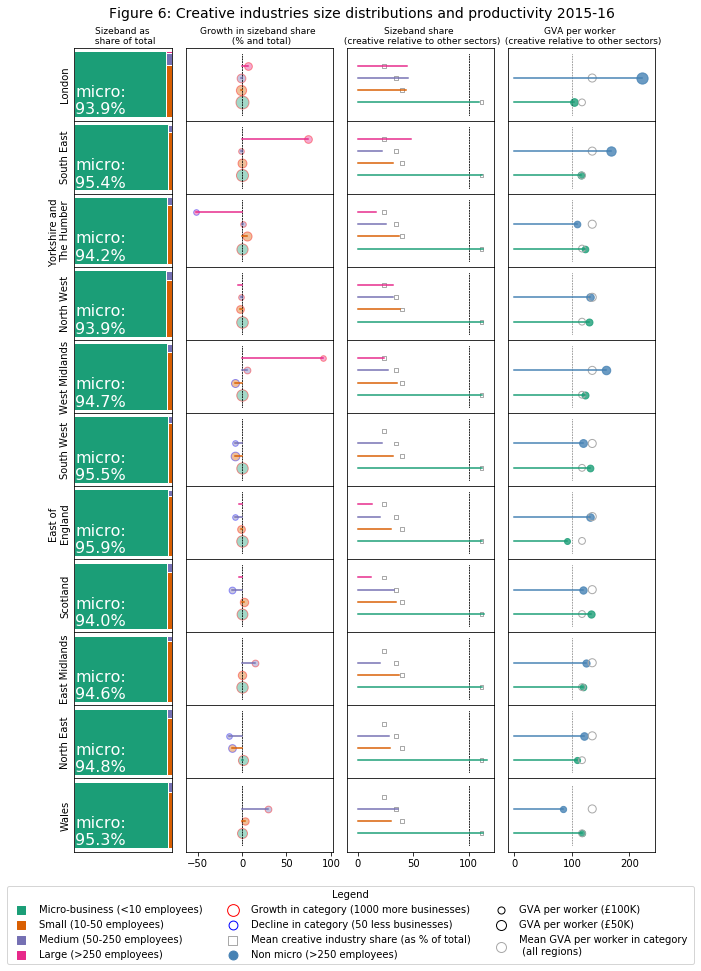

In [139]:
fig,ax = plt.subplots(figsize=(9,12),nrows=len(regions_sorted_no_ni),ncols=4,sharex='col',
                     gridspec_kw={'width_ratios':[2,3,3,3]}
                     )

#regions_sorted_no_ni = regions_sorted.remove('Northern Ireland')

for num,x in enumerate(reversed(regions_sorted_no_ni)):
    plot_sizebands(x,ax[num])
    
    #Remove titles and axes for all charts except the last one
    
ax[0][0].set_xlabel('Sizeband as \n share of total',size=9)
ax[0][1].set_xlabel('Growth in sizeband share \n (% and total)',size=9)
ax[0][2].set_xlabel('Sizeband share \n (creative relative to other sectors)',size=9)
ax[0][3].set_xlabel('GVA per worker \n (creative relative to other sectors)',size=9)


for x in np.arange(0,4):
    ax[0][x].xaxis.set_label_position('top')

plt.tight_layout()
plt.subplots_adjust(wspace=0.1,hspace=0)


#Add custom legend with some invisible scatters
#Sizez
mic = plt.scatter([],[], s=80, marker='s',color=accent_colors[0])
sm = plt.scatter([],[], s=80, marker='s',color=accent_colors[1])
med = plt.scatter([],[], s=80, marker='s',color=accent_colors[2])
lar = plt.scatter([],[], s=80, marker='s',color=accent_colors[3])

#Growth and decline
size_gr = plt.scatter([],[], s=20*np.log(1000), marker='o',color='white',edgecolor='red') 
size_decl = plt.scatter([],[], s=20*np.log(50), marker='o',color='white',edgecolor='blue') 

#Size shares
avg_share = plt.scatter([],[],s=80, marker='s',facecolors='none',color='darkgrey')

#Productivities
non_micro = plt.scatter([],[],s=80, marker='o',color='steelblue')
gva_pw_1 = plt.scatter([],[],s=50, marker='o',color='black',facecolors='white')
gva_pw_2 = plt.scatter([],[],s=100, marker='o',color='black',facecolors='white')
avg_size = plt.scatter([],[],s=100, marker='o',color='darkgrey',facecolors='white')




empty = plt.scatter([],[],s=80, marker='o',color='white',edgecolor='white')


circles_h, circles_l = ax[len(regions_sorted_no_ni)-1][1].get_legend_handles_labels()

#ax[len(regions_sorted)-1][1].legend()


#ng = plt.scatter([],[], s=150, marker='o',color='blue',edgecolor='black',alpha=0.5)

    #Add legend
plt.legend((mic,sm,med,lar,
            size_gr,size_decl,avg_share,non_micro,gva_pw_1,gva_pw_2,avg_size),
           ('Micro-business (<10 employees)', 
            'Small (10-50 employees)', 
            'Medium (50-250 employees)',
            'Large (>250 employees)',
            'Growth in category (1000 more businesses)',
            'Decline in category (50 less businesses)',
            'Mean creative industry share (as % of total)',
            'Non micro (>250 employees)',
            'GVA per worker (£100K)',
            'GVA per worker (£50K)',
            'Mean GVA per worker in category \n (all regions)',),
           scatterpoints=1,
           title='Legend',
           bbox_to_anchor=(1.3,-0.4),ncol=3,fontsize=10)  



fig.suptitle('Figure 6: Creative industries size distributions and productivity 2015-16',y=1.01,fontsize=14)

plt.savefig(fig_path+'/{date}_figure_6_size_prod.pdf'.format(date=today_str),bbox_inches='tight')


### Chart about impact on productivity of changes in company shares


Create a df with the following structure

```
region | Total GVA | Creative GVA | Creative micro share | Creative micro GVA pw | Creative non m share |
    Creative non m GVA pw 

```

We will process it with a function to generate estimates of change in GVA and GVA per worker

In [140]:
#Create processed DF
gva_2 = gva.copy()
gva_2.columns = ['region','sizeband','gva','employment','business_count','gva_pw','sector','n','period']

gva_2.sizeband = ['micro' if '0-9'in x else 'non_micro' for x in gva_2.sizeband]

#Calculate region totals
region_totals= gva_2.groupby('region')['employment','gva'].sum().reset_index(drop=False)

#Calculate creative region totals
creative_region_totals= gva_2.groupby(['region','sector','sizeband'])['employment','gva','gva_pw'].sum().reset_index(
    drop=False)

#There
creative_region_totals = creative_region_totals.loc[creative_region_totals.sector=='Creative',:]

#Pivot
creative_wide = pd.pivot_table(
    creative_region_totals,index='region',columns=['sizeband'],values=['gva','employment','gva_pw'])

#Change columns into a single index
creative_wide.columns = ['cr_'+x[0]+"_"+x[1] for x in creative_wide.columns]

creative_wide.reset_index(drop=False,inplace=True)

#Combine everything
prod_stats = pd.merge(region_totals,creative_wide,left_on='region',right_on='region')

#Shares
#prod_stats['cr']
prod_stats['cr_employment_micro_share'],prod_stats[
    'cr_employment_non_micro_share'] = [prod_stats[x]/prod_stats['employment'] for x in ['cr_employment_micro',
                                                                                 'cr_employment_non_micro']]

prod_stats['cr_gva_micro_share'],prod_stats[
    'cr_gva_non_micro_share'] = [prod_stats[x]/prod_stats['gva'] for x in ['cr_gva_micro',
                                                                                 'cr_gva_non_micro']]

prod_stats['gva_pw']=prod_stats['gva']/prod_stats['employment']

prod_stats.set_index('region',inplace=True)

In [141]:
prod_stats.head()

,employment,gva,cr_employment_micro,cr_employment_non_micro,cr_gva_micro,cr_gva_non_micro,cr_gva_pw_micro,cr_gva_pw_non_micro,cr_employment_micro_share,cr_employment_non_micro_share,cr_gva_micro_share,cr_gva_non_micro_share,gva_pw
region,,,,,,,,,,,,,
East Midlands,4491380,185053050,59950,79520,2612720,4174360,44,52,0.013348,0.017705,0.014119,0.022558,41.201824
East of England,2154930,91878740,42620,57710,1515670,3336270,36,58,0.019778,0.026780,0.016496,0.036312,42.636531
London,13503310,838449070,381600,945780,22996710,119409380,60,126,0.028260,0.070041,0.027428,0.142417,62.092114
North East,2017590,91539730,22490,29730,859290,1730480,38,58,0.011147,0.014735,0.009387,0.018904,45.370829
North West,6747420,291748550,76610,145290,3738600,8435700,49,58,0.011354,0.021533,0.012814,0.028914,43.238534


In [142]:
def var_changes(factors,size,name=None):
    '''
    This function modifies the levels of employment and/or productivity in a type of creative
    business (based on size) and returns uplifts in GVA (also as rates) and uplifts in GVA per worker (also as rates)
    
    '''
    
    #Increases number of jobs and GVA based on the scale factors
    jobs_uplifted = prod_stats['cr_employment_{size}'.format(size=size)]*factors[0]
    
    gva_p_w_uplifted = prod_stats['cr_gva_pw_{size}'.format(size=size)]*factors[1]
    
    #Increase in GVA equals GVA due to scale up minus old GVA
    gva_uplift = jobs_uplifted*gva_p_w_uplifted  - prod_stats[
        'cr_employment_{size}'.format(size=size)]* prod_stats['cr_gva_pw_{size}'.format(size=size)]
    
    #Final GVA equals increase in GVA plus original GVA
    total_gva_uplifted = gva_uplift+ prod_stats['gva']
    
    #Similar thing with employment
    employment_uplift = jobs_uplifted - prod_stats['cr_employment_{size}'.format(size=size)]
    
    #Final new employments
    total_jobs_uplifted = employment_uplift + prod_stats['employment']
    
    #Create the output DF
    estimate_df = pd.DataFrame({
        'gva_uplift':gva_uplift,
        'employment_uplift':employment_uplift})
    
    #Give it an index
    estimate_df.index= prod_stats.index
    
    return(estimate_df)
    
    

In [143]:
#Scenario 1:
#Employment expansion
only_micro_expansion = var_changes([1.1,1],'micro')
non_micro_expansion = var_changes([1.1,1],'non_micro')
all_expansion = only_micro_expansion+non_micro_expansion

#Scenario 2:
#Productivity expansion
only_micro_prod = var_changes([1,1.1],'micro')
non_micro_prod = var_changes([1,1.1],'non_micro')
all_prod = only_micro_prod+non_micro_prod

#Scenario 3:
#Joint expansion
only_micro_expansion_scale = var_changes([1.1,1.1],'micro')
non_micro_expansion_scale = var_changes([1.1,1.1],'non_micro')
all_expansion_prod = only_micro_expansion_scale+non_micro_expansion_scale

In [144]:
def extract_growth_stats(df,name):
    '''
    This function takes a growth estimate df like those above and returns one with
    the variables we want to plot: New GVA, new GVA per worker, their increase rate.
    
    '''
    
    #GVA per worker
    gva_pw = (df['gva_uplift']+prod_stats['gva'])/(df['employment_uplift']+prod_stats['employment'])
    gva_pw_rate = gva_pw/prod_stats['gva_pw']
    
    #GVA
    gva_up = df['gva_uplift']    
    gva_up_rate = (df['gva_uplift']+prod_stats['gva'])/ prod_stats['gva']
    
    #Columns names 
    col_names = [name+'_'+x for x in ['gva_pw','gva_pw_rate','gva_up','gva_up_rate']]
    
    out_df = pd.concat([gva_pw,gva_pw_rate,gva_up,gva_up_rate],axis=1)
    out_df.columns= col_names
    
    return(out_df)

In [145]:
#Create the figure doing a list comprehension
figure_chart = pd.concat([
    extract_growth_stats(x,name) for x,name in zip([only_micro_expansion,non_micro_expansion,all_expansion,
                                                   only_micro_prod,non_micro_prod,all_prod,
                                                    only_micro_expansion_scale,non_micro_expansion_scale,
                                                    all_expansion_prod],
                                                   ['micro_expand','non_micro_expand','all_expand',
                                                   'micro_prod','non_micro_prod','all_prod',
                                                   'micro_expand_prod','non_micro_expand_prod',
                                                   'all_expand_prod'])],axis=1)

figure_chart.head()

,micro_expand_gva_pw,micro_expand_gva_pw_rate,micro_expand_gva_up,micro_expand_gva_up_rate,non_micro_expand_gva_pw,non_micro_expand_gva_pw_rate,non_micro_expand_gva_up,non_micro_expand_gva_up_rate,all_expand_gva_pw,all_expand_gva_pw_rate,...,micro_expand_prod_gva_up,micro_expand_prod_gva_up_rate,non_micro_expand_prod_gva_pw,non_micro_expand_prod_gva_pw_rate,non_micro_expand_prod_gva_up,non_micro_expand_prod_gva_up_rate,all_expand_prod_gva_pw,all_expand_prod_gva_pw_rate,all_expand_prod_gva_up,all_expand_prod_gva_up_rate
region,,,,,,,,,,,,,,,,,,,,,
East Midlands,41.205554,1.000091,263780.0,1.001425,41.220909,1.000463,413504.0,1.002235,41.224607,1.000553,...,553938.0,1.002993,41.322003,1.002917,868358.4,1.004692,41.389969,1.004566,1422296.4,1.007686
East of England,42.623431,0.999693,153432.0,1.001670,42.677565,1.000962,334718.0,1.003643,42.664420,1.000654,...,322207.2,1.003507,42.847968,1.004959,702907.8,1.007650,42.912445,1.006471,1025115.0,1.011157
London,62.086219,0.999905,2289600.0,1.002731,62.536616,1.007159,11916828.0,1.014213,62.529517,1.007044,...,4808160.0,1.005735,63.500627,1.022684,25025338.8,1.029847,63.675529,1.025501,29833498.8,1.035582
North East,45.362621,0.999819,85462.0,1.000934,45.389411,1.000410,172434.0,1.001884,45.381195,1.000228,...,179470.2,1.001961,45.483284,1.002479,362111.4,1.003956,45.521438,1.003320,541581.6,1.005916
North West,43.245068,1.000151,375389.0,1.001287,43.270251,1.000734,842682.0,1.002888,43.276735,1.000884,...,788316.9,1.002702,43.407335,1.003904,1769632.2,1.006066,43.474661,1.005461,2557949.1,1.008768


In [146]:
from itertools import product

In [147]:
#Test Chart

scenarios = ['micro_expand','non_micro_expand','all_expand',
             'micro_prod','non_micro_prod','all_prod',
             'micro_expand_prod','non_micro_expand_prod','all_expand_prod']
metrics = ['gva_pw_rate','gva_up_rate']

prod_vars_to_chart = list(product(scenarios,metrics))

prod_vars_to_chart = [x[0]+'_'+x[1]  for x in prod_vars_to_chart]


def plot_estimates(place,ax):
    '''
    This function charts growth estimates for different regions
    
    '''
    place_data = figure_chart.loc[place,prod_vars_to_chart]


    for number in np.arange(len(scenarios)):
        
        if number>=6:
            x_ax= number+4
        else:
            if number>=3:
                x_ax=number+2
            else:
                x_ax=number
        
        #x_ax = number + 1 if number%2==0 else number+2 if number %2==0 else number
        
        set_color = 'green' if 'all' in scenarios[number] else 'orange' if 'non_micro' in scenarios[number] else 'blue'
        #set_marker = '^' if 'expand_prod' in scenarios[number] else 's' if 'prod' in scenarios[number] else 'o'
        
        ax.bar(x_ax,height=100*place_data[scenarios[number]+'_gva_pw_rate']-100,color=set_color)
        
        #ax.plot([x_ax,x_ax],
        #        [0,100*place_data[scenarios[number]+'_gva_pw_rate']-100],color=set_color)
        #ax.scatter(x=x_ax,y=100*place_data[scenarios[number]+'_gva_pw_rate']-100,
        #           s=(place_data[scenarios[number]+'_gva_up_rate']-1)*10000,c=set_color,alpha=0.5,
        #          edgecolor='black',marker='s')
    
    ax.set_xlim((-1,len(scenarios)+4.5))
    ax.set_ylim(-0.1)
    
    #ax.hlines(y=0,xmin=-1,xmax=len(scenarios)+4.5,linewidth=0.5,linestyle='--')
    
    ax.set_xticks([1,6,11])
    ax.set_xticklabels(['Extensive growth','Intensive growth','Intensive and extensive'],rotation=90)

    
    #ax.set_yscale('log')


In [148]:
regions_sorted_prod = figure_chart['all_expand_prod_gva_pw_rate'].sort_values(ascending=False).index

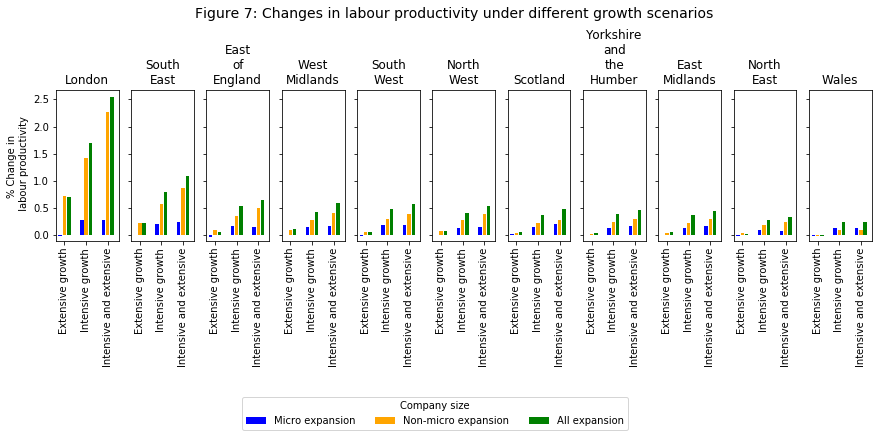

In [149]:
fig,ax = plt.subplots(figsize=(12,5),ncols=len(set(figure_chart.index)),
                      sharey=True
                     )

for num,place in enumerate(regions_sorted_prod):
    plot_estimates(place,ax[num])
    ax[num].set_title('\n'.join([x for x in place.split(" ")]))

fig.suptitle('Figure 7: Changes in labour productivity under different growth scenarios',y=1.03,fontsize=14)

plt.tight_layout()

ax[6].legend(['Micro expansion','Non-micro expansion','All expansion'],bbox_to_anchor=(2,-1),ncol=3,
            title='Company size')


ax[0].set_ylabel('% Change in \n labour productivity')

plt.subplots_adjust(wspace=0.2)

plt.savefig(fig_path+'/{date}_figure_7_productivity_expansion.pdf'.format(date=today_str),bbox_inches='tight')

### b. Concentration and growth

**Question**

* What TTWAs have grown and what TTWAs have declined? 
* Are the CIs becoming more or less concentrated? In what regions? In what sectors?



#### Choropleths

In [113]:
#Maps
#Remove from data those ttwas with missing values

#Merge with shapefile attributes for ordering
changes_ord = pd.merge(pd.DataFrame(attr.by_col['TTWA11CD'],columns=['TTWA11CD']),
                   ttwas_coded,left_on='TTWA11CD',right_on='ttwa_code',how='outer',sort=False)

#Create df with only complete TTWAS and remove those from the weights
changes_ord_completes = changes_ord[[str(x)!="nan" for x in changes_ord.ttwa_code]]
ttwas_w_data = list(changes_ord_completes.index)

#Subset weights to focus on available TTWAs, and normalise
wsub = pysal.w_subset(w,ttwas_w_data)
wsub.transform='r'


('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 166, ' is an island (no neighbors)')
('WARNING: ', 167, ' is an island (no neighbors)')
('WARNING: ', 168, ' is an island (no neighbors)')
('WARNING: ', 169, ' is an island (no neighbors)')


/usr/local/lib/python3.5/site-packages/pysal/weights/weights.py:189: UserWarning: There are 5 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/usr/local/lib/python3.5/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 9, 166, 167, 168, 169
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [163]:
#Ideas
#Simple analysis:

#For each sector and area:
    #Take their neighbors and extract their average growth and concentration (to draw a scatter)
    #Take the growth and concentration of their neighbours (to draw a heatmap)


#Lookup between shapefiles indices and TTWAs
ttwa_index_name_lookup = {x:y for x,y in zip(changes_ord_completes.index,changes_ord_completes.ttwa_name)}

#Dict with the neighbours for each area
neighbors_looked_up = {ttwa_index_name_lookup[x]:
                       [ttwa_index_name_lookup[item] for item in y] for x,y in wsub.neighbors.items()} 

#Some additional data processing to obtain the LQs by sector / area / year and their change

#empl_lqs = pd.pivot_table(pd.melt(pd.concat(
#    [empl_lqs_sectoral.dropna().set_index('year',append=True),
#     empl_lqs_subsectoral.dropna().set_index('year',append=True)],
#    axis=1).reset_index(drop=False),id_vars=['ttwa_name','year'],var_name='sector',value_name='emp_lq'),
#                          index=['ttwa_name','sector'],columns='year',values='emp_lq').reset_index(drop=False)

#NB this is a left merge which is ok (the sectoral TTWA has all the data)

empl_lqs = pd.pivot_table(pd.melt(
    pd.merge(empl_lqs_sectoral,
             empl_lqs_subsectoral,
             left_on=['year','ttwa_name'],
             right_on=['year','ttwa_name']),id_vars=['ttwa_name','year'],var_name='sector',value_name='emp_lq'),
                          index=['ttwa_name','sector'],columns='year',values='emp_lq').reset_index(drop=False)

empl_lqs.rename(columns={'2015_2016':'emp_lq_2015_2016','2011_2014':'emp_lq_2011_2014'},inplace=True)

empl_lqs['emp_lq_change'] = empl_lqs['emp_lq_2015_2016']/ empl_lqs['emp_lq_2011_2014']

In [167]:
#IDBR

#bc_lqs = pd.pivot_table(pd.melt(pd.concat(
#    [bc_lqs_sectoral.dropna().set_index('year',append=True),
#     bc_lqs_subsectoral.dropna().set_index('year',append=True)],
#    axis=1).reset_index(drop=False),
#                                id_vars=['ttwa_name','year'],var_name='sector',value_name='bc_lq'),
#                          index=['ttwa_name','sector'],columns='year',values='bc_lq').reset_index(drop=False)

#idbr_lqs.rename(columns={'2015_2016':'bc_lq_2015_2016','2011_2014':'bc_lq_2011_2014'},inplace=True)

#idbr_lqs['bc_lq_change'] = idbr_lqs['bc_lq_2015_2016']/ idbr_lqs['bc_lq_2011_2014']

bc_lqs = pd.pivot_table(pd.melt(
    pd.merge(bc_lqs_sectoral,
             bc_lqs_subsectoral,
             left_on=['year','ttwa_name'],
             right_on=['year','ttwa_name']),id_vars=['ttwa_name','year'],var_name='sector',value_name='bc_lq'),
                          index=['ttwa_name','sector'],columns='year',values='bc_lq').reset_index(drop=False)

bc_lqs.rename(columns={'2015_2016':'bc_lq_2015_2016','2011_2014':'bc_lq_2011_2014'},inplace=True)

bc_lqs['emp_lq_change'] = bc_lqs['bc_lq_2015_2016']/ bc_lqs['bc_lq_2011_2014']

industry,year,ttwa_name,Advertising and marketing,Architecture,"Design: product, graphic and fashion design","Film, TV, video, radio and photography","IT, software and computer services","Music, performing and visual arts",Publishing,not_creative
0,2011_2014,Aberdeen,0.271665,1.442507,0.536299,0.311943,0.491392,0.487237,0.488215,1.044558
1,2011_2014,Aberystwyth,0.361375,0.712176,0.267813,0.477526,0.292195,0.569572,1.780957,1.050306
2,2011_2014,Alness and Invergordon,0.387554,1.666400,NaN,0.307271,0.235022,0.349047,NaN,1.060926
3,2011_2014,Andover,0.899707,0.650317,1.000150,0.664136,1.172733,0.754431,0.825642,1.002789
4,2011_2014,Arbroath and Montrose,0.271196,1.311850,0.602946,0.358363,0.292373,0.183188,0.601439,1.055999
5,2011_2014,Ashford,1.092718,1.044103,0.899784,0.577573,0.867171,0.820124,1.121921,1.011650
6,2011_2014,Aviemore and Grantown-on-Spey,0.665973,NaN,NaN,0.792024,0.269241,0.337390,NaN,1.060855
7,2011_2014,Ayr,0.427814,0.837634,0.509544,0.339191,0.494164,0.577961,0.677695,1.044348
8,2011_2014,Ballymena,0.186542,0.501307,0.172806,0.246499,0.169685,0.168008,0.275799,1.072070
9,2011_2014,Banbury,1.194977,1.039865,1.054273,0.812088,0.927875,0.948123,0.757181,1.004346


In [173]:
#Combine LQ info
#NEED TO REVISIT AND TIDY READ IT

bc_lqs_subsectoral_long = pd.pivot_table(pd.melt(bc_lqs_subsectoral.reset_index(drop=False),
                                    id_vars=['ttwa_name','year'],var_name='sector'),index=['ttwa_name','sector'],
                                           columns='year',values='value').reset_index(drop=False)

bc_lqs_subsectoral_long.columns = ['ttwa_name','sector','bc_lq_2011_2014','bc_lq_2015_2016']

In [185]:
all_bc = pd.merge(bc_lqs,
                  bc_totals.loc[bc_totals.year=='2015_2016',
                                    ['industry','ttwa_name','business_count']],
                  left_on=['ttwa_name','sector'],
                  right_on=['ttwa_name','industry'])

year,ttwa_name,sector,bc_lq_2011_2014,bc_lq_2015_2016,emp_lq_change
0,Aberdeen,Advertising and marketing,0.271665,0.279145,1.027534
1,Aberdeen,All creative industries,0.507758,0.454761,0.895626
2,Aberdeen,Architecture,1.442507,1.221170,0.846561
3,Aberdeen,"Design: product, graphic and fashion design",0.536299,0.516202,0.962527
4,Aberdeen,"Film, TV, video, radio and photography",0.311943,0.260667,0.835623
5,Aberdeen,"IT, software and computer services",0.491392,0.449539,0.914828
6,Aberdeen,"Music, performing and visual arts",0.487237,0.472910,0.970594
7,Aberdeen,Publishing,0.488215,0.465951,0.954397
8,Aberdeen,not_creative,1.044558,1.050171,1.005373
9,Aberystwyth,Advertising and marketing,0.361375,NaN,NaN


In [190]:
all_bc.rename(columns={'value':'business_2015_2016'},inplace=True)

#Combine all lqs
all_lqs = pd.concat([empl_lqs.set_index(['ttwa_name','sector']),
                   empl_lqs.set_index(['ttwa_name','sector'])],axis=1)

#Combine everything
all_data = pd.concat([all_changes.set_index(['ttwa_name','sector']),all_lqs],axis=1)

In [195]:
#Create another couple of variables we will use later
all_data['emp_growth'] = all_data['emp_2015_2016']-all_data['emp_2011_2014']

all_data['bc_growth'] = all_data['bc_2015_2016']-all_data['bc_2011_2014']

#Add regions
all_data['region'] = [ttwa_region_lookup[x] for x in all_data.reset_index(drop=False)['ttwa_name']]

#Let's redo this. We produce a DF with empl data including LQs and employment.

#employment_mapping = 
empl_long = pd.melt(empl_totals,id_vars=['ttwa_name','ttwa_code','year'],var_name='sector')
empl_long = empl_long.loc[empl_long.year=='2015_2016',:][['ttwa_name','sector','value']].set_index(
    ['ttwa_name','sector'])

all_emp = pd.concat([empl_lqs.set_index(['ttwa_name','sector']),
                     empl_long],axis=1).reset_index(drop=False).set_index(['ttwa_name','sector'])

all_emp.rename(columns={'value':'emp_2015_2016'},inplace=True)

emp_lq_2011_2014  \
ttwa_name              sector                                                          
Aberdeen               Advertising and marketing                            0.196682   
                       All creative industries                              0.472055   
                       Architecture                                         1.347541   
                       Design: product, graphic and fashion design          0.583493   
                       Film, TV, video, radio and photography               0.212652   
                       IT, software and computer services                   0.443684   
                       Music, performing and visual arts                    0.684401   
                       Publishing                                           0.530820   
                       not_creative                                         1.019369   
Aberystwyth            Advertising and marketing                            0.347574   
                       All creative industries                              0.526555   
                       Architecture                                         0.722370   
                       Design: product, graphic and fashion design          0.247483   
                       Film, TV, video, radio and photography               0.204277   
                       IT, software and computer services                   0.338168   
                       Music, performing and visual arts                    0.911169   
                       Publishing                                           1.368345   
                       not_creative                                         1.017368   
Alness and Invergordon Advertising and marketing                            0.186199   
                       All creative industries                              0.362408   
                       Architecture                                         1.240310   
                       Design: product, graphic and fashion design               NaN   
                       Film, TV, video, radio and photography               0.178530   
                       IT, software and computer services                   0.200924   
                       Music, performing and visual arts                    0.553143   
                       Publishing                                                NaN   
                       not_creative                                         1.027374   
Andover                Advertising and marketing                            0.607585   
                       All creative industries                              0.954975   
                       Architecture                                         0.543628   
...                                                                              ...   
Worthing               Music, performing and visual arts                    0.307256   
                       Publishing                                           0.240846   
                       not_creative                                         1.020372   
Wrexham                Advertising and marketing                            0.321051   
                       All creative industries                              0.251893   
                       Architecture                                         0.460768   
                       Design: product, graphic and fashion design          0.526624   
                       Film, TV, video, radio and photography               0.173789   
                       IT, software and computer services                   0.232129   
                       Music, performing and visual arts                    0.354361   
                       Publishing                                           0.077511   
                       not_creative                                         1.027409   
Yeovil                 Advertising and marketing                            0.313849   
                    

In [200]:
#All data
all_data_to_merge = pd.concat([all_bc.set_index(['ttwa_name','sector']),
                                                all_emp],axis=1).reset_index(drop=False)


ttwa_shp_read = gp.read_file(shapefile_loc)

#Create merged TTWA
ttwa_merged = pd.merge(ttwa_shp_read,
                       all_changes.loc[
                           :,['ttwa_name','employment_change','emp_2015_2016','sector']],
                       left_on='TTWA11NM',right_on='ttwa_name')

ttwa_lqs_merged = pd.merge(ttwa_shp_read,
                       all_data_to_merge,left_on='TTWA11NM',right_on='ttwa_name')


All creative industries


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


IT, software and computer services
Film, TV, video, radio and photography
Advertising and marketing
Publishing
Music, performing and visual arts
Architecture
Design: product, graphic and fashion design


/usr/local/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


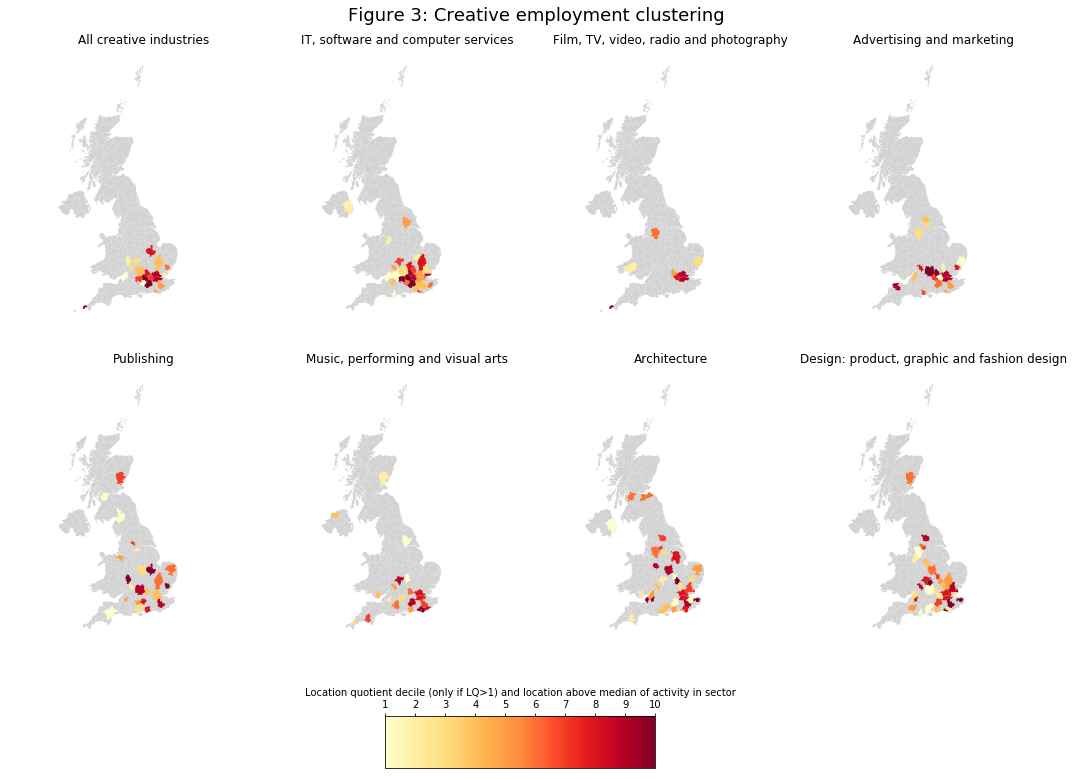

In [205]:
fig,ax = plt.subplots(ncols=4,
                     nrows=2,figsize=(15,9))

for num,x in enumerate(sectors_sorted):
    
    #Print the name of the sector
    print(x)
    
    #Set columns and rows for the axes
    col = num if num<4 else num-4
    row = 0 if num<4 else 1
    
    m = cluster_map(df=ttwa_lqs_merged,
                    sector=x,
                    esp_var='emp_lq_2015_2016',
                    act_var='emp_2015_2016',
                    ax=ax[row][col],threshold=0.5,
                    my_cmap='YlOrRd')
    
    #fig.colorbar(m, ax=ax[row][col],orientation='horizontal',pad=0.01,label='Location quotient')

#Adjust plots
plt.tight_layout()

#Further adjustment for the colorbar

#Add axes
cbar_ax = fig.add_axes([0.36, -0.15, 0.25, 0.08])

norm = mpl.colors.Normalize(vmin=1,vmax=10)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap='YlOrRd',
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Location quotient decile (only if LQ>1) and location above median of activity in sector')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')



fig.suptitle('Figure 3: Creative employment clustering',y=1.025,size=18)

plt.tight_layout()

plt.savefig(fig_path+'/{date_today}_figure_3_clustering_maps.pdf'.format(date_today=today_str),bbox_inches='tight')


All creative industries


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


IT, software and computer services
Film, TV, video, radio and photography
Advertising and marketing
Publishing
Music, performing and visual arts
Architecture
Design: product, graphic and fashion design


/usr/local/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


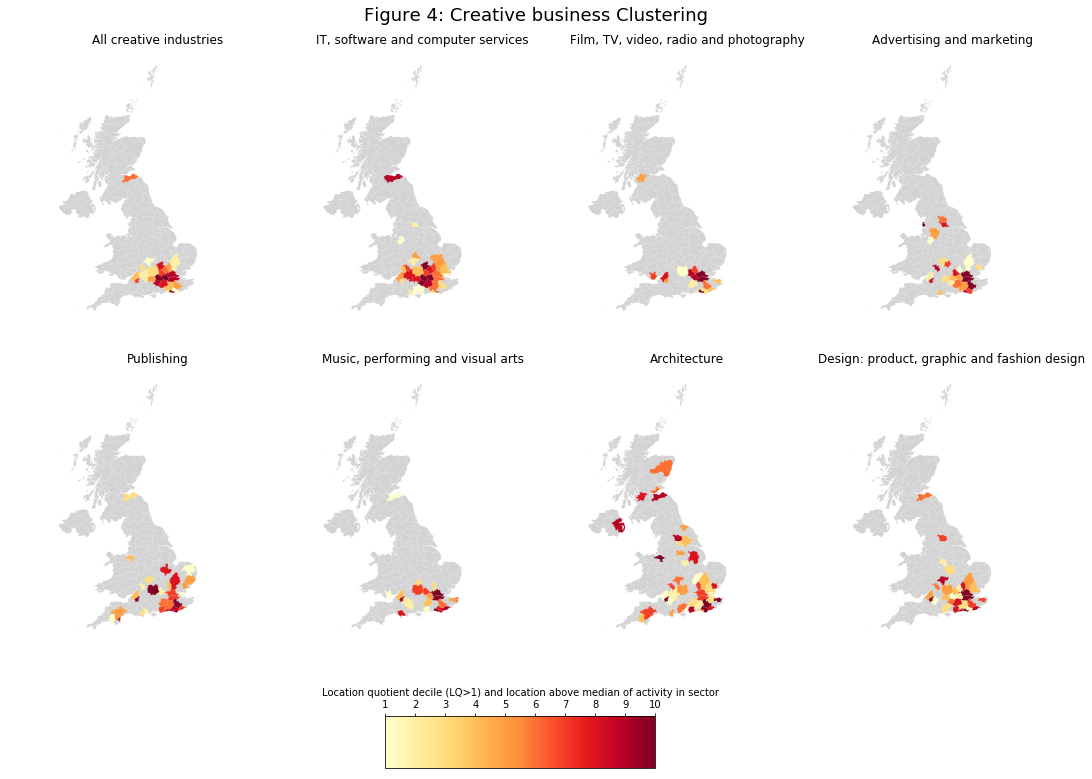

In [209]:
fig,ax = plt.subplots(ncols=4,
                     nrows=2,figsize=(15,9))

for num,x in enumerate(sectors_sorted):
    
    #Print the name of the sector
    print(x)
    
    #Set columns and rows for the axes
    col = num if num<4 else num-4
    row = 0 if num<4 else 1
    
    cluster_map(df=ttwa_lqs_merged,
                sector=x,
                esp_var='bc_lq_2015_2016',
                act_var='business_count',threshold=0.5,
                ax=ax[row][col],
                my_cmap='YlOrRd')

#Adjust plots
plt.tight_layout()

#Further adjustment for the colorbar
plt.subplots_adjust(hspace=0.1,wspace=0.01)

#Add axes
cbar_ax = fig.add_axes([0.36, -0.15, 0.25, 0.08])

norm = mpl.colors.Normalize(vmin=1,vmax=10)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap='YlOrRd',
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Location quotient decile (LQ>1) and location above median of activity in sector')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')


fig.suptitle('Figure 4: Creative business Clustering',y=1.025,size=18)

plt.tight_layout()

plt.savefig(fig_path+'/{date_today}_figure_4_bc_clustering_maps.pdf'.format(date_today=today_str),bbox_inches='tight')

#### Change in concentration figure

In [233]:
sectors_sorted_2 = list(sectors_sorted)+['not_creative']
#sectors_sorted_2 = sectors_sorted

In [234]:
#####
#Data input
#####

#We focus on these breaks
my_breaks=[0,1,5,10,25,50,75,100,130]

#Data inputs for the chart
#Extract 2016 distributions of employment and business numbers for the top chart
distributions_16_emp = pd.concat([
    extract_cumulatives(all_changes.loc[all_changes.sector==x,'emp_2015_2016'],
                        variable='emp_2015_2016',my_breaks=my_breaks,
                       sector=x) for x in sectors_sorted_2],axis=1)
#Business
distributions_16_bc = pd.concat([
    extract_cumulatives(all_changes.loc[all_changes.sector==x,'bc_2015_2016'],variable='bc_2015_2016',my_breaks=my_breaks,
                       sector=x) for x in sectors_sorted_2],axis=1)

#Extract 2015 distributions (which we will use to look at changes)
distributions_15_emp = pd.concat([
    extract_cumulatives(all_changes.loc[all_changes.sector==x,'emp_2011_2014'],variable='emp_2011_2014',my_breaks=my_breaks,
                       sector=x) for x in sectors_sorted_2],axis=1)
#And business.
distributions_15_bc = pd.concat([
    extract_cumulatives(all_changes.loc[all_changes.sector==x,'bc_2011_2014'],variable='bc_2011_2014',my_breaks=my_breaks,
                       sector=x) for x in sectors_sorted_2],axis=1)

#Changes

#We combine 2016-15 employments to extract changes in concentration
emp_conc_change = pd.concat([pd.melt(distributions_16_emp.reset_index(drop=False),id_vars='bins',
                                     value_name='emp_2015_2016',
                                    var_name='variable_2015_2016'),
           pd.melt(distributions_15_emp.reset_index(drop=False),id_vars='bins',value_name='emp_2011_2014',
                  var_name='variable_2011_2014')],axis=1)

emp_conc_change['change'] = 100*(emp_conc_change['emp_2015_2016']/emp_conc_change['emp_2011_2014']-1)

#Widen for plotting
emp_conc_wide = pd.pivot_table(emp_conc_change.iloc[:,1:],index='bins',
                               columns='variable_2015_2016',values='change')

#Same with the business counts
bc_conc_change = pd.concat([pd.melt(distributions_16_bc.reset_index(drop=False),
                                        id_vars='bins',value_name='bc_2015_2016',
                                    var_name='variable_2015_2016'),
           pd.melt(distributions_15_bc.reset_index(drop=False),id_vars='bins',value_name='bc_2011_2014',
                  var_name='variable_2011_2014')],axis=1)

bc_conc_change['change'] = 100*(bc_conc_change['bc_2015_2016']/bc_conc_change['bc_2011_2014']-1)

#And widen
bc_conc_wide = pd.pivot_table(bc_conc_change.iloc[:,1:],index='bins',
                               columns='variable_2015_2016',values='change')

In [235]:
#Labels for the X axis
conc_labels = ['Largest location','5 largest','10 largest ','25 largest','50 largest','75 largest','100 largest',
              '120 largest']


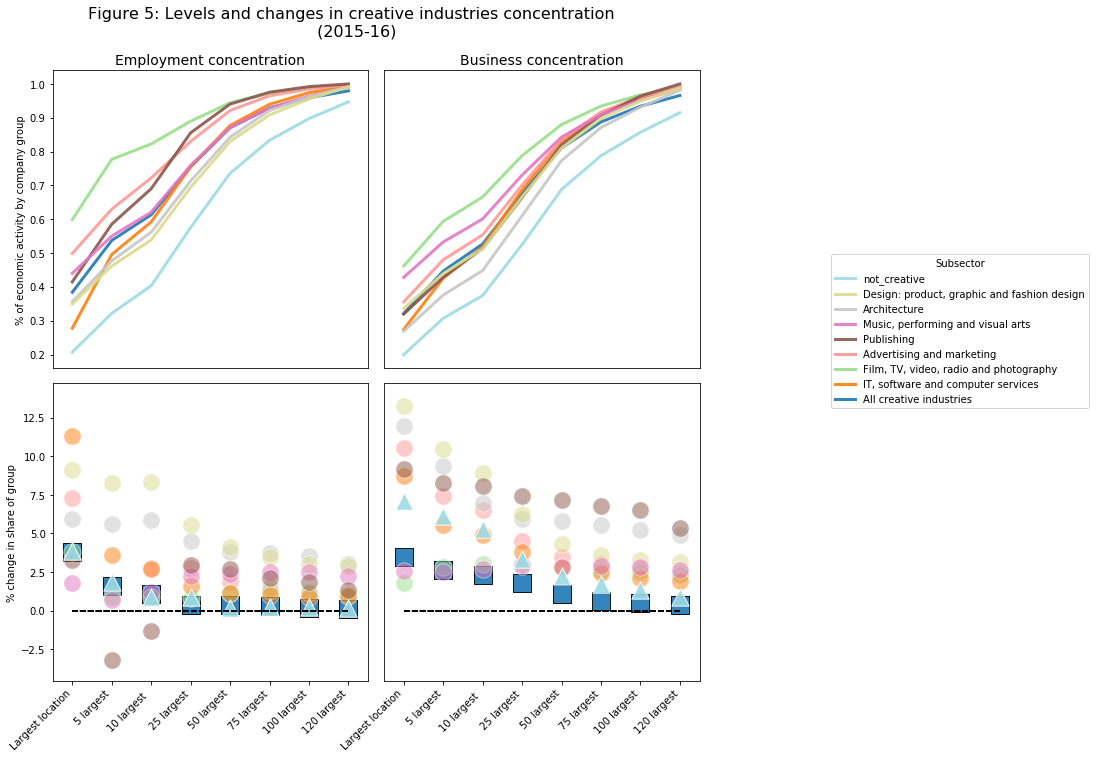

In [245]:
#####
#PLOT
#####

fig,ax = plt.subplots(figsize=(10,10),ncols=2,nrows=2,
                      sharex='col',
                      sharey='row')

#Plot employment concentrations
distributions_16_emp.plot(ax=ax[0][0],linewidth=3,alpha=0.9,colormap='tab20')
ax[0][0].set_xlim(-0.5,len(distributions_16_emp)-0.5)
ax[0][0].set_xticks(np.arange(len(distributions_16_emp)))

#Titles
ax[0][0].set_title('Employment concentration',fontsize=14)
ax[0][0].set_ylabel('% of economic activity by company group')

#Remove the ticks for the x
ax[0][0].tick_params(axis='x', which='both', length=0)


#We will only use this legend. NN we displace it from its anchor so it's on the side, and
#we flip the order of the labels so that we have more concentrated categories at the top.

#This takes the handles and labels generated by matplotlib and allows us to modify them.
handles,labels = ax[0][0].get_legend_handles_labels()
ax[0][0].legend(bbox_to_anchor=[3.3,0.4],handles=handles[::-1],labels=labels[::-1],title='Subsector')

#Plot the business distributions
distributions_16_bc.plot(ax=ax[0][1],linewidth=3,alpha=0.9,colormap='tab20')
ax[0][1].set_xlim(-0.5,len(distributions_16_emp)-0.5)
ax[0][1].set_title('Business concentration',fontsize=14)
ax[0][1].set_xticks(np.arange(len(distributions_16_bc)))

#Remove all the ticks
ax[0][1].tick_params(axis='both', which='both', length=0)

#We make the legend invisible
ax[0][1].legend().set_visible(False)

#Get lines to label the colours below
lines = ax[0][1].get_lines()

#Create a lookup so we know what colour goes with every line. We then use it to colour the circles below.
lines_colors_lookup = {x.get_label():x.get_color() for x in lines}

#Draw the employment scatter
#Loop over every sector and draw it in the scatter
for x in np.arange(0,len(emp_conc_wide.columns)):
    
    #We have a lower alpha for the creative industries category (we want it to be more visible)
    ax[1][0].scatter(np.arange(len(emp_conc_wide)),emp_conc_wide.iloc[:,x],
                     color=lines_colors_lookup[emp_conc_wide.columns[x]],
                     marker = 's' if emp_conc_wide.columns[x] =='All creative industries' else '^' if emp_conc_wide.columns[x] =='not_creative' else 'o',
                     edgecolor='white' if emp_conc_wide.columns[x] !='All creative industries' else 'black',
                     s=300,alpha=0.5 if emp_conc_wide.columns[x] not in ['not_creative','All creative industries'] else 0.9)
    ax[1][0].set_xlim(-0.5,len(distributions_16_emp)-0.5)
    ax[1][0].hlines(0,xmin=0,xmax=7,linestyle='dashed')
    ax[1][0].set_ylabel('% change in share of group')
    ax[1][0].set_xticklabels([conc_labels[x] for x in np.arange(len(distributions_16_emp))],rotation=45,ha='right')

#Draw the business count scatter
for x in np.arange(len(emp_conc_wide.columns)):
    ax[1][1].scatter(np.arange(len(bc_conc_wide)),bc_conc_wide.iloc[:,x],
                     color=lines_colors_lookup[bc_conc_wide.columns[x]],
                     marker = 's' if emp_conc_wide.columns[x] =='All creative industries' else '^' if emp_conc_wide.columns[x] =='not_creative' else 'o',
                     edgecolor='white' if emp_conc_wide.columns[x] !='All creative industries' else 'black',
                     s=300,alpha=0.5 if emp_conc_wide.columns[x] not in ['All creative industries','not_creative'] else 0.9)
    ax[1][1].hlines(0,xmin=0,xmax=7,linestyle='dashed')
    ax[1][1].set_xticklabels([conc_labels[x] for x in np.arange(len(distributions_16_bc))],rotation=45,ha='right')
    
#Remove all the ticks
ax[1][1].tick_params(axis='y',which='both',length=0)

#Title above. NB the y we use to 
fig.suptitle('Figure 5: Levels and changes in creative industries concentration \n (2015-16)',y=1.05,fontsize=16)

#Tight layout 
plt.tight_layout()

#Adjust subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig(fig_path+'/{today_str}_figure_5_concentration.pdf'.format(today_str=today_str),bbox_inches='tight')

In [227]:
distributions_16_emp.iloc[:2,:]

,All creative industries,"IT, software and computer services","Film, TV, video, radio and photography",Advertising and marketing,Publishing,"Music, performing and visual arts",Architecture,"Design: product, graphic and fashion design",not_creative
bins,,,,,,,,,
"[0, 1)",0.384082,0.277723,0.598979,0.498866,0.414849,0.440062,0.355904,0.349602,0.207394
"[1, 5)",0.537250,0.495804,0.777095,0.629877,0.585348,0.550275,0.476988,0.461641,0.321814


In [460]:
distributions_16_bc.iloc[:2,:]

,creative_industries,"IT, software and computer services","Film, TV, video, radio and photography",Advertising and marketing,Publishing,"Music, performing and visual arts",Architecture,"Museums, galleries and libraries",Design,Crafts
bins,,,,,,,,,,
"[0, 1)",0.320994,0.272337,0.445460,0.354544,0.303126,0.423862,0.264617,0.123171,0.335607,0.372951
"[1, 5)",0.446763,0.421423,0.578715,0.478349,0.406887,0.527567,0.370705,0.213415,0.436840,0.549180


In [461]:
emp_conc_change.loc[(emp_conc_change.variable_2015=='creative_industries')].reset_index(drop=True).iloc[:3]

,bins,variable_2016,emp_2016,bins,variable_2015,emp_2015,change
0,"[0, 1)",creative_industries,0.365081,"[0, 1)",creative_industries,0.348886,4.641845
1,"[1, 5)",creative_industries,0.498861,"[1, 5)",creative_industries,0.484971,2.864076
2,"[5, 10)",creative_industries,0.585756,"[5, 10)",creative_industries,0.572630,2.292166


#### Changes in concentration of activity by region

Here we create a barplot that considers concentration and changes in concentration of activity by region 



In [462]:
#Create a dataframe with changes in concentration by sector, region and year
activity_concentration = all_changes.loc[
    [x in ['creative_industries','not_in_sector'] for x in all_changes.sector],
    ['ttwa_name','region','sector','emp_2015','emp_2016','bc_2015','bc_2016']].reset_index(drop=True)

#Estimate shares
activity_shares_region = activity_concentration.groupby(
    ['region','sector'])[['emp_2015','emp_2016','bc_2015','bc_2016']].apply(lambda x: 100*x/x.sum())

#Extract columns
activity_shares_region.columns = [x+'_shares' for x in activity_shares_region.columns]

#Concatenate
activity_concentration = pd.concat([activity_concentration,activity_shares_region],axis=1)

In [463]:
region_mean_c = activity_concentration.groupby('region')['emp_2016_shares','bc_2016_shares'].max().mean(axis=1)
sorted_regions = region_mean_c.dropna().sort_values(ascending=False).index
sorted_regions

Index(['London', 'North East', 'North West', 'Wales', 'West Midlands',
       'Scotland', 'Yorkshire and The Humber', 'South West', 'East Midlands',
       'East of England', 'South East'],
      dtype='object', name='region')

In [464]:
def region_share_comp(var,region,ax):
    '''
    This function takes a region from activity and creates a barcharts comparing the variable
    in cis and other sectors
    
    
    '''
    #Extract region
    #print(region)
    reg = activity_concentration.loc[activity_concentration.region==region,:]
    
    
    #Extract data for variables and change names (this would be much easier if we put data in a tidy format)
    creat = reg.loc[reg.sector=='creative_industries',var].sort_values(ascending=False).reset_index(drop=True)
    creat.name=var+'_creative'
    
    not_creat = reg.loc[reg.sector=='not_in_sector',var].sort_values(ascending=False).reset_index(drop=True)
    
    not_creat.name = var+'_not_creative'
    
    #Concatenate variables
    var_mix = pd.concat([creat,not_creat],axis=1)

    for num,x in enumerate(var_mix.columns):
    #Select data
        data = var_mix[x]
        
        #Create color map

        reds = mpl.cm.OrRd

        #We rescale the data to assign the right color to each variable
        descaled_data = descale(data,0,200)
        

        #Extract colors in a list we can then select
        colors = [reds(int(x)) for x in descaled_data]
        
        #Bottom of the barchart
        bot=0
        #Stack the vars
        for z in np.arange(len(var_mix.index)):
            ax.bar(x=num,height=data.loc[z],bottom=bot,color=colors[z],alpha=0.9,edgecolor='white',linewidth=1.3)
            bot=bot+data.loc[z]
            
    #And we also want to draw a plot that connects all the lines
    
    bot_0=0
    bot_1=0
    
    for z in np.arange(len(var_mix)):
        ax.plot([0,1],[var_mix.iloc[z,0]+bot_0,
                       var_mix.iloc[z,1]+bot_1],color='black',marker='o',alpha=0.3)
        
        bot_0 = var_mix.iloc[z,0]+bot_0
        bot_1 = var_mix.iloc[z,1]+bot_1
    
    
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Creative industries','Other sectors'],rotation=90,ha='right')
    
    #ax.set_title(region)
    

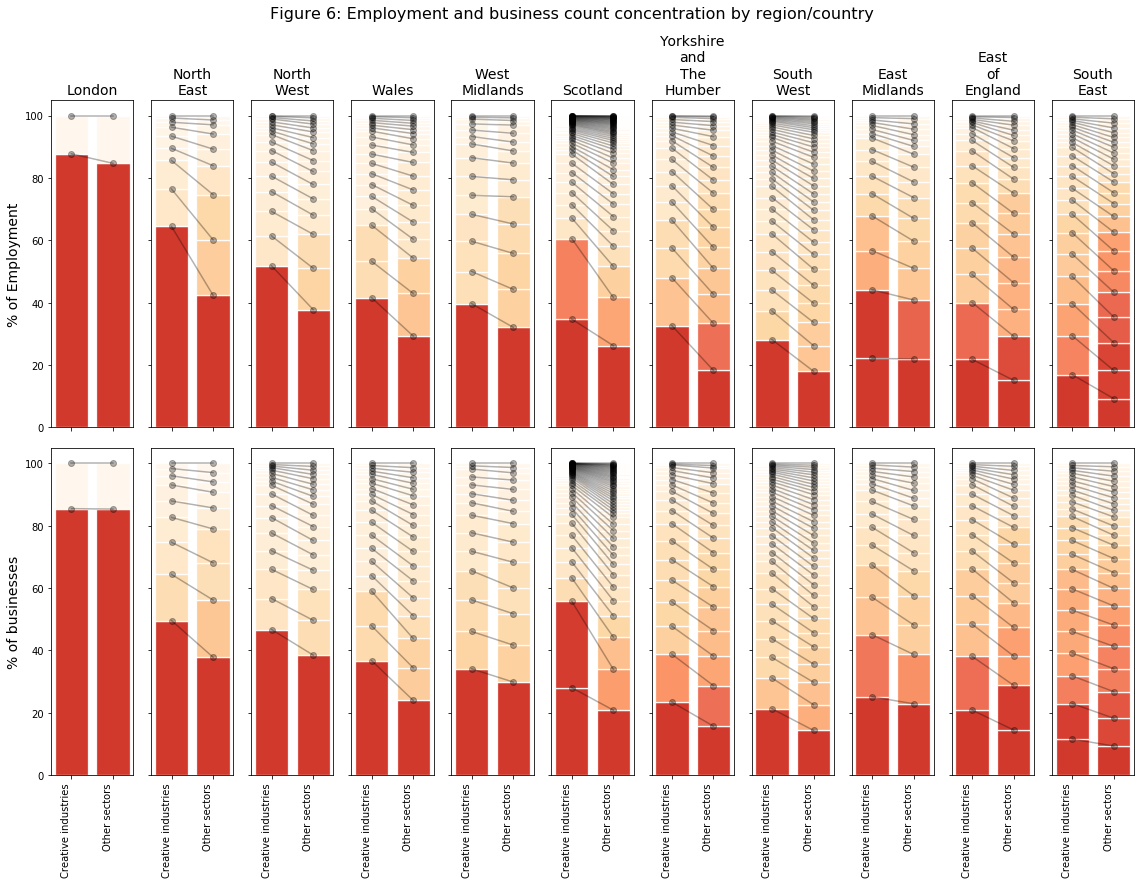

In [465]:
fig,ax = plt.subplots(nrows=2,ncols=len(set((sorted_regions))),figsize=(16,12),
                     sharey='row',sharex='col')

for num,reg in enumerate(sorted_regions):
    
    region_share_comp('emp_2016_shares',reg,ax[0][num])
    
    region_share_comp('bc_2016_shares',reg,ax[1][num])
    
    ax[0][num].set_title("\n".join([x for x in reg.split(" ")]),fontsize=14)
    

ax[0][0].set_ylabel('% of Employment',fontsize=14)
ax[1][0].set_ylabel('% of businesses',fontsize=14)
    
fig.suptitle('Figure 6: Employment and business count concentration by region/country',y=1.02,fontsize=16)
    
plt.tight_layout()

plt.savefig(fig_path+'/{date}_figure_6_intra_regional_concentration.pdf'.format(date=today_str),bbox_inches='tight')


### c. Neighbourhood dynamics

#### Regional comparison

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5,1.03,'Creative subsector growth')

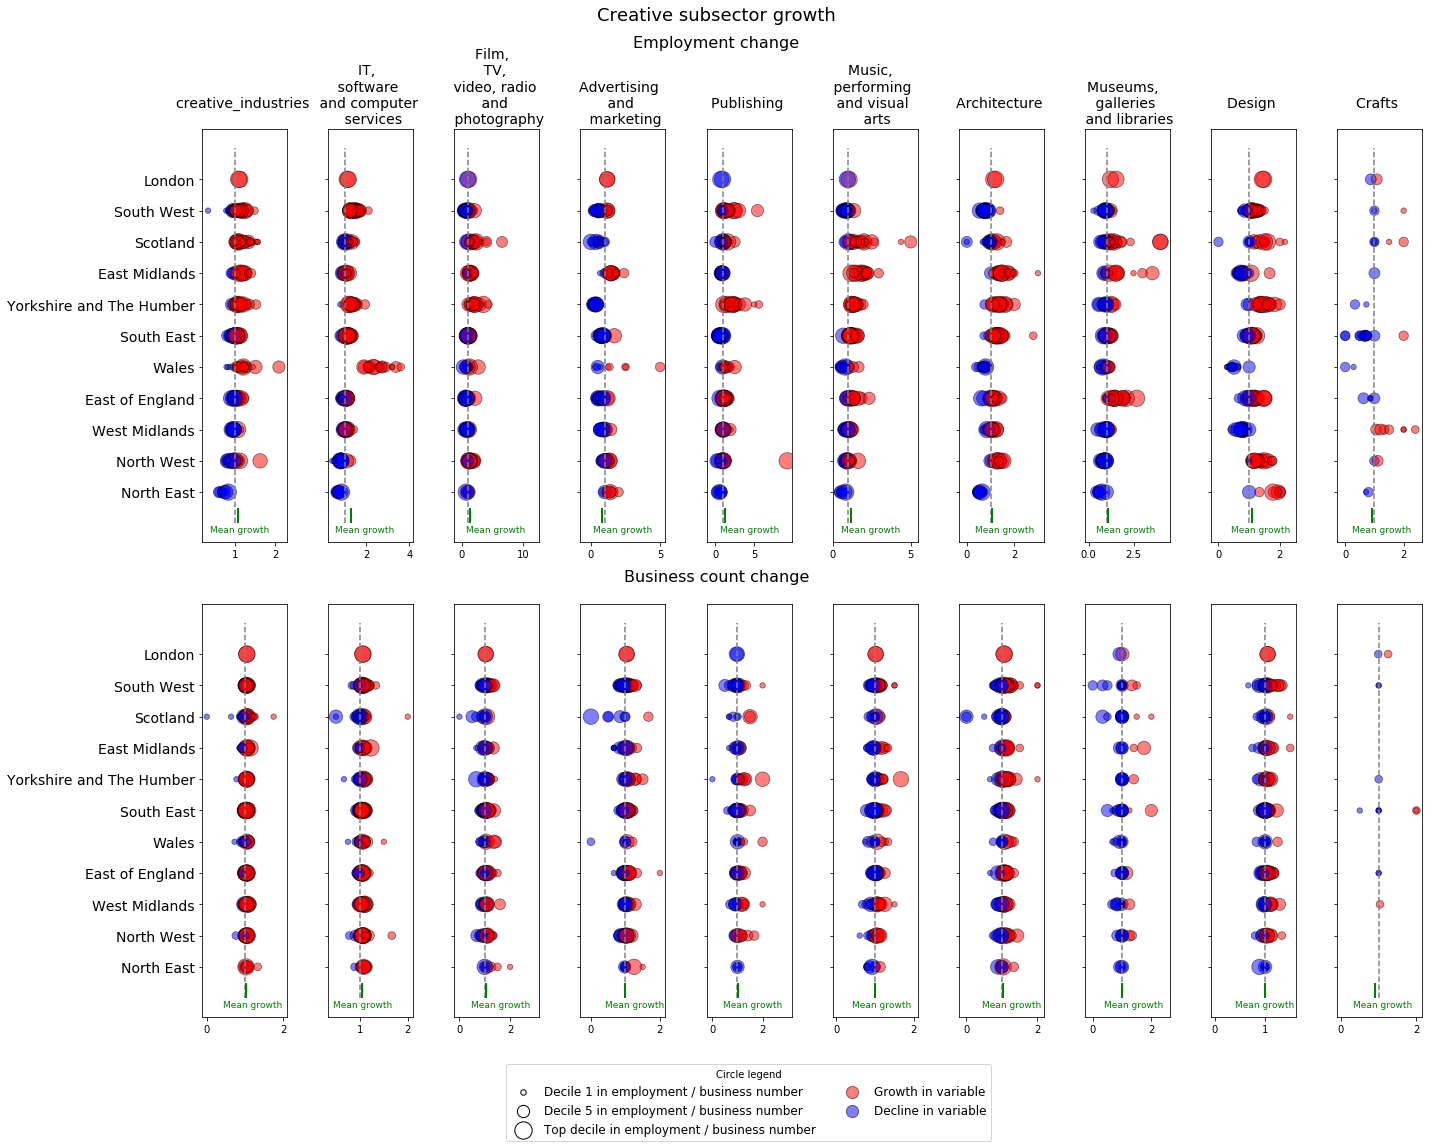

In [466]:
#The columns are a sector
#sectors_sorted = [x for x in sectors_sorted if x!='Crafts']


#Create plot
fig,ax = plt.subplots(ncols=len(sectors_sorted),nrows=2,figsize=(20,14),sharey='row',
                      #sharex='col'
                     )

#Loop over sectors to subset
for num,x in enumerate(sectors_sorted):
    
    #Get data for the sector
    sector_data = all_changes.loc[all_changes.sector==x,:]
    
    #Convert the data into a collection of vectors for each region
    
    #1. Employment
    data_rate = [list(sector_data.loc[sector_data.region==reg,'employment_change'].dropna()) for reg in regions_sorted]
    data_total = [list(sector_data.loc[sector_data.region==reg,'emp_2016'].dropna()) for reg in regions_sorted]
    
    #Create a discretised (in deciles) variable in the dataframe (we use these for the circle sizes)
    sector_data['quantised']= pd.qcut(sector_data.loc[:,'emp_2016'],q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
    #Now we produce the same vectors as before but with the quantiles
    data_quant = [list(sector_data.loc[sector_data.region==reg,'quantised'].dropna()) for reg in regions_sorted]
    
    #2. Business counts
    data_rate_bc = [list(sector_data.loc[sector_data.region==reg,'business_change'].dropna()) for reg in regions_sorted]
    data_total_bc = [list(sector_data.loc[sector_data.region==reg,'bc_2016'].dropna()) for reg in regions_sorted]
    
    #Create a discretised (in deciles) variable in the dataframe
    sector_data['quantised_bc']= pd.qcut(sector_data.loc[:,'bc_2016'],
                                         q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
    #Extract the deciles for each region
    data_quant_bc = [list(sector_data.loc[sector_data.region==reg,'quantised_bc'].dropna()) for reg in regions_sorted]
    
    #This loops over each region to subset its data and produce the scatter.
    for num_2 in np.arange(len(regions_sorted)):
        
        #This tells us how many points to use in the scatter (as many as there are TTWAs)
        tot = len(data_rate[num_2])
        
        #Draw the employment info in the top scatter
        ax[0][num].scatter(y=[num_2]*tot,
                        x=data_rate[num_2],
                        s=[x*30 for x in data_quant[num_2]],
                        alpha=0.5,
                        edgecolor='black',
                        linewidth=0.8,
                        c=['red' if x >1 else 'blue' for x in data_rate[num_2]])
        
        #Draw the business info inthe second scatter
        tot_2 = len(data_rate_bc[num_2])
        ax[1][num].scatter(y=[num_2]*tot_2,
                           x=data_rate_bc[num_2],
                           s=[x*30 for x in data_quant_bc[num_2]],
                           alpha=0.5,
                           edgecolor='black',
                           linewidth=0.8,
                           c=['red' if x >1 else 'blue' for x in data_rate_bc[num_2]])
    
    #We want to add chart titles that include a line break after a certain length
    sector_name = []
    
    split=x.split(" ")
    
    #If the number of words is above 3 it in
    split_rejoined = " ".join([x if num%3 == 0 else ' \n '+x for num,x in enumerate(split)])
    
    if '\n' not in split_rejoined:
        split_rejoined+=' \n'
    
    #Add all the titles and ticks
    ax[0][num].set_title(split_rejoined,size=14)
    ax[0][num].set_yticks(np.arange(len(regions_sorted)))
    ax[0][num].set_yticklabels(regions_sorted,size=14)
    
    #Add a vline to separate growth and decline
    ax[0][num].vlines(x=1,ymin=-1,ymax=11,color='grey',linestyle='--')
    
    #Add a green line with mean growth for the sector
    ax[0][num].vlines(x=sector_data.loc[:,'employment_change'].dropna().mean(),
                     ymin=-1,ymax=-0.5,color='green',linewidth=2)
    ax[0][num].annotate('Mean growth',xy=(sector_data.loc[:,'employment_change'].dropna().mean()-0.7,
                                          -1.3),color='green',size=9)
                       
    #Titles and ticks for the business count plots
    ax[1][num].set_yticks(np.arange(len(regions_sorted)))
    ax[1][num].set_yticklabels(regions_sorted,size=14)
    ax[1][num].vlines(x=1,ymin=-1,ymax=11,color='grey',linestyle='--')
    
    #Mean growth for businesses 
    ax[1][num].vlines(x=sector_data.loc[:,'business_change'].dropna().mean(),
                      ymin=-1,ymax=-0.5,color='green',linewidth=2)
    ax[1][num].annotate('Mean growth',xy=(sector_data.loc[:,'business_change'].dropna().mean()-0.6,
                                          -1.3),color='green',size=9)
    
    #Add custom legend with some invisible scatters
    d1 = plt.scatter([],[], s=30, marker='o',color='white',edgecolor='black')
    d5 = plt.scatter([],[], s=150, marker='o',color='white',edgecolor='black')
    d10 = plt.scatter([],[], s=300, marker='o',color='white',edgecolor='black')
    pg = plt.scatter([],[], s=150, marker='o',color='red',edgecolor='black',alpha=0.5)
    ng = plt.scatter([],[], s=150, marker='o',color='blue',edgecolor='black',alpha=0.5)

    #Add legend
    plt.legend((d1,d5,d10,pg,ng),
               ('Decile 1 in employment / business number', 
                'Decile 5 in employment / business number', 
                'Top decile in employment / business number',
               'Growth in variable','Decline in variable'),
               scatterpoints=1,
               title='Circle legend',
               bbox_to_anchor=(
                   -4,
                   -0.1),
               ncol=2,
               fontsize=12)    
    
#Add subplot row titles
plt.figtext(x=0.5,y=0.99,s='Employment change',size=16,ha='center')
plt.figtext(x=0.5,y=0.46,s='Business count change',size=16,ha='center')

#Layout
plt.tight_layout()

#Adjust subplots to create some space for the row titles
plt.subplots_adjust(hspace=0.15)

#Figure title
fig.suptitle('Creative subsector growth',y=1.03,size=18)

#Plot
#plt.savefig(fig_path+'/{date}_figure_6_subsector_change.pdf'.format(date=today_str),bbox_inches='tight')

#### Maps

Idea: for each TTWA, find its neighbours and average their performance (could be growth or concentration,
by sector or something else). Then correlate its performance with theirs.



In [467]:
#Create data for scatters as a lookup
data_for_scatters = {x:get_neighbour_stats(all_data.reset_index(drop=False),x,'emp')[0] for x in
                sectors_sorted}

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


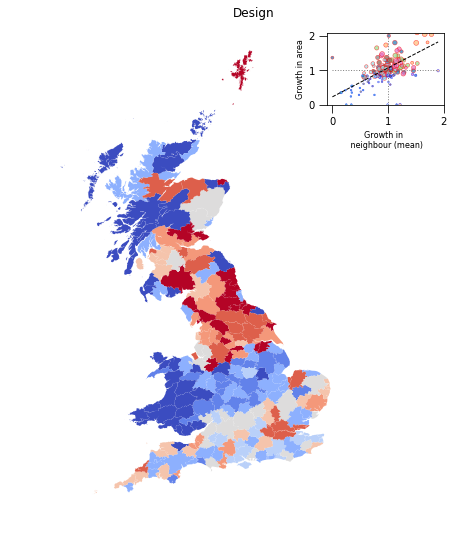

In [468]:
fig,ax = plt.subplots(figsize=(7,9))
map_sector('Design',ax,df=ttwa_merged,neighbor_lookup=data_for_scatters,my_cmap='coolwarm')

In [469]:
#Need to fix the regressions

creative_industries


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


IT, software and computer services


/usr/local/lib/python3.5/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


Film, TV, video, radio and photography
Advertising and marketing
Publishing
Music, performing and visual arts
Architecture
Museums, galleries and libraries
Design
Crafts


/usr/local/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


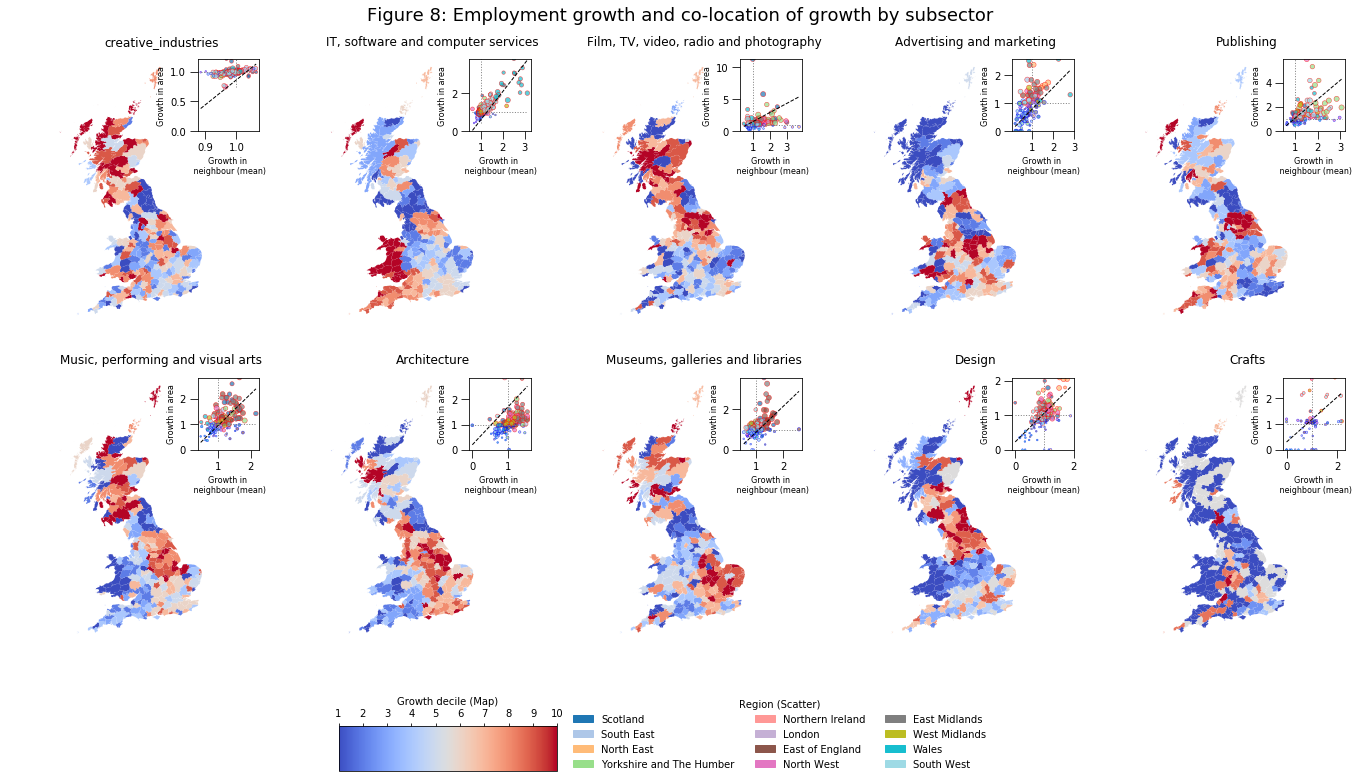

In [470]:
fig,ax = plt.subplots(ncols=5,
                     nrows=2,figsize=(19,9))

for num,x in enumerate(sectors_sorted):
    
    #Print the name of the sector
    print(x)
    
    #Set columns and rows for the axes
    col = num if num<5 else num-5
    row = 0 if num<5 else 1
    
    map_sector(x,ax[row][col],df=ttwa_merged,neighbor_lookup=data_for_scatters,my_cmap='coolwarm')

#Adjust plots
plt.tight_layout()

#Further adjustment for the colorbar
plt.subplots_adjust(hspace=0.01,wspace=0.01,bottom=0.6)

#Create the colorbar 
#Add axes
cbar_ax = fig.add_axes([0.25, -0.15, 0.16, 0.07])

#Add colorbar
norm = mpl.colors.Normalize(vmin=1,vmax=10)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap='coolwarm',
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Growth decile (Map)')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')



plt.legend(
    handles=patches_reg,labels=regions,ncol=3,
    loc='lower right',
    bbox_to_anchor=(3,-0.15),
    title='Region (Scatter)',frameon=False)


fig.suptitle('Figure 8: Employment growth and co-location of growth by subsector',y=1.03,size=18)

plt.tight_layout()

plt.savefig(fig_path+'/{date_today}_figure_8_growth_maps.pdf'.format(date_today=today_str),bbox_inches='tight')


In [471]:
# Stat for the report

creative_neigh_stats = data_for_scatters['creative_industries']



pd.crosstab(creative_neigh_stats.emp_own>1,creative_neigh_stats.emp_neighbor>1,normalize=1)


emp_neighbor,False,True
emp_own,,
False,0.828221,0.4
True,0.171779,0.6


### d. Survival rates and growth dynamics

**Actions**

* Descriptive analysis visualisation will require

``` 
Gdyn

TTWA \\ Type of change \\ Employment change (period 1) \\ Employment change (share of total)  \\ Employment change (period 1 vs period 2) \\ Surv rate

```




* Create a DF for EDA:

```
Micro-rate \\ Large firm share \\ Employment diversity \\ Business diversity \\ Survival rates \\ 
\\ Employment growth \\ Business growth \\ Specialisation growth \\ Diversification (#sectors with 
specialisation gains) \\ Number of sectors with business + employment specialisation gains
Growth dynamics (% of jobs created by large comps) \\ Churn \\ Company stability 

```

* Create heatmap and correlate
* Based on this, opt for charts to explore

** Some hypotheses to explore**

* More diverse / churny locations grow faster / have more employment growth due to hgfs
* More diverse locations gain specialisation in more sectors
* Locations with more microbusinesses are churnier
* Locations with more large firms are more stable



#### UK chart

In [472]:
#First: UK analysis
my_vars = ['Unnamed: 1','Number of firms','Change in employment']


growth_dfs = pd.concat([
    process_gdyn_data(df,name) for df,name in zip([gdyn_creat,gdyn_non_creat],['creative','non_creative'])],axis=0)

In [473]:
sorter = growth_dfs.reset_index(drop=False).groupby('Unnamed: 1')[
    'Number of firms'].sum().sort_values().index

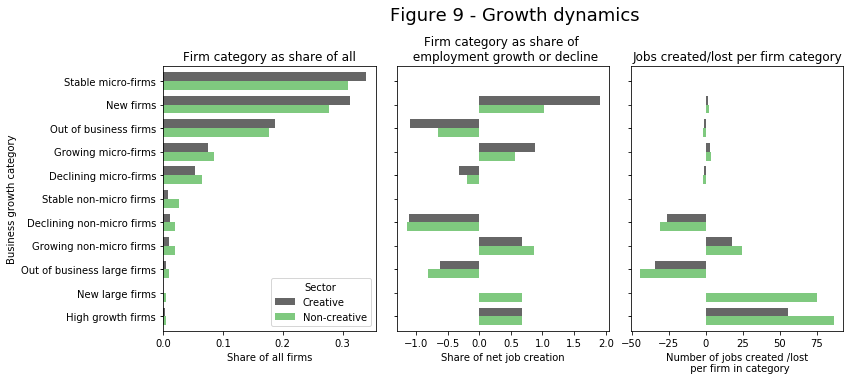

In [474]:
fig,ax = plt.subplots(ncols=3,figsize=(12,5),sharey=True)

growth_dfs = growth_dfs.loc[sorter]

titles=['Firm category as share of all','Firm category as share of \n employment growth or decline',
        'Jobs created/lost per firm category']

ylabs = ['Stable micro-firms','New firms','Out of business firms','Growing micro-firms',
         'Declining micro-firms','Stable non-micro firms','Declining non-micro firms','Growing non-micro firms',
        'Out of business large firms','New large firms','High growth firms']

xlabs = ['Share of all firms','Share of net job creation','Number of jobs created /lost\n  per firm in category']

for num,x in enumerate(['share_all_firms', 'share_all_employment','jobs_per_firm']):
    
    new_df = pd.pivot_table(growth_dfs.reset_index(drop=False),index='Unnamed: 1',
                                    columns='sector',values=x,aggfunc='sum').loc[sorter][['non_creative','creative']] 
    
    new_df.plot.barh(ax=ax[num],width=0.75,cmap='Accent') 
    
    if num>0:
        ax[num].legend().set_visible(False)
        
    else:
        handles, labels = ax[num].get_legend_handles_labels()
        ax[num].legend(labels=['Creative','Non-creative'],handles=handles[::-1],loc='lower right',title='Sector')
        
    ax[num].set_title(titles[num])
    ax[num].set_yticklabels(ylabs[::-1])
    ax[num].set_ylabel('Business growth category')
    
    ax[num].set_xlabel(xlabs[num])
    
    if num>2:
        ax[num].set_yticks([])

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

fig.suptitle("Figure 9 - Growth dynamics",y=1.05,x=0.6,size=18)

plt.savefig(fig_path+'/{today}_figure_9_growth_dyn.pdf'.format(today=today_str),bbox_inches='tight')



In [475]:
la = process_gdyn_data(gdyn_creat,'ceative')
la
#la.iloc[:,1]/la.iloc[:,1].sum()

,Number of firms,Change in employment,share_all_firms,share_all_employment,jobs_per_firm,sector
Unnamed: 1,,,,,,
bigdeath,1605,-55310,0.00452285,-0.615924,-34.4611,ceative
birth,110715,171060,0.311992,1.9049,1.54505,ceative
bl10dec,18675,-28570,0.0526256,-0.318151,-1.52985,ceative
bl10inc,26325,79770,0.0741831,0.888307,3.0302,ceative
bl10sm,120090,0,0.33841,0,0,ceative
bv10dec,3765,-99900,0.0106097,-1.11247,-26.5339,ceative
bv10logr,3380,60870,0.00952475,0.67784,18.0089,ceative
bv10sm,2975,0,0.00838347,0,0,ceative
death,66250,-98590,0.186691,-1.09788,-1.48815,ceative


In [476]:
1085/(1085+2975+3380+3765+1605)

0.88/0.67

1.3134328358208955

#### Selected TTWAs chart

In [477]:
#Process growth dynamics

#Label with TTWA
gdyn_ttwa['ttwa_name'] = [ttwa_name_lookup[x] if x in ttwa_name_lookup.keys() else np.nan for x in gdyn_ttwa.ttwa ]

#Select relevant vars

gdyn_sel = gdyn_ttwa[['ttwa_name','bandemployment','cohort','d_employment','entref','industry']]
gdyn_sel['dir'] = ['grow' if x in ['birth','bl10inc','bv10logr','hgr'] 
                   else 'stable' if x in ['bl10sm'] else 'decline' for x in gdyn_sel['bandemployment']]

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [478]:
#Calculate shares

#Share of businesses
gdyn_sel['biz_share'] = gdyn_sel.groupby(['ttwa_name','cohort','industry'])['entref'].apply(lambda x: x/x.sum())

gdyn_sel['emp_share'] = gdyn_sel.groupby(['ttwa_name','cohort','industry','dir'])[
    'd_employment'].apply(lambda x: np.abs(x)/x.sum())



/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [479]:
#A bit more munging
#Focus only on the most recent cohort

gdyn_sel_recent = gdyn_sel.loc[(gdyn_sel.cohort=='201013-201316') & 
                               ([x in ['All creative','Other'] for x in gdyn_sel.industry]),:].drop('cohort',axis=1)

#Reshape to normalise creative vs other sectors
gdyn_comps = pd.pivot_table(gdyn_sel_recent,index=['ttwa_name','bandemployment'],
                            columns='industry',values=['emp_share','biz_share']).reset_index(drop=False)

#Change names of columns (multi-index)
gdyn_comps.columns = ["_".join(col) for col in gdyn_comps.columns]

#Create new column
gdyn_comps['creative_emp_vs_other'] = gdyn_comps['emp_share_All creative']/ gdyn_comps['emp_share_Other']

#Merge everything
gdyn_merged = pd.merge(gdyn_sel_recent.loc[gdyn_sel_recent.industry=='All creative'],
                       gdyn_comps,
                       left_on=['ttwa_name','bandemployment'],
                       right_on=['ttwa_name_','bandemployment_'])[
    ['ttwa_name','bandemployment','d_employment','entref','biz_share','emp_share','creative_emp_vs_other']]

In [480]:
#Create a jobs creation var (also for sorting)

ttwa_emp_growth = gdyn_merged.groupby('ttwa_name')['d_employment'].sum().sort_values(ascending=False)

my_ttwas = [x for x in ttwa_emp_growth.index if x in ttwa_is_cluster + ['Birmingham']]
                                                                        #'Huddersfield']]


#Subset by its ttwa
gdyn_merged_cluster = gdyn_merged.loc[[x in ttwa_is_cluster+['Birmingham']
                                                             #'Huddersfield'] 
                                       for x in gdyn_merged.ttwa_name],:]

gdyn_merged_cluster.fillna(0,inplace=True)


#Some preps

#sort categories based on the levels of growth they create
bands_biz = gdyn_merged_cluster.groupby('bandemployment')['emp_share'].mean().sort_values(ascending=False)

#Color palette
bar_cols = plt.matplotlib.cm.get_cmap('Pastel2_r').colors[:8]

bands_biz_negs = list(bands_biz.index[bands_biz<0])
band_biz_pos = list(bands_biz.index[bands_biz>0])

surv_long = pd.melt(surv_ttwa,id_vars=['ttwa','industry'])
surv_long['ttwa_name'] = [ttwa_name_lookup[x] for x in surv_long.ttwa]

surv_sel = pd.pivot_table(surv_long.loc[[x in my_ttwas for x in surv_long.ttwa_name] and 
                        ['rate' in x for x in surv_long.variable],:],
                          index=['ttwa_name','variable'],columns='industry',values='value').reset_index(drop=False)




/usr/local/lib/python3.5/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [481]:
regions_sorted_2 = regions_sorted[::-1]+['Northern Ireland']

my_ttwas_sorted_2 = [x[0] for x in sorted([[x,ttwa_region_lookup[x],
                           regions_sorted_2.index(ttwa_region_lookup[x])] for x in my_ttwas],key=lambda x: x[2])]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:25: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:35: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:40: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0


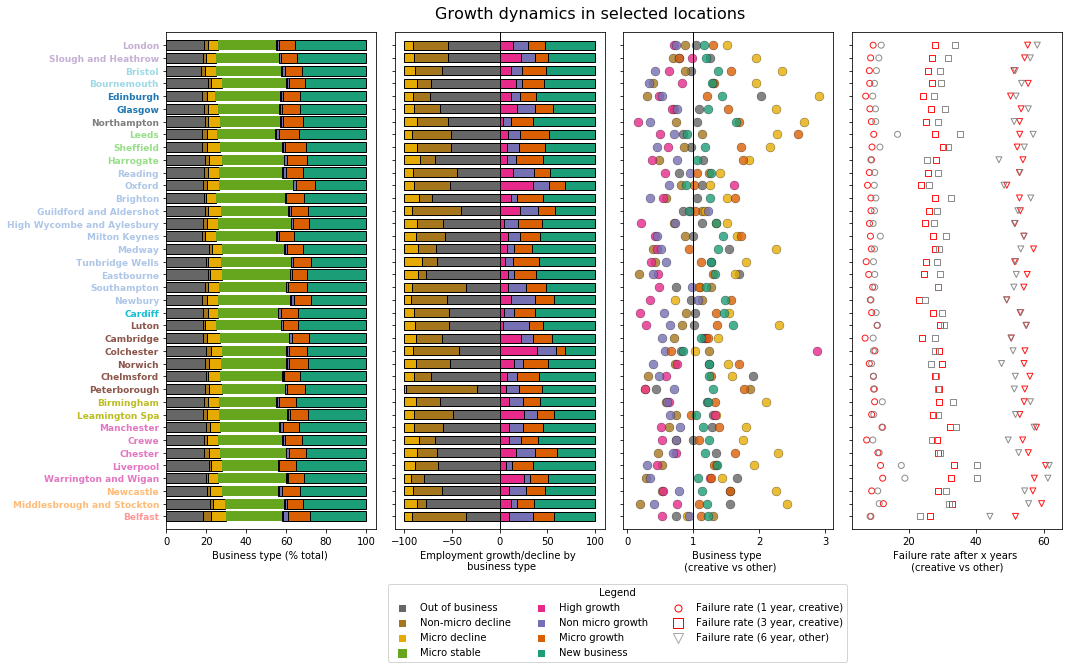

In [482]:
#Draw plot

bar_cols = plt.matplotlib.cm.get_cmap('Dark2_r').colors[:8]

fig,ax = plt.subplots(figsize=(15,8),ncols=4,sharey=True)

#Loop over TTWAs
for num,ttwa in enumerate(reversed(my_ttwas_sorted_2)):
    
    #Subset
    ttwa_data = gdyn_merged_cluster.loc[gdyn_merged_cluster.ttwa_name==ttwa,:]
    
    #Bottom for bars
    bot_biz = 0
    bottom_decl=0
    bottom_gr=0
    
    for num_2,sizeb in enumerate(reversed(bands_biz.index)):
        
        #Business growth share
        value_biz=100*float(ttwa_data.loc[ttwa_data.bandemployment==sizeb,'biz_share'])
        #print(value)
        ax[0].barh(bottom=num,width=value_biz,height=0.8,left=bot_biz,
               color=bar_cols[num_2],
               edgecolor='black' if sizeb in band_biz_pos else 'black' if sizeb in bands_biz_negs else None)
        
        bot_biz = bot_biz+value_biz
        
        #Employment value
        value_emp = 100*float(ttwa_data.loc[ttwa_data.bandemployment==sizeb,'emp_share'])
        
        #Plot upwards if the sizeband is positive, downwards if the sizeband is negative
        if sizeb in list(bands_biz_negs):
            ax[1].barh(bottom=num,width =value_emp,height=0.7,left=bottom_decl,color=bar_cols[num_2],
                     edgecolor='black')
            bottom_decl = bottom_decl + value_emp
            
        if sizeb in list(band_biz_pos):
            ax[1].barh(bottom=num,width =value_emp,height=0.7,left=bottom_gr,color=bar_cols[num_2],
                     edgecolor='black')
            bottom_gr = bottom_gr + value_emp
        
        #Draw horizontal line
        ax[1].vlines(x=0,ymin=-1,ymax=len(my_ttwas)+0.5,linewidth=1)
    
    
        #Compared with rest of economy
        value_comparison = float(ttwa_data.loc[ttwa_data.bandemployment==sizeb,'creative_emp_vs_other'])
        
        #print(value_comparison)
        
        if sizeb in band_biz_pos+bands_biz_negs:
            ax[2].scatter(y=num,x=value_comparison,color=bar_cols[num_2],s=80,
                          #edgecolor=bar_cols[num_2],alpha=0.7)
                          edgecolor='black' if sizeb in band_biz_pos else 'black',linewidth=0.3,alpha=0.8)
    
        ax[2].vlines(x=1,ymin=-1,ymax=len(my_ttwas)+0.5,linewidth=1)
    
    
        
        
        #Survivals
    surv_in_ttwa = surv_sel.loc[surv_sel.ttwa_name==ttwa,:]
        
    for y in ['surv_t_rate_1','surv_t_rate_3','surv_t_rate_6']:
        surv_cr= 100-100*float(surv_in_ttwa.loc[surv_in_ttwa.variable==y,'Creative'])
        surv_other= 100-100*float(surv_in_ttwa.loc[surv_in_ttwa.variable==y,'Other or unknown'])
        
            #print(surv_cr)
        
        if '1' in y:
            my_marker = 'o'
            
        if '3' in y:
            my_marker = 's'
            
        if '6' in y:
            my_marker = 'v'
        
        
        ax[3].scatter(y=num,x=surv_cr,marker=my_marker,color='red',alpha=0.9,facecolors='none')
        ax[3].scatter(y=num,x=surv_other,marker=my_marker,color='grey',alpha=0.9,facecolors='none')
        
    ax[0].set_yticks(np.arange(0,len(my_ttwas)))
    ax[0].set_yticklabels(my_ttwas_sorted_2[::-1],
                          #rotation=90,
                              #ha='right'
                          size=9)


#Label titles
ax[0].set_xlabel('Business type (% total) \n')
ax[1].set_xlabel('Employment growth/decline by \n business type')
ax[2].set_xlabel('Business type \n (creative vs other)')
ax[3].set_xlabel('Failure rate after x years \n (creative vs other) \n')
    

#Some final customisation
[ax[num].set_ylim(-1,len(my_ttwas_sorted_2)) for num in [0,1,2,3]]        

#Customise labels
[tick.set_color(regions_colors[ttwa_region_lookup[name]]) for name,tick in zip(my_ttwas_sorted_2[::-1],
                                                                            ax[0].yaxis.get_ticklabels())]

#Set xticklabels bold (to make them easier to read)
ax[0].set_yticklabels(ax[0].get_yticklabels(),{'weight':'bold'})

#Legends
#Add custom legend with some invisible scatters
#Performance

death = plt.scatter([],[], s=80, marker='s',color=bar_cols[0],edgecolor='white')
bv10dec = plt.scatter([],[], s=80, marker='s',color=bar_cols[1],edgecolor='white')
bl10dec = plt.scatter([],[], s=80, marker='s',color=bar_cols[2],edgecolor='white')
bl10sm = plt.scatter([],[], s=80, marker='s',color=bar_cols[3])
hgr = plt.scatter([],[], s=80, marker='s',color=bar_cols[4],edgecolor='white')
bv10logr = plt.scatter([],[], s=80, marker='s',color=bar_cols[5],edgecolor='white')
bl10inc = plt.scatter([],[], s=80, marker='s',color=bar_cols[6],edgecolor='white')
birth = plt.scatter([],[], s=80, marker='s',color=bar_cols[7],edgecolor='white')

#Survival
surv_1 = plt.scatter([],[],s=50, marker='o',color='red',facecolors='white')
surv_3 = plt.scatter([],[],s=100, marker='s',color='red',facecolors='white')
surv_5 = plt.scatter([],[],s=100, marker='v',color='darkgrey',facecolors='white')


#Add legend
plt.legend((death, bv10dec, bl10dec, bl10sm, hgr, bv10logr, bl10inc, birth,surv_1,surv_3,surv_5),
           ('Out of business','Non-micro decline','Micro decline','Micro stable','High growth','Non micro growth',
           'Micro growth','New business','Failure rate (1 year, creative)',
            'Failure rate (3 year, creative)','Failure rate (6 year, other)'),
           scatterpoints=1,
           title='Legend',
           bbox_to_anchor=(0,-0.1),ncol=3,fontsize=10)  

plt.subplots_adjust(wspace=0.04)

plt.tight_layout()

fig.suptitle('Growth dynamics in selected locations',y=1.02,x=0.55,size=16)

plt.savefig(fig_path+'/{date}_figure_9_growth_dynamics_hor.pdf'.format(date=today_str),bbox_inches='tight')

### e. Culster analysis

* Create a DF for EDA:

```
Micro-rate \\ Large firm share \\ Employment diversity \\ Business diversity \\ Survival rates \\ 
\\ Employment growth \\ Business growth \\ Specialisation growth \\ Diversification (#sectors with 
specialisation gains) \\ Number of sectors with business + employment specialisation gains
Growth dynamics (% of jobs created by large comps) \\ Churn \\ Company stability 

```

In [483]:
#Collapse all these variables together

#Micro rate

#Group by creative sector
creative_sizebands = idbr_sizebands.loc[
    (idbr_sizebands.sector != 'not_in_sector') &(idbr_sizebands.year==2016),:].groupby(
    ['ttwa_name','sizeband'])['value'].sum().reset_index(drop=False)

#Extract sizeband share
creative_sizebands['sizeb_share'] = creative_sizebands.groupby('ttwa_name')['value'].apply(lambda x: x/x.sum())

#Pivot and extract large and micro
size_rates = pd.pivot_table(creative_sizebands,
                                        index='ttwa_name',
                                         columns='sizeband',values='sizeb_share',aggfunc='sum').reset_index(drop=False)

#Rename columns
size_rates.columns = ['ttwa_name','large_rate','medium_rate','micro_rate','small_rate']

#Ridiculously low levels of variation
size_rates['sme_rate'] = size_rates[['medium_rate','micro_rate','small_rate']].sum(axis=1)


In [484]:
creative_sectors = sectors_sorted.drop('creative_industries')

In [485]:
#Calculate employment herfindahl

#Calculate the employment herfindahl
emp_herf = pd.melt(bres_totals.loc[bres_totals.year==2016,['ttwa_name']+list(creative_sectors)],
                id_vars='ttwa_name').groupby('ttwa_name')['value'].apply(herfindahl).reset_index(drop=False)

emp_herf.columns = ['ttwa_name','emp_herf']

#Calculate the business count herfindahl
bc_herf = idbr_all.loc[idbr_all.year==2016,:].groupby('ttwa_name')['value'].apply(herfindahl).reset_index(drop=False)

bc_herf.columns = ['ttwa_name','bc_herf']


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:366: RuntimeWarning: invalid value encountered in long_scalars


In [486]:
#Diversity
emp_div_2016 = pd.pivot_table(bres_lqs,
                         index='ttwa_name',columns='sector',values='emp_lq_2016',aggfunc='sum')

#Employment diversity in 2016
emp_div = emp_div_2016.apply(add_positives,axis=1).reset_index(drop=False)
emp_div.columns=['ttwa_name','emp_div_2016']

#Employment diversity growth
emp_div_grow = pd.pivot_table(bres_lqs,
                         index='ttwa_name',columns='sector',values='emp_lq_change',aggfunc='sum')

#Employment diversity in 2016
emp_div_grow = emp_div_grow.apply(add_positives,axis=1).reset_index(drop=False)
emp_div_grow.columns=['ttwa_name','emp_esp_growth']


#Employment growth
emp_esp_growth = bres_lqs.loc[bres_lqs.sector=='creative_industries',:][
    ['ttwa_name','emp_lq_change']].reset_index(drop=True)

#Business diversity
business_div_2016 = pd.pivot_table(idbr_lqs,
                                  index='ttwa_name',columns='sector',values='bc_lq_2016',aggfunc='sum')

business_div = business_div_2016.apply(add_positives,axis=1).reset_index(drop=False)
business_div.columns = ['ttwa_name','bc_div_2016']

#Employment diversity growth
bus_div_grow = pd.pivot_table(idbr_lqs,
                         index='ttwa_name',columns='sector',values='bc_lq_change',aggfunc='sum')

#Employment diversity in 2016
bus_div_grow = bus_div_grow.apply(add_positives,axis=1).reset_index(drop=False)
bus_div_grow.columns=['ttwa_name','bus_esp_growth']


#Business count growth
business_esp_growth = idbr_lqs.loc[idbr_lqs.sector=='creative_industries',:][
    ['ttwa_name','bc_lq_change']].reset_index(drop=True)


In [487]:
#Growth dynamism
business_shares = pd.pivot_table(gdyn_merged,index='ttwa_name',columns='bandemployment',
                            values=['biz_share','emp_share'])

business_shares.columns = [x[0]+x[1] for x in business_shares.columns]

business_shares['churn'] = business_shares[['biz_sharedeath','biz_sharebirth']].sum(axis=1)
business_shares.reset_index(drop=False,inplace=True)

#business_shares = business_shares.reset_index(drop=False)[['ttwa_name','churn','biz_sharehgr','emp_sharebl10inc']]

#Survival rates

surv_eda = surv_ttwa.loc[surv_ttwa.industry=='Creative',:]
surv_eda['ttwa_name'] = [ttwa_name_lookup[x] for x in surv_eda['ttwa']]

surv_eda_sel = surv_eda[['ttwa_name','surv_t_rate_1','surv_t_rate_3','surv_t_rate_6']]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Clustering

This involves a cluster analysis of growth dynamics: 

* Identify variables to cluster on
* Do PCA (and select number of components)
* Do cluster analysis and select cluster algorithm based on silouhette score after e.g. 1000 runs (grid search).
* Allocate companies to cluster after e.g. 1000 runs. How do we do this?


In [488]:
from itertools import product


In [489]:
#Combine all dfs into one big growth dynamics file
growth_eda_dfs = [size_rates,
                  emp_herf,bc_herf,
                  emp_div,emp_div_grow,business_div,
                  emp_esp_growth,business_esp_growth,
                  business_shares,
                  surv_eda_sel]
#Concatenated keeping all
growth_all = pd.concat([x.set_index('ttwa_name') for x in growth_eda_dfs],axis=1,join='outer')


In [490]:
#Normalise all variables
growth_all_norm = growth_all.apply(normalise,axis=1)

#Produce correlation matrix
growth_corr = growth_all_norm.corr()

#All coordinates in the matrix 
prod = list(product(np.arange(0,len(growth_corr)),
               np.arange(0,len(growth_corr))))

for x in prod:
    if x[0]==x[1]:
        growth_corr.iloc[x[0],x[1]]=np.nan


In [491]:
from sklearn.cluster.hierarchical import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation, SpectralClustering, KMeans,MeanShift
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

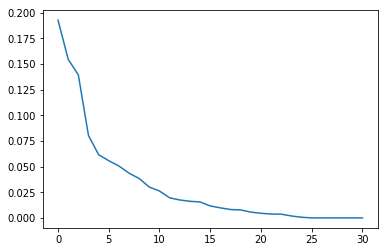

In [492]:
#Redo everything with cities

growth_city = pd.concat([x.set_index('ttwa_name') for x in growth_eda_dfs],axis=1,join='inner')
growth_city_norm = growth_city.apply(normalise,axis=0).dropna(axis=0)

#Do the Principal Components analysis with all variables to select a cut-off point
pca_all = PCA()
#Fit
pca_all.fit(growth_city_norm)

#Explained variance to plot
explained_variance = pca_all.explained_variance_ratio_

plt.plot(explained_variance)

#plt.hlines(x = pca_all.explained_variance_ratio_>0.03.index[0])

In [493]:
explained_variance_thres =0.03
num_comps = [(num,x) for num, x in enumerate(explained_variance) if x>explained_variance_thres][-1][0]

#Extract and transform
pca = PCA(n_components=num_comps)
transformed = pca.fit_transform(growth_city_norm)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


[Text(0,0,'large_rate'),
 Text(0,0,'medium_rate'),
 Text(0,0,'micro_rate'),
 Text(0,0,'small_rate'),
 Text(0,0,'sme_rate'),
 Text(0,0,'emp_herf'),
 Text(0,0,'bc_herf'),
 Text(0,0,'emp_div_2016'),
 Text(0,0,'emp_esp_growth'),
 Text(0,0,'bc_div_2016'),
 Text(0,0,'emp_lq_change'),
 Text(0,0,'bc_lq_change'),
 Text(0,0,'biz_sharebirth'),
 Text(0,0,'biz_sharebl10dec'),
 Text(0,0,'biz_sharebl10inc'),
 Text(0,0,'biz_sharebl10sm'),
 Text(0,0,'biz_sharebv10dec'),
 Text(0,0,'biz_sharebv10logr'),
 Text(0,0,'biz_sharedeath'),
 Text(0,0,'biz_sharehgr'),
 Text(0,0,'emp_sharebirth'),
 Text(0,0,'emp_sharebl10dec'),
 Text(0,0,'emp_sharebl10inc'),
 Text(0,0,'emp_sharebv10dec'),
 Text(0,0,'emp_sharebv10logr'),
 Text(0,0,'emp_sharedeath'),
 Text(0,0,'emp_sharehgr'),
 Text(0,0,'churn'),
 Text(0,0,'surv_t_rate_1'),
 Text(0,0,'surv_t_rate_3'),
 Text(0,0,'surv_t_rate_6')]

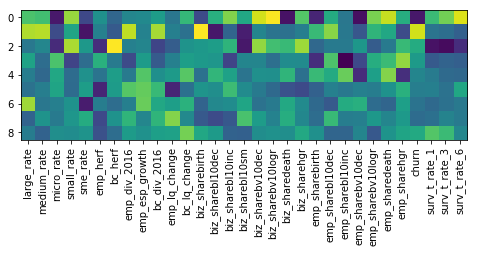

In [494]:
#Redo everything with cities

#Normalise city growth data
growth_city = pd.concat([x.set_index('ttwa_name') for x in growth_eda_dfs],axis=1,join='inner')
growth_city_norm = growth_city.apply(normalise,axis=0).dropna(axis=0)

#Concatenate normalised scores and components
growth_city_norm_comps = pd.concat([growth_city_norm.reset_index(drop=False),pd.DataFrame(transformed,
                                         columns=np.arange(0,transformed.shape[1]))],axis=1)

#Extract the correlations
component_correlation = growth_city_norm_comps.corr()

fig,ax = plt.subplots(figsize=(8,15))

#Produce a heatmap of the correlation between each factor ands all the othewr variables
ax.imshow(component_correlation.loc[np.arange(0,9),[x not in np.arange(0,9) for x in component_correlation.columns]])

ax.set_xticks(np.arange(0,len(growth_city_norm.columns)))
ax.set_xticklabels(growth_city_norm.columns,rotation=90)

In [495]:
%%time
#Now we want to run the clustering

#Grid search problem. 

#We have a bunch of clustering algorithms and hyperparameters. We want to run those ~ 500 each and estimate
#the silouhette score (performance)

#Some of them have number of clusters to tune. Others don't
cluster_grid = [[KMeans,np.arange(3,10)],
                [AgglomerativeClustering, np.arange(3,10)],
                #[DBSCAN],
                [AffinityPropagation],
                [MeanShift],
                [SpectralClustering]]

#Scores container
score = []

#Loop
for x in cluster_grid:
    print(x)
    #If we need to tune the number of clusters:
    if len(x)>1:
        #For each of the cluster numbers
        for num in x[1]:
            sil_store= []
            for iteration in np.arange(0,200):
                #Predict the labels
                labs = x[0](n_clusters=num).fit_predict(transformed)
                
                #Generate the silouhette score
                sil = silhouette_score(transformed,labs)
                sil_store.append(sil)
            score.append([np.mean(sil_store),x[0],num])
    
    else:
    #If number of clusters isn't a hyperparameter
        sil_store = []
    
        for iteration in np.arange(0,200):
            #Predict the labels
            labs = x[0]().fit_predict(transformed)
                
            #Generate the silouhette score
            sil = silhouette_score(transformed,labs)
            sil_store.append(sil)
        
        score.append([np.mean(sil_store),x[0]])
            
            
            
        



[<class 'sklearn.cluster.k_means_.KMeans'>, array([3, 4, 5, 6, 7, 8, 9])]
[<class 'sklearn.cluster.hierarchical.AgglomerativeClustering'>, array([3, 4, 5, 6, 7, 8, 9])]
[<class 'sklearn.cluster.affinity_propagation_.AffinityPropagation'>]
[<class 'sklearn.cluster.mean_shift_.MeanShift'>]
[<class 'sklearn.cluster.spectral.SpectralClustering'>]
CPU times: user 44.3 s, sys: 159 ms, total: 44.5 s
Wall time: 44.7 s


In [496]:
#Some of them have number of clusters to tune. Others don't
sorted(score,key=lambda x:x[0],reverse=True)

[[0.28673669635557697, sklearn.cluster.mean_shift_.MeanShift],
 [0.16305802291044288, sklearn.cluster.k_means_.KMeans, 3],
 [0.15706186108979758,
  sklearn.cluster.hierarchical.AgglomerativeClustering,
  9],
 [0.15398240316691497, sklearn.cluster.k_means_.KMeans, 5],
 [0.1538012579084253, sklearn.cluster.k_means_.KMeans, 7],
 [0.15359260022477997, sklearn.cluster.k_means_.KMeans, 6],
 [0.15286964437205794,
  sklearn.cluster.hierarchical.AgglomerativeClustering,
  4],
 [0.15197394051242222, sklearn.cluster.k_means_.KMeans, 8],
 [0.15164551885319782,
  sklearn.cluster.hierarchical.AgglomerativeClustering,
  8],
 [0.15130539804999976, sklearn.cluster.k_means_.KMeans, 9],
 [0.14751795951536509,
  sklearn.cluster.affinity_propagation_.AffinityPropagation],
 [0.14690890595925785, sklearn.cluster.k_means_.KMeans, 4],
 [0.1458699522502071, sklearn.cluster.hierarchical.AgglomerativeClustering, 6],
 [0.14093201537597391,
  sklearn.cluster.hierarchical.AgglomerativeClustering,
  3],
 [0.138891755

In [497]:
#Now we need a method to robustly allocate observations to clusters

#Idea:
#Run the clustering algorithm and identify pairs of observations
#Concatenate them. 
#Count how often are organisations paired together.


city_names = growth_city_norm.index

#These two lists store the results from the clustering
labels_store = []
combinations_store=[]

#Create a lookup of indices to city names
city_lookup = {num:y for num,y in enumerate(city_names)}

#This loops runs 5000 Kmeans clusters and stores the results in a list. We will use this list to create
#a network and identify its communities.

for x in np.arange(0,5000):
    #Run the clustering algorithm
    km = KMeans(n_clusters=5)
    
    labs = km.fit_predict(transformed)
    
    #This is a list of labels we append to the labs store container. We will use these data for consensus clustering
    labels_store.append(labs)
    
    labs_robustness = pd.Series(labs,index=city_names).sort_values()
    
    for y in set(labs_robustness):
        #Relevant cities
        cities = list(labs_robustness.index[labs_robustness==y])
        
        #combs = pd.DataFrame(list(combinations(cities,2)),columns=['c1','c2'])
        
        combinations_store.append(cities)
        
        
#all_matches = pd.concat(combinations_store)


In [498]:
#Put the cluster labels in a format we can work with
cluster_labels_consensus = np.array(pd.concat([pd.Series(x) for x in labels_store],axis=1))

In [499]:
import networkx as nx
import community

#Extract network from the combinations and detect communities inside it.
net = extract_network_from_corpus(combinations_store)
allocation = community.best_partition(net,resolution=0.8)

comm_out = pd.DataFrame({'ttwa_name':[x for x in allocation.keys()], 
              'cluster':[x for x in allocation.values()]}).set_index('ttwa_name').loc[my_ttwas].sort_values('cluster')


ttwas_clustering_ordered = comm_out.dropna().index

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


[Text(0,0,'large_rate'),
 Text(0,0,'medium_rate'),
 Text(0,0,'micro_rate'),
 Text(0,0,'small_rate'),
 Text(0,0,'sme_rate'),
 Text(0,0,'emp_herf'),
 Text(0,0,'bc_herf'),
 Text(0,0,'emp_div_2016'),
 Text(0,0,'emp_esp_growth'),
 Text(0,0,'bc_div_2016'),
 Text(0,0,'emp_lq_change'),
 Text(0,0,'bc_lq_change'),
 Text(0,0,'biz_sharebirth'),
 Text(0,0,'biz_sharebl10dec'),
 Text(0,0,'biz_sharebl10inc'),
 Text(0,0,'biz_sharebl10sm'),
 Text(0,0,'biz_sharebv10dec'),
 Text(0,0,'biz_sharebv10logr'),
 Text(0,0,'biz_sharedeath'),
 Text(0,0,'biz_sharehgr'),
 Text(0,0,'emp_sharebirth'),
 Text(0,0,'emp_sharebl10dec'),
 Text(0,0,'emp_sharebl10inc'),
 Text(0,0,'emp_sharebv10dec'),
 Text(0,0,'emp_sharebv10logr'),
 Text(0,0,'emp_sharedeath'),
 Text(0,0,'emp_sharehgr'),
 Text(0,0,'churn'),
 Text(0,0,'surv_t_rate_1'),
 Text(0,0,'surv_t_rate_3'),
 Text(0,0,'surv_t_rate_6')]

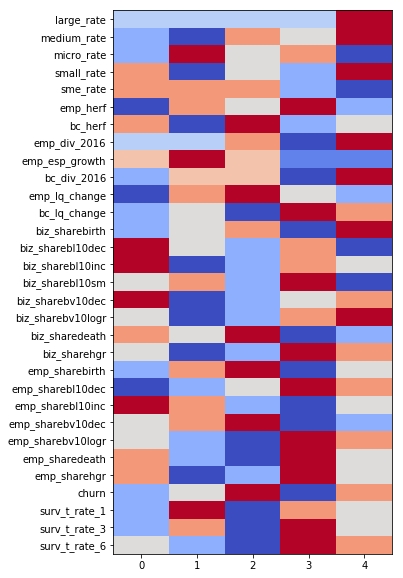

In [500]:
#Plot differences between clusters
labelled_df = pd.concat(
    [growth_city_norm,comm_out],axis=1).loc[my_ttwas]

labelled_df.rename(columns={0:'cluster'},inplace=True)

fig,ax = plt.subplots(figsize=(5,10))

meds = labelled_df.groupby('cluster').median().rank()


ax.imshow(meds.T,aspect='auto',cmap='coolwarm')

ax.set_yticks(np.arange(0,len(meds.T.index)))
ax.set_yticklabels(meds.T.index)

#ax.set_xticks(np.arange(0,len(meds.index)))
#ax.set_xticklabels(set(meds.index))

In [501]:
#What are the distances between clusters? We want to use that to arrange the rows and columns in the heatmap

means = labelled_df.groupby('cluster').mean()

cluster_distances = means.T.corr().sort_values(1,ascending=False).index

#cluster_distances

In [502]:
#Here we 

clusters_and_labels = labelled_df['cluster'].dropna()


#clusters_and_labels
ttwas_clustering_ordered= [(city,num) for el,num in zip([clusters_and_labels.index[
    clusters_and_labels==x] for x in cluster_distances],cluster_distances) for city in el] 

ttwas_clust_ord_unl = [x[0] for x in ttwas_clustering_ordered]


#Dataframe
ttwas_clustering_ordered_df = pd.DataFrame({'cluster_index':[x[1] for x in ttwas_clustering_ordered]},
                                           index=[x[0] for x in ttwas_clustering_ordered])

In [503]:
#Set-up for the chart

#The -1 removes Belfast (for which we have no data)
#ordered = labelled_df['cluster'].sort_values()

#Give the correlation matrix some indices
#Correlation between city profiles
city_corr = pd.DataFrame(transformed).T.corr()

city_corr.index=growth_city_norm.index
city_corr.columns=growth_city_norm.index

#Focus on our clusters
city_corr = city_corr.loc[[x in my_ttwas for x in city_corr.index],
                                  [x in my_ttwas for x in city_corr.columns]]

#Color palette and color type lookup
cluster_type_colors = plt.cm.get_cmap('Set1').colors[:5]

cluster_type_col_lookup = {num:cluster_type_colors[num] for num in np.arange(0,5)}

#Also create a city - color lookup.
ttwa_color_lu = {x[0]:cluster_type_col_lookup[int(x[1])] for x in ttwas_clustering_ordered}

#Remove some irrelevant stuff
selected_vars = [x for x in growth_city_norm.columns if x not in ['sme_rate','small_rate','emp_esp_growth']]


#Reorder index
selected_vars_index = [0,1,2,3,5,4,6,7,8,9,11,14,16,12,10,13,15,17,19,21,23,18,20,22,24,25,26,27]

clean_growth_dyn_names = ['Large firms (%)','Medium firms (%)','Micro firms (%)',
                          
                          'Sector specialisation (jobs)','Sector diversity (jobs)',
                          'Sector specialisation (businesses)','Sector diversity (businesses)',
                          'Clustering growth (jobs)',
                          'Clustering growth (businesses)',
                          
                          'New firms (% firms)','Micro growth (% firms)','Non-micro growth (% firms)',
                          'High growth (% firms)','Micro stable (% firms)',

                          "Micro decline (% firms)","Non-micro decline (% firms)","Out of business (% firms)",
                          
                          'New firms (% new jobs)','Micro growth (% new jobs)','Non-micro growth (% new jobs)',
                          'High growth (% new jobs)',
                          'Non-micro decline (% lost jobs)','Micro decline (% lost jobs)',
                          'Out of businesses (% lost jobs)',
                          
                          'Churn','Surv. rate (1 year)','Surv. rate (3 years)','Surv. rate (6 years)']

#growth_city_norm.columns
selected_vars_ordered = [selected_vars[x] for x in selected_vars_index]

long_name_short_name_lookup = {x:y for x,y in zip(selected_vars_ordered,clean_growth_dyn_names)}

cluster_categories = ['Cluster type 1','Cluster type 2','Cluster type 3','Cluster type 4','Cluster type 5']


In [504]:
cluster_distances

Float64Index([1.0, 2.0, 3.0, 0.0, 4.0], dtype='float64', name='cluster')

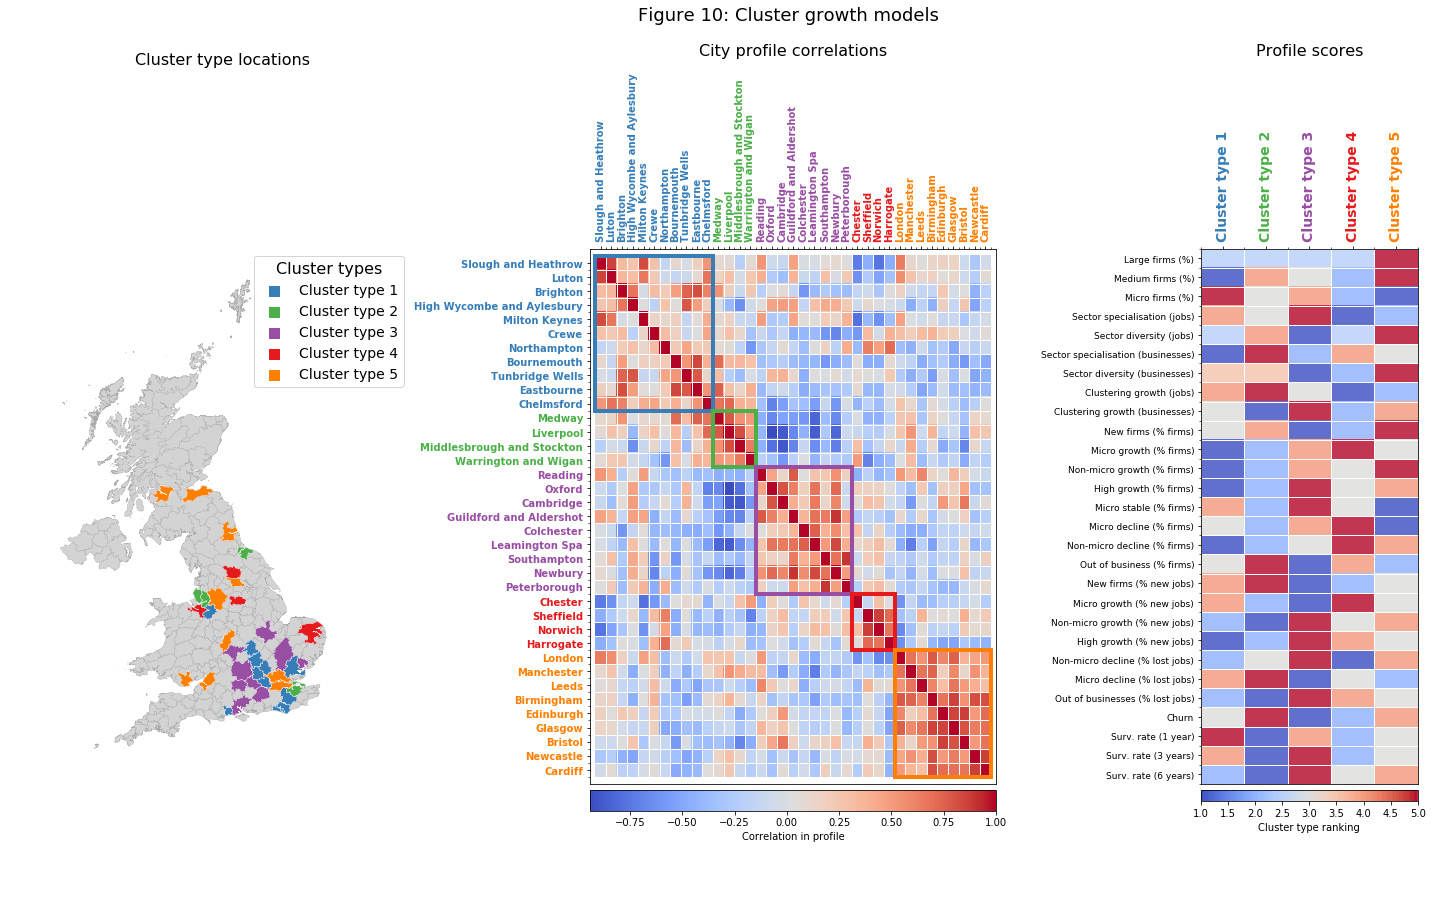

In [505]:
#Plot the map of the UK

#Axes
fig,(ax_1,ax_2,ax_3) = plt.subplots(figsize=(20,12),
                                                   ncols=3,
                                                   #Lay down a grid
                                                   gridspec_kw={'width_ratios':[1.2,1.5,0.8]})

#1st a Map
#Create the geodataframe with the data
cluster_types = pd.merge(ttwa_shp_read,ttwas_clustering_ordered_df.reset_index(drop=False),left_on='TTWA11NM',
                         right_on='index',how='outer')

#Plot the basemap
cluster_types.plot(color='lightgrey',ax=ax_1,edgecolors='darkgrey',linewidth=0.3)

#Plot the TTWAs using the color lookup
for x in np.arange(0,5):
    cluster_set = cluster_types.loc[cluster_types.cluster_index==x,:]
    
    cluster_set.plot(color=cluster_type_col_lookup[x],ax=ax_1,edgecolors='white',linewidth=0.3,legend=True)
    

#Arrange axes (we partly need to do this to deal with some misalignement between axes created by the 
#colorbars in the heatmaps. It is quite a hacky solution which I shoudl fix.

#Axes
ax_1.set_xlim(0,800000)
ax_1.set_ylim(-350000,1300000)
ax_1.set_axis_off()

#Title
ax_1.set_title('Cluster type locations',y=1.28,size=16)


#Create a heatmap of similarities between locations
a2 = ax_2.imshow(city_corr.loc[ttwas_clust_ord_unl,
                             ttwas_clust_ord_unl],
               #cmap=this_cmap,
               cmap='coolwarm',
               aspect='auto')

#Creaye the xticks and labels
ax_2.set_xticks(np.arange(0,len(ttwas_clust_ord_unl)))
ax_2.set_xticklabels(ttwas_clust_ord_unl,rotation=90)
ax_2.xaxis.tick_top()

ax_2.set_yticklabels(ttwas_clust_ord_unl)
ax_2.set_yticks(np.arange(0,len(ttwas_clustering_ordered)))


ax_2.set_xlim(-1,len(city_corr))
ax_2.set_ylim(len(city_corr),-1)

#Add a grid to the set.
ax_2.set_yticks(np.arange(0.5,len(city_corr)+0.5),minor=True)
ax_2.set_xticks(np.arange(0.5,len(city_corr)+0.5),minor=True)
ax_2.grid(which='minor',color='white',linestyle='-',linewidth=1)


#Change colors of axes tick labels using the cluster lookup
#First the x axis
[tick_label.set_color(ttwa_color_lu[name]) for name,tick_label in zip(ttwas_clust_ord_unl,ax_2.get_xticklabels())]
ax_2.set_xticklabels(ax_2.get_xticklabels(),{'weight':'bold'})

#Then the y axis
[tick_label.set_color(ttwa_color_lu[name]) for name, tick_label in zip(ttwas_clust_ord_unl,
                                                                      ax_2.get_yticklabels())]
ax_2.set_yticklabels(ax_2.get_xticklabels(),{'weight':'bold'})

#Highlight the clusters
#This is the order of cities in the DF
orders = ttwas_clustering_ordered_df.reset_index(drop=True)

#The function below uses the index to extract the coordinates of the square
ser = []

#For each cluster type, find the max and min of its index
for x in cluster_distances:
    var = orders[orders==x].dropna().index
    ser.append([min(var),max(var)])

#This was challenging!
for coord,clust_num in zip(ser,cluster_distances):
    
    clust_color = cluster_type_col_lookup[clust_num]
    
    ax_2.plot([coord[0]-0.5,coord[0]-0.5],[coord[0]-0.5,coord[1]+0.5],color=clust_color,linewidth=4,
              #alpha=0.8
             )
    ax_2.plot([coord[0]-0.5,coord[1]+0.5],[coord[1]+0.5,coord[1]+0.5],color=clust_color,linewidth=4,
              #alpha=0.8
             )
    
    ax_2.plot([coord[1]+0.5,coord[1]+0.5],[coord[1]+0.5,coord[0]-0.5],color=clust_color,linewidth=4,
              #alpha=0.8
             )
 
    ax_2.plot([coord[0]-0.5,coord[1]+0.5],[coord[0]-0.5,coord[0]-0.5],color=clust_color,linewidth=4,
              #alpha=0.8
             )
    
#Title of that axis
ax_2.set_title('City profile correlations',y=1.35,size=16)

#3rd plot
#Plot differences between clusters
labelled_df = pd.concat(
    [growth_city_norm,comm_out],axis=1).loc[my_ttwas]

labelled_df.rename(columns={0:'cluster'},inplace=True)


#Calculate medians and rank them
meds = labelled_df.groupby('cluster').median().rank()[selected_vars_ordered]

#Draw
a3 = ax_3.imshow(meds.T[cluster_distances],aspect='auto',cmap='coolwarm',alpha=0.8)

#Create x tick labels and color
ax_3.set_xticks(np.arange(0,5))
ax_3.set_xticklabels(cluster_categories,rotation=90,size=14)

ax_3.xaxis.tick_top()

#Change colors
[tick_label.set_color(cluster_type_col_lookup [int(x)]) for x,tick_label in zip(
    list(cluster_distances),ax_3.get_xticklabels())]

ax_3.set_xticklabels(ax_3.get_xticklabels(),{'weight':'bold'})

#Yticks
ax_3.set_yticks(np.arange(0,len(meds.T.index)))
ax_3.set_yticklabels([long_name_short_name_lookup[x] for x in meds.T.index],size=9)

#Grid
ax_3.set_yticks(np.arange(-0.5,len(meds.T.index)),minor=True)
ax_3.set_xticks(np.arange(-0.5,5.5),minor=True)
ax_3.grid(which='minor',color='white',linestyle='-',linewidth=1)

#Add title
ax_3.set_title('Profile scores',y=1.35,size=16)

#Add layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

#Custom plots
cl1 = plt.scatter([],[],s=100, marker='s',facecolors=cluster_type_col_lookup[1])
cl2 = plt.scatter([],[],s=100, marker='s',facecolors=cluster_type_col_lookup[2])
cl3 = plt.scatter([],[],s=100, marker='s',facecolors=cluster_type_col_lookup[3])
cl4 = plt.scatter([],[],s=100, marker='s',facecolors=cluster_type_col_lookup[0])
cl5 = plt.scatter([],[],s=100, marker='s',facecolors=cluster_type_col_lookup[4])

#Add legend
legend = plt.legend((cl1,cl2,cl3,cl4,cl5),
           ('Cluster type 1','Cluster type 2','Cluster type 3','Cluster type 4','Cluster type 5'),
           scatterpoints=1,
           title='Cluster types',
           bbox_to_anchor=(-3.65,1),ncol=1,fontsize=14)

legend.get_title().set_fontsize('16')

#Add colorbars
fig.colorbar(a2, ax=ax_2,orientation='horizontal',pad=0.01,label='Correlation in profile')

fig.colorbar(a3, ax=ax_3,orientation='horizontal',pad=0.01,label='Cluster type ranking')

plt.tight_layout()

fig.suptitle('Figure 10: Cluster growth models',size=18,y=1.05,x=0.55)

plt.savefig(fig_path+'/{date}_figure_10_cluster_models.pdf'.format(date=today_str),bbox_inches='tight')

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:25: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:35: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:40: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0


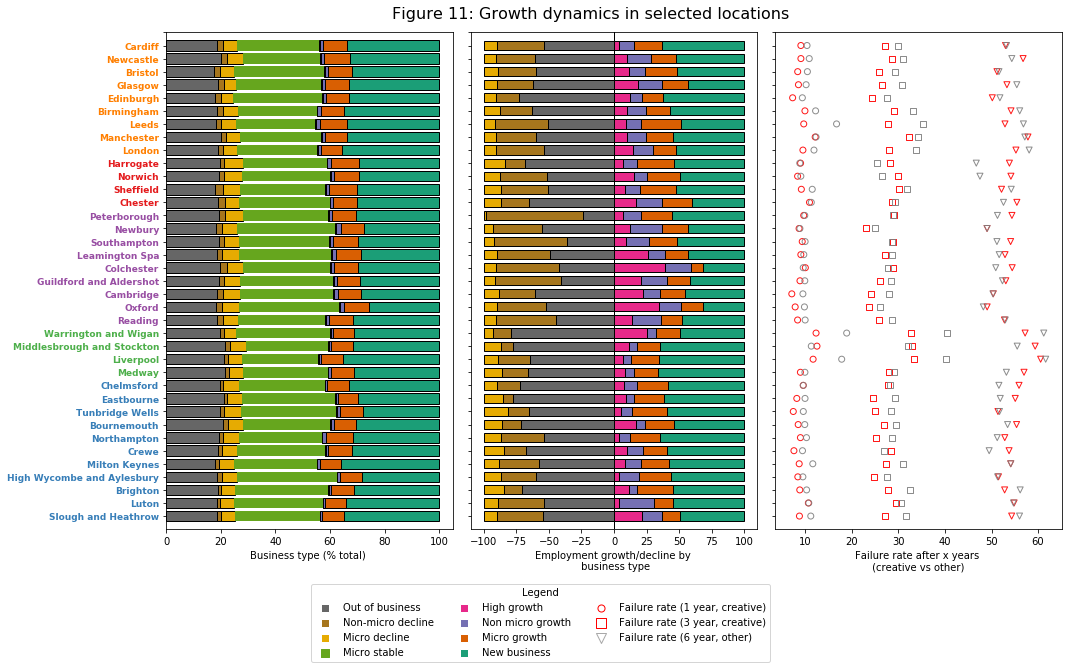

In [506]:
#Draw plot

bar_cols = plt.matplotlib.cm.get_cmap('Dark2_r').colors[:8]

fig,ax = plt.subplots(figsize=(15,8),ncols=3,sharey=True)

#Loop over TTWAs
for num,ttwa in enumerate(ttwas_clust_ord_unl):
    
    #Subset
    ttwa_data = gdyn_merged_cluster.loc[gdyn_merged_cluster.ttwa_name==ttwa,:]
    
    #Bottom for bars
    bot_biz = 0
    bottom_decl=0
    bottom_gr=0
    
    for num_2,sizeb in enumerate(reversed(bands_biz.index)):
        
        #Business growth share
        value_biz=100*float(ttwa_data.loc[ttwa_data.bandemployment==sizeb,'biz_share'])
        #print(value)
        ax[0].barh(bottom=num,width=value_biz,height=0.8,left=bot_biz,
               color=bar_cols[num_2],
               edgecolor='black' if sizeb in band_biz_pos else 'black' if sizeb in bands_biz_negs else None)
        
        bot_biz = bot_biz+value_biz
        
        #Employment value
        value_emp = 100*float(ttwa_data.loc[ttwa_data.bandemployment==sizeb,'emp_share'])
        
        #Plot upwards if the sizeband is positive, downwards if the sizeband is negative
        if sizeb in list(bands_biz_negs):
            ax[1].barh(bottom=num,width =value_emp,height=0.7,left=bottom_decl,color=bar_cols[num_2],
                     edgecolor='black')
            bottom_decl = bottom_decl + value_emp
            
        if sizeb in list(band_biz_pos):
            ax[1].barh(bottom=num,width =value_emp,height=0.7,left=bottom_gr,color=bar_cols[num_2],
                     edgecolor='black')
            bottom_gr = bottom_gr + value_emp
        
        #Draw horizontal line
        ax[1].vlines(x=0,ymin=-1,ymax=len(my_ttwas)+0.5,linewidth=1)
    
    
        
        
        #Survivals
    surv_in_ttwa = surv_sel.loc[surv_sel.ttwa_name==ttwa,:]
        
    for y in ['surv_t_rate_1','surv_t_rate_3','surv_t_rate_6']:
        surv_cr= 100-100*float(surv_in_ttwa.loc[surv_in_ttwa.variable==y,'Creative'])
        surv_other= 100-100*float(surv_in_ttwa.loc[surv_in_ttwa.variable==y,'Other or unknown'])
        
            #print(surv_cr)
        
        if '1' in y:
            my_marker = 'o'
            
        if '3' in y:
            my_marker = 's'
            
        if '6' in y:
            my_marker = 'v'
        
        
        ax[2].scatter(y=num,x=surv_cr,marker=my_marker,color='red',alpha=0.9,facecolors='none')
        ax[2].scatter(y=num,x=surv_other,marker=my_marker,color='grey',alpha=0.9,facecolors='none')
        
    ax[0].set_yticks(np.arange(0,len(my_ttwas)))
    ax[0].set_yticklabels(ttwas_clust_ord_unl,
                          #rotation=90,
                              #ha='right'
                          size=9)


#Label titles
ax[0].set_xlabel('Business type (% total) \n')
ax[1].set_xlabel('Employment growth/decline by \n business type')
#ax[2].set_xlabel('Business type \n (creative vs other)')
ax[2].set_xlabel('Failure rate after x years \n (creative vs other) \n')
    

#Some final customisation
[ax[num].set_ylim(-1,len(ttwas_clust_ord_unl)) for num in [0,1,2]]        

#Customise labels
[tick.set_color(cluster_type_col_lookup[c_type]) for c_type,tick in zip([x[1] for x in ttwas_clustering_ordered],
                                                                            ax[0].yaxis.get_ticklabels())]

#Set xticklabels bold (to make them easier to read)
ax[0].set_yticklabels(ax[0].get_yticklabels(),{'weight':'bold'})

#Legends
#Add custom legend with some invisible scatters
#Performance

death = plt.scatter([],[], s=80, marker='s',color=bar_cols[0],edgecolor='white')
bv10dec = plt.scatter([],[], s=80, marker='s',color=bar_cols[1],edgecolor='white')
bl10dec = plt.scatter([],[], s=80, marker='s',color=bar_cols[2],edgecolor='white')
bl10sm = plt.scatter([],[], s=80, marker='s',color=bar_cols[3])
hgr = plt.scatter([],[], s=80, marker='s',color=bar_cols[4],edgecolor='white')
bv10logr = plt.scatter([],[], s=80, marker='s',color=bar_cols[5],edgecolor='white')
bl10inc = plt.scatter([],[], s=80, marker='s',color=bar_cols[6],edgecolor='white')
birth = plt.scatter([],[], s=80, marker='s',color=bar_cols[7],edgecolor='white')

#Survival
surv_1 = plt.scatter([],[],s=50, marker='o',color='red',facecolors='white')
surv_3 = plt.scatter([],[],s=100, marker='s',color='red',facecolors='white')
surv_5 = plt.scatter([],[],s=100, marker='v',color='darkgrey',facecolors='white')


#Add legend
plt.legend((death, bv10dec, bl10dec, bl10sm, hgr, bv10logr, bl10inc, birth,surv_1,surv_3,surv_5),
           ('Out of business','Non-micro decline','Micro decline','Micro stable','High growth','Non micro growth',
           'Micro growth','New business','Failure rate (1 year, creative)',
            'Failure rate (3 year, creative)','Failure rate (6 year, other)'),
           scatterpoints=1,
           title='Legend',
           bbox_to_anchor=(0,-0.1),ncol=3,fontsize=10)  

plt.subplots_adjust(wspace=0.04)

plt.tight_layout()

fig.suptitle('Figure 11: Growth dynamics in selected locations',y=1.02,x=0.55,size=16)

plt.savefig(fig_path+'/{date}_figure_11_growth_dynamics_hor.pdf'.format(date=today_str),bbox_inches='tight')

## Outputs for GlassAI analysis

In [507]:
off_stats = all_changes

#Add TTWA codes
off_stats['ttwa_code'] = [{x[1]:x[0] for x in ttwa_name_lookup.items()}[x] for x in off_stats['ttwa_name']]
off_stats['is_cluster'] = [x in my_ttwas for x in off_stats.ttwa_name]


all_changes.to_csv(ext_data+'/{today}_processed_data.csv'.format(today=today_str))

## Outputs for Roxana

In [508]:
def add_metadata(df):
    '''
    Adds regions, ttwa code and whether an organisation is a cluster to a df
    '''
    
    if 'ttwa_name' not in df.columns:
        df.reset_index(drop=False,inplace=True)
    
    if 'ttwa_code' not in df.columns:
        df['ttwa_code']= [ttwa_names_to_codes_lookup[x] for x in df.ttwa_name]
    
    df['region'] = [ttwa_region_lookup[x] for x in df.ttwa_name]
    
    df['is_cluster'] = [x in my_ttwas for x in df.ttwa_name]
    
    return(df)
    
    
    

In [509]:
rox_path = top+'/data/roxana/'

#Bres totals
add_metadata(bres_totals).to_csv(rox_path+'{date}_employment_totals.csv'.format(date=today_str),index=False)



#Bres changes
bres_changes_wide = pd.pivot_table(bres_changes,index='ttwa_name',columns='sector',values='employment_change')-1
add_metadata(bres_changes_wide).to_csv(rox_path+'{date}_employment_changes.csv'.format(date=today_str),index=False)


#IDBR totals
add_metadata(idbr_all_wide).to_csv(rox_path+'{date}_business_totals.csv'.format(date=today_str),index=False)

#IDBR changes
idbr_changes_wide = pd.pivot_table(idbr_changes,index='ttwa_name',columns='sector',values='business_change')-1

add_metadata(idbr_changes_wide).to_csv(rox_path+'{date}_business_change.csv'.format(date=today_str),index=False)

#IDBR sizebands


In [510]:
#Sizebands
idbr_sizebands_out = idbr_sizebands.copy()

idbr_sizebands_out['sector_size'] = [y+'_'+x for x,y in zip(idbr_sizebands_out['sector'],
                                                           idbr_sizebands_out['sizeband'])]

idbr_sizebands_out_wide = pd.pivot_table(idbr_sizebands_out,index=['ttwa_name','year'],columns='sector_size',
                                        values='value')

#Out
add_metadata(idbr_sizebands_out_wide).to_csv(rox_path+'{date}_business_sizebands.csv'.format(date=today_str),index=False)

In [511]:
#Growth dynamics

gdyn_rox = gdyn_sel.loc[(gdyn_sel.cohort=='201013-201316') &
                        (gdyn_sel.industry=='All creative'),['ttwa_name','bandemployment',
                                                            'd_employment','entref','biz_share','emp_share']]


gdyn_rox.rename(columns={'bandemployment':'company type',
                         'd_employment':'employment_change',
                        'entref':'n_company',
                         'biz_share':'share_all_business',
                         'emp_share':'share_all_employment_change'},inplace=True)

add_metadata(gdyn_rox.dropna()).to_csv(rox_path+'{date}_growth_dynamics.csv'.format(date=today_str),index=False)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [512]:
#Survival
surv_eda_rox = surv_eda_sel.copy()

surv_eda_rox.columns = ['ttwa_name','survival_rate_1_year','survival_rate_3_year','survival_rate_6_year']


add_metadata(surv_eda_rox).to_csv(rox_path+'{date}_survival_rates.csv'.format(date=today_str),index=False)